# یکپارچه سازی فایل ها و ساخت دیتاست

### اجرای کتابخانه های مورد نیاز

In [1]:
# --- Built-in ---
import calendar
import gc
import re
import warnings
from datetime import datetime, timedelta
from pathlib import Path
from collections import defaultdict

# --- Third-party ---
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import numpy as np
import pandas as pd
import seaborn as sns
from IPython.display import HTML, display
from scipy import stats
from scipy.stats import mannwhitneyu, pearsonr, spearmanr, ttest_ind, f_oneway
from tabulate import tabulate
import warnings
from statsmodels.stats.multicomp import pairwise_tukeyhsd
# --- تنظیمات ---
warnings.filterwarnings("ignore")


### تنظیمات نمایش متون انگلیسی و فارسی

In [2]:
display(HTML("""
<style>
  /* JupyterLab */
  .jp-RenderedMarkdown, .jp-RenderedHTMLCommon {
    direction: rtl;
    text-align: right;
    unicode-bidi: isolate;
  }
  /* Notebook کلاسیک */
  div.text_cell_render, .rendered_html {
    direction: rtl;
    text-align: right;
    unicode-bidi: isolate;
  }
</style>
"""))

### مرحله 1 : تعریف کلاس مادر برای پردازش فایل‌های parquet

In [19]:
class TennisDataProcessor:
    def __init__(self, base_path):
        self.base_path = Path(base_path)
        self.all_data = {}
        self.failed_files = []
        self.data_by_prefix = {}

    def extract_file_components(self, filename):
        """استخراج اجزای نام فایل: prefix_number"""
        match = re.match(r"([a-zA-Z_]+)_(\d+)", filename)
        if match:
            prefix = match.group(1)
            number = int(match.group(2))
            return prefix, number
        return filename, 0

    def get_sorted_folders(self):
        """دریافت لیست مرتب شده پوشه‌ها"""
        folders = [f for f in self.base_path.iterdir() if f.is_dir()]
        folders_sorted = sorted(folders, key=lambda x: x.name)
        return folders_sorted

    def get_file_types_in_folder(self, folder_path):
        """استخراج انواع فایل‌های موجود در یک پوشه"""
        parquet_files = list(folder_path.glob("*.parquet"))

        prefixes = set()
        prefix_counts = {}

        for file_path in parquet_files:
            prefix, _ = self.extract_file_components(file_path.stem)
            prefixes.add(prefix)

            if prefix not in prefix_counts:
                prefix_counts[prefix] = 0
            prefix_counts[prefix] += 1

        return prefixes, prefix_counts

    def find_missing_files(self):
        """یافتن پوشه‌هایی که فایل‌های خاصی در آنها وجود ندارد"""
        folders = self.get_sorted_folders()

        print("\n🔍 بررسی فایل‌های گمشده...")
        print("=" * 80)

        # جمع‌آوری همه prefix ها
        all_prefixes = set()
        folder_prefixes = {}

        for folder in folders:
            prefixes, _ = self.get_file_types_in_folder(folder)
            folder_prefixes[folder.name] = prefixes
            all_prefixes.update(prefixes)

        # یافتن فایل‌های گمشده
        missing_report = {}

        for prefix in sorted(all_prefixes):
            folders_with_prefix = [f for f, p in folder_prefixes.items() if prefix in p]
            folders_without_prefix = [
                f for f, p in folder_prefixes.items() if prefix not in p
            ]

            if folders_without_prefix:
                missing_report[prefix] = {
                    "found_in": len(folders_with_prefix),
                    "missing_in": folders_without_prefix,
                }

        # نمایش گزارش
        if missing_report:
            print("\n⚠️ فایل‌های گمشده:")
            for prefix, info in missing_report.items():
                print(f"\n📁 '{prefix}':")
                print(f"   ✓ موجود در {info['found_in']} پوشه")
                print(f"   ✗ گمشده در پوشه‌های:")
                for folder_name in info["missing_in"][:5]:  # نمایش حداکثر 5 پوشه
                    print(f"      - {folder_name}")
                if len(info["missing_in"]) > 5:
                    print(f"      ... و {len(info['missing_in']) - 5} پوشه دیگر")
        else:
            print("✅ همه فایل‌ها در تمام پوشه‌ها موجود هستند")

        # بررسی تشابه نام‌ها
        print("\n🔍 بررسی تشابه نام‌ها...")
        similar_names = self.find_similar_names(all_prefixes)
        if similar_names:
            print("\n⚠️ نام‌های مشابه یافت شد:")
            for group in similar_names:
                print(f"   • {', '.join(group)}")

        print("=" * 80)
        return missing_report

    def find_similar_names(self, names):
        """یافتن نام‌های مشابه که ممکن است اشتباه تایپی باشند"""
        from difflib import SequenceMatcher

        similar_groups = []
        processed = set()

        for name1 in names:
            if name1 in processed:
                continue

            group = [name1]
            for name2 in names:
                if name2 != name1 and name2 not in processed:
                    similarity = SequenceMatcher(None, name1, name2).ratio()
                    if similarity > 0.8:  # 80% شباهت
                        group.append(name2)
                        processed.add(name2)

            if len(group) > 1:
                similar_groups.append(group)
            processed.add(name1)

        return similar_groups

    def show_available_folders(self, show_count=10, show_file_types=True):
        """نمایش لیست پوشه‌های موجود با جزئیات"""
        folders = self.get_sorted_folders()

        print("\n" + "=" * 80)
        print("📁 پوشه‌های موجود:")
        print("=" * 80)

        for i, folder in enumerate(folders[:show_count], 1):
            total_files = len(list(folder.glob("*.parquet")))

            print(f"\n{i:3}. 📅 {folder.name}")
            print(f"     📊 تعداد کل فایل‌ها: {total_files}")

            if show_file_types and total_files > 0:
                prefixes, prefix_counts = self.get_file_types_in_folder(folder)

                if prefixes:
                    print(f"     📂 انواع فایل‌ها ({len(prefixes)} نوع):")

                    sorted_prefixes = sorted(prefix_counts.items())
                    max_items_per_line = 3

                    for j in range(0, len(sorted_prefixes), max_items_per_line):
                        line_items = sorted_prefixes[j : j + max_items_per_line]
                        line_text = "        "
                        for prefix, count in line_items:
                            line_text += f"• {prefix}({count})  "
                        print(line_text)

        if len(folders) > show_count:
            print(f"\n     ... و {len(folders) - show_count} پوشه دیگر")

        print("\n" + "=" * 80)
        print(f"📊 خلاصه:")
        print(f"   • مجموع پوشه‌ها: {len(folders)}")
        total_all_files = sum(len(list(f.glob("*.parquet"))) for f in folders)
        print(f"   • مجموع فایل‌ها: {total_all_files:,}")
        print("=" * 80 + "\n")

        return folders

    def inspect_parquet_file(
        self, file_path=None, folder_idx=1, file_prefix=None, rows=5
    ):
        """
        بررسی محتوای یک فایل parquet

        Parameters:
        -----------
        file_path: مسیر مستقیم فایل
        folder_idx: شماره پوشه
        file_prefix: prefix فایل مورد نظر
        rows: تعداد ردیف‌های نمایشی
        """
        if file_path:
            # استفاده از مسیر مستقیم
            target_file = Path(file_path)
        else:
            # یافتن فایل بر اساس پارامترها
            folders = self.get_sorted_folders()
            if folder_idx > len(folders):
                print(f"❌ پوشه شماره {folder_idx} وجود ندارد")
                return None

            folder = folders[folder_idx - 1]

            if file_prefix:
                # یافتن اولین فایل با این prefix
                files = list(folder.glob(f"{file_prefix}_*.parquet"))
                if not files:
                    print(
                        f"❌ فایلی با prefix '{file_prefix}' در پوشه {folder.name} یافت نشد"
                    )
                    return None
                target_file = files[0]
            else:
                # انتخاب اولین فایل
                files = list(folder.glob("*.parquet"))
                if not files:
                    print(f"❌ هیچ فایل parquet در پوشه {folder.name} یافت نشد")
                    return None
                target_file = files[0]

        print(f"\n📄 بررسی فایل: {target_file.name}")
        print(f"📁 از پوشه: {target_file.parent.name}")
        print("=" * 80)

        try:
            # خواندن فایل
            df = pd.read_parquet(target_file)

            # نمایش اطلاعات کلی
            print(f"\n📊 اطلاعات کلی:")
            print(f"   • تعداد ردیف: {len(df):,}")
            print(f"   • تعداد ستون: {len(df.columns)}")
            print(
                f"   • حجم حافظه: {df.memory_usage(deep=True).sum() / 1024**2:.2f} MB"
            )

            # نمایش ستون‌ها و نوع داده
            print(f"\n📋 ستون‌ها و نوع داده:")
            for col in df.columns:
                print(f"   • {col}: {df[col].dtype}")

            # نمایش چند ردیف اول
            print(f"\n🔍 نمونه داده ({rows} ردیف اول):")
            print(df.head(rows).to_string())

            # آمار توصیفی
            print(f"\n📈 آمار توصیفی:")
            print(df.describe().to_string())

            # بررسی مقادیر null
            null_counts = df.isnull().sum()
            if null_counts.any():
                print(f"\n⚠️ مقادیر Null:")
                for col, count in null_counts[null_counts > 0].items():
                    print(f"   • {col}: {count} ({count/len(df)*100:.1f}%)")

            return df

        except Exception as e:
            print(f"❌ خطا در خواندن فایل: {e}")
            return None

    def select_folders_to_process(self, folder_range="all"):
        """انتخاب پوشه‌ها برای پردازش"""
        all_folders = self.get_sorted_folders()
        print(f"تعداد کل پوشه‌های موجود: {len(all_folders)}")

        selected_folders = []

        if folder_range == "all":
            selected_folders = all_folders
            print(f"✓ همه {len(selected_folders)} پوشه انتخاب شدند")

        elif isinstance(folder_range, int):
            if 1 <= folder_range <= len(all_folders):
                selected_folders = [all_folders[folder_range - 1]]
                print(
                    f"✓ پوشه شماره {folder_range} انتخاب شد: {selected_folders[0].name}"
                )
            else:
                print(f"✗ شماره پوشه نامعتبر: {folder_range}")

        elif isinstance(folder_range, tuple) and len(folder_range) == 2:
            start, end = folder_range
            if 1 <= start <= end <= len(all_folders):
                selected_folders = all_folders[start - 1 : end]
                print(
                    f"✓ {len(selected_folders)} پوشه از شماره {start} تا {end} انتخاب شدند"
                )
                print(f"  از: {selected_folders[0].name}")
                print(f"  تا: {selected_folders[-1].name}")
            else:
                print(f"✗ محدوده نامعتبر: {start} تا {end}")

        elif isinstance(folder_range, str) and ":" in folder_range:
            start_date, end_date = folder_range.split(":")
            selected_folders = [
                f for f in all_folders if start_date <= f.name <= end_date
            ]
            if selected_folders:
                print(f"✓ {len(selected_folders)} پوشه در محدوده تاریخ انتخاب شدند")
                print(f"  از: {selected_folders[0].name}")
                print(f"  تا: {selected_folders[-1].name}")
            else:
                print(f"✗ هیچ پوشه‌ای در محدوده {start_date} تا {end_date} یافت نشد")

        elif isinstance(folder_range, str):
            selected_folders = [f for f in all_folders if f.name == folder_range]
            if selected_folders:
                print(f"✓ پوشه '{folder_range}' انتخاب شد")
            else:
                print(f"✗ پوشه با نام '{folder_range}' یافت نشد")

        return selected_folders

    def read_parquet_safe(self, file_path):
        """خواندن فایل parquet با مدیریت خطا"""
        try:
            df = pd.read_parquet(file_path, engine="fastparquet")
            return df
        except:
            try:
                df = pd.read_parquet(file_path, engine="pyarrow")
                return df
            except:
                try:
                    import pyarrow.parquet as pq

                    table = pq.read_table(file_path)
                    df = table.to_pandas(ignore_metadata=True)
                    return df
                except:
                    return None

    def process_folders(self, folder_range="all", sample_size=None):
        """پردازش پوشه‌های انتخابی"""
        selected_folders = self.select_folders_to_process(folder_range)

        if not selected_folders:
            print("هیچ پوشه‌ای برای پردازش انتخاب نشد!")
            return

        print(f"\nشروع پردازش {len(selected_folders)} پوشه...")

        for folder_idx, folder in enumerate(selected_folders, 1):
            print(f"\n{'='*50}")
            print(f"پردازش پوشه {folder_idx}/{len(selected_folders)}: {folder.name}")
            print(f"{'='*50}")

            parquet_files = list(folder.glob("*.parquet"))

            if sample_size and sample_size < len(parquet_files):
                parquet_files = parquet_files[:sample_size]
                print(
                    f"📌 فقط {sample_size} فایل از {len(list(folder.glob('*.parquet')))} فایل پردازش می‌شود"
                )

            success_count = 0

            for file_idx, file_path in enumerate(parquet_files, 1):
                if file_idx % 100 == 0:
                    print(f"  پردازش فایل {file_idx}/{len(parquet_files)}...")

                prefix, file_number = self.extract_file_components(file_path.stem)
                df = self.read_parquet_safe(file_path)

                if df is not None:
                    df["source_date"] = folder.name
                    df["source_file"] = file_path.stem
                    df["file_prefix"] = prefix
                    df["file_number"] = file_number
                    df["folder_order"] = folder_idx

                    if prefix not in self.data_by_prefix:
                        self.data_by_prefix[prefix] = []

                    self.data_by_prefix[prefix].append(
                        {
                            "date": folder.name,
                            "folder_order": folder_idx,
                            "file_number": file_number,
                            "data": df,
                        }
                    )

                    success_count += 1
                else:
                    self.failed_files.append(
                        {"folder": folder.name, "file": file_path.name}
                    )

            print(f"  ✓ {success_count} فایل از {len(parquet_files)} فایل خوانده شد")
            gc.collect()

        print(f"\n{'='*50}")
        print(f"پردازش کامل شد!")
        print(f"  - تعداد پوشه‌های پردازش شده: {len(selected_folders)}")
        print(f"  - تعداد دسته‌های یافت شده: {len(self.data_by_prefix)}")
        for prefix, items in self.data_by_prefix.items():
            print(f"    • {prefix}: {len(items)} فایل")
        print(f"{'='*50}")

    def save_current_batch(self, output_path, batch_name=None):
        """ذخیره داده‌های پردازش شده فعلی"""
        output_path = Path(output_path)
        output_path.mkdir(exist_ok=True)

        if not batch_name:
            batch_name = datetime.now().strftime("%Y%m%d_%H%M%S")

        batch_folder = output_path / f"batch_{batch_name}"
        batch_folder.mkdir(exist_ok=True)

        for prefix, items in self.data_by_prefix.items():
            sorted_items = sorted(
                items, key=lambda x: (x["folder_order"], x["file_number"])
            )
            dfs = [item["data"] for item in sorted_items]

            if dfs:
                combined_df = pd.concat(dfs, ignore_index=True)
                safe_prefix = prefix.replace("/", "_").replace("\\", "_")

                combined_df.to_csv(batch_folder / f"{safe_prefix}.csv", index=False)
                print(f"✓ ذخیره شد: {safe_prefix}.csv ({len(combined_df)} ردیف)")

        if self.failed_files:
            pd.DataFrame(self.failed_files).to_csv(
                batch_folder / "failed_files.csv", index=False
            )

        print(f"\n✓ همه داده‌ها در '{batch_folder}' ذخیره شدند")
        return batch_folder

    def clear_memory(self):
        """پاک کردن حافظه"""
        self.data_by_prefix = {}
        self.all_data = {}
        gc.collect()
        print("✓ حافظه پاک شد")


def combine_batches(batch_folder_path):
    """ترکیب همه دسته‌های ذخیره شده"""
    batch_folder = Path(batch_folder_path)
    all_batches = list(batch_folder.glob("batch_*"))

    combined_data = {}

    for batch in all_batches:
        print(f"خواندن {batch.name}...")
        csv_files = list(batch.glob("*.csv"))

        for csv_file in csv_files:
            if csv_file.name != "failed_files.csv":
                prefix = csv_file.stem
                df = pd.read_csv(csv_file)

                if prefix not in combined_data:
                    combined_data[prefix] = []
                combined_data[prefix].append(df)

    final_data = {}
    for prefix, dfs in combined_data.items():
        final_data[prefix] = pd.concat(dfs, ignore_index=True)
        print(f"✓ {prefix}: {len(final_data[prefix])} ردیف")

    return final_data

### مرحله 2 : بررسی اولیه داده‌ها

In [26]:
# مسیر داده‌ها
base_path = "/home/mohammadreza77615/Desktop/Tennis Schema/tennis_data"

# ایجاد پردازشگر
processor = TennisDataProcessor(base_path)

# نمایش پوشه‌ها
processor.show_available_folders(show_count=3)

# یافتن فایل‌های گمشده
missing_report = processor.find_missing_files()

# بررسی محتوای یک فایل نمونه
df_sample = processor.inspect_parquet_file(folder_idx=1, file_prefix="away_team")


📁 پوشه‌های موجود:

  1. 📅 20240201
     📊 تعداد کل فایل‌ها: 4160
     📂 انواع فایل‌ها (15 نوع):
        • away_team(269)  • away_team_score(285)  • event(285)  
        • home_team(273)  • home_team_score(285)  • odds(267)  
        • pbp(265)  • power(271)  • round(262)  
        • season(285)  • statistics(273)  • time(285)  
        • tournament(285)  • venue(285)  • votes(285)  

  2. 📅 20240202
     📊 تعداد کل فایل‌ها: 4131
     📂 انواع فایل‌ها (15 نوع):
        • away_team(258)  • away_team_score(301)  • event(301)  
        • home_team(258)  • home_team_score(301)  • odds(255)  
        • pbp(254)  • power(254)  • round(187)  
        • season(301)  • statistics(257)  • time(301)  
        • tournament(301)  • venue(301)  • votes(301)  

  3. 📅 20240203
     📊 تعداد کل فایل‌ها: 7324
     📂 انواع فایل‌ها (15 نوع):
        • away_team(419)  • away_team_score(612)  • event(612)  
        • home_team(425)  • home_team_score(612)  • odds(356)  
        • pbp(351)  • power(352)  • ro

### مرحله 3 : پردازش 60 پوشه در 6 دسته 10تایی (اجرا کمی زمان بر است)

In [ ]:
# پردازش 60 پوشه در 6 دسته 10تایی
base_path = "/home/mohammadreza77615/Desktop/Tennis Schema/tennis_data"
output_path = "/home/mohammadreza77615/Desktop/Tennis Schema/CSV Files"

for batch_num in range(6):
    start = batch_num * 10 + 1
    end = min((batch_num + 1) * 10, 60)

    print(f"\n{'#'*60}")
    print(f"پردازش دسته {batch_num + 1}: پوشه‌های {start} تا {end}")
    print(f"{'#'*60}")

    processor = TennisDataProcessor(base_path)
    processor.process_folders(folder_range=(start, end))
    processor.save_current_batch(output_path, batch_name=f"folders_{start}_{end}")
    processor.clear_memory()

    print(f"✓ دسته {batch_num + 1} کامل شد")

###  مرحله 4 : ترکیب و ذخیره نهایی

In [ ]:
def save_final_data(final_data, output_path="./final_data", format="parquet"):
    """
    ذخیره داده‌های نهایی با مدیریت خطا

    Parameters:
    -----------
    final_data: dict of DataFrames
    output_path: مسیر ذخیره
    format: 'parquet', 'csv', or 'both'
    """
    # ایجاد پوشه خروجی
    output_dir = Path(output_path)
    output_dir.mkdir(exist_ok=True, parents=True)

    print(f"\n{'='*60}")
    print(f"📁 ذخیره داده‌ها در: {output_dir.absolute()}")
    print(f"{'='*60}")

    successful_saves = []
    failed_saves = []

    for prefix, df in final_data.items():
        print(f"\n📝 پردازش {prefix}...")
        print(f"   • تعداد ردیف: {len(df):,}")
        print(f"   • تعداد ستون: {len(df.columns)}")
        print(f"   • حجم تقریبی: {df.memory_usage(deep=True).sum() / 1024**2:.2f} MB")

        success = False

        # ذخیره به فرمت parquet
        if format in ["parquet", "both"]:
            parquet_file = output_dir / f"{prefix}_complete.parquet"
            try:
                df.to_parquet(parquet_file)
                print(f"   ✓ Parquet ذخیره شد: {parquet_file.name}")
                success = True
            except Exception as e:
                print(f"   ✗ خطا در ذخیره Parquet: {e}")

        # ذخیره به فرمت CSV
        if format in ["csv", "both"] or (format == "parquet" and not success):
            csv_file = output_dir / f"{prefix}_complete.csv"
            try:
                df.to_csv(csv_file, index=False)
                print(f"   ✓ CSV ذخیره شد: {csv_file.name}")
                success = True
            except Exception as e:
                print(f"   ✗ خطا در ذخیره CSV: {e}")

        if success:
            successful_saves.append(prefix)
        else:
            failed_saves.append(prefix)

    # گزارش نهایی
    print(f"\n{'='*60}")
    print(f"📊 گزارش نهایی:")
    print(f"   ✓ موفق: {len(successful_saves)} فایل")
    print(f"   ✗ ناموفق: {len(failed_saves)} فایل")

    if failed_saves:
        print(f"\n⚠️ فایل‌های ناموفق:")
        for prefix in failed_saves:
            print(f"   - {prefix}")

    print(f"{'='*60}\n")

    return successful_saves, failed_saves


# استفاده از تابع جدید
final_data = combine_batches("/home/mohammadreza77615/Desktop/Tennis Schema/CSV Files")

# ذخیره در هر دو فرمت
successful, failed = save_final_data(
    final_data,
    output_path="/home/mohammadreza77615/Desktop/Tennis Schema/Final_parquet",
    format="parquet",
)

### مرحله 5 : بررسی صحت ذخیره‌سازی

In [25]:
def load_final_data(
    directory_path="/home/mohammadreza77615/Desktop/Tennis Schema/Final_parquet",
    file_format="parquet",
):
    """خواندن فایل‌های ذخیره شده"""
    dir_path = Path(directory_path)

    if not dir_path.exists():
        print(f"❌ پوشه {directory_path} وجود ندارد")
        return {}

    loaded_data = {}
    extension = ".parquet" if file_format == "parquet" else ".csv"

    files = list(dir_path.glob(f"*{extension}"))

    print(f"📖 خواندن {len(files)} فایل {file_format}...")

    for file in files:
        prefix = file.stem.replace("_complete", "")

        try:
            if file_format == "parquet":
                df = pd.read_parquet(file)
            else:
                df = pd.read_csv(file)

            loaded_data[prefix] = df
            print(f"   ✓ {prefix}: {len(df):,} ردیف")
        except Exception as e:
            print(f"   ✗ خطا در خواندن {file.name}: {e}")

    return loaded_data


# خواندن داده‌ها
loaded_data = load_final_data(
    "/home/mohammadreza77615/Desktop/Tennis Schema/Final_parquet", file_format="parquet"
)

# بررسی یک نمونه
if "away_team" in loaded_data:
    print(f"\nنمونه داده away_team:")
    print(loaded_data["away_team"].head())

📖 خواندن 15 فایل parquet...
   ✓ away_team: 24,472 ردیف
   ✓ pbp: 2,581,523 ردیف
   ✓ away_team_score: 35,338 ردیف
   ✓ event: 35,338 ردیف
   ✓ home_team: 25,883 ردیف
   ✓ home_team_score: 35,449 ردیف
   ✓ round: 19,545 ردیف
   ✓ season: 35,956 ردیف
   ✓ time: 35,956 ردیف
   ✓ tournament: 35,956 ردیف
   ✓ venue: 35,708 ردیف
   ✓ odds: 60,946 ردیف
   ✓ statistics: 1,374,472 ردیف
   ✓ power: 475,571 ردیف
   ✓ votes: 35,943 ردیف

نمونه داده away_team:
   match_id                name                   slug gender  user_count  \
0  11998445  Auger-Aliassime F.  auger-aliassime-felix      M       23318   
1  11998446          Cobolli F.         flavio-cobolli      M        5995   
2  11998447         Martínez P.         martinez-pedro      M        2621   
3  11998448           Muller A.       muller-alexandre      M        2443   
4  11998449            Mayot H.           mayot-harold      M        1492   

             residence        birthplace  height  weight         plays  ...  \
0  Mo

### مرحله 6 : ساخت دیتاست به جهت تحلیل و کاوش داده‌ها

In [3]:
class TennisDataExplorer:
    def __init__(
        self, data_path="/home/mohammadreza77615/Desktop/Tennis Schema/Final_parquet"
    ):
        self.data_path = Path(data_path)
        self.datasets = {}
        self.metadata = {}

    def load_all_datasets(self):
        """بارگذاری همه دیتاست‌ها"""
        files = {
            "away_team": "away_team_complete.parquet",
            "pbp": "pbp_complete.parquet",
            "away_team_score": "away_team_score_complete.parquet",
            "event": "event_complete.parquet",
            "home_team": "home_team_complete.parquet",
            "home_team_score": "home_team_score_complete.parquet",
            "round": "round_complete.parquet",
            "season": "season_complete.parquet",
            "time": "time_complete.parquet",
            "tournament": "tournament_complete.parquet",
            "venue": "venue_complete.parquet",
            "odds": "odds_complete.parquet",
            "statistics": "statistics_complete.parquet",
            "power": "power_complete.parquet",
            "votes": "votes_complete.parquet",
        }

        print("🔄 بارگذاری دیتافریم ها و تجمیع در دیتاست")
        for name, filename in files.items():
            file_path = self.data_path / filename
            if file_path.exists():
                try:
                    # فقط چند ردیف اول برای بررسی سریع
                    self.datasets[name] = pd.read_parquet(file_path)
                    print(f"   ✓ {name}: {len(self.datasets[name]):,} ردیف")
                except Exception as e:
                    print(f"   ✗ خطا در بارگذاری {name}: {e}")

        return self.datasets

    def analyze_dataset_structure(self):
        """تحلیل ساختار همه دیتاست‌ها"""
        analysis_report = {}

        for name, df in self.datasets.items():
            print(f"\n{'='*60}")
            print(f"📊 تحلیل {name}")
            print(f"{'='*60}")

            analysis = {
                "shape": df.shape,
                "columns": list(df.columns),
                "dtypes": df.dtypes.to_dict(),
                "null_counts": df.isnull().sum().to_dict(),
                "memory_usage": df.memory_usage(deep=True).sum() / 1024**2,  # MB
                "sample_data": df.head(3).to_dict(),
            }

            # نمایش اطلاعات کلیدی
            print(f"📏 ابعاد: {analysis['shape'][0]:,} × {analysis['shape'][1]}")
            print(f"💾 حافظه: {analysis['memory_usage']:.2f} MB")
            print(f"📋 ستون‌ها: {', '.join(analysis['columns'][:5])}")
            if len(analysis["columns"]) > 5:
                print(f"           ... و {len(analysis['columns'])-5} ستون دیگر")

            # بررسی ستون‌های کلیدی احتمالی
            key_columns = []
            for col in df.columns:
                if any(
                    key in col.lower()
                    for key in ["id", "match", "game", "player", "team"]
                ):
                    key_columns.append(col)
                    unique_count = df[col].nunique()
                    print(f"   🔑 {col}: {unique_count:,} مقدار یکتا")

            analysis["potential_keys"] = key_columns
            analysis_report[name] = analysis

            # نمایش نمونه داده
            print(f"\n📝 نمونه داده:")
            print(df.head(2).to_string())

        self.metadata = analysis_report
        return analysis_report

    def find_relationships(self):
        """یافتن روابط بین دیتاست‌ها"""
        print("\n" + "=" * 60)
        print("🔗 بررسی روابط بین دیتاست‌ها")
        print("=" * 60)

        relationships = {}

        # جمع‌آوری همه ستون‌ها
        all_columns = {}
        for name, df in self.datasets.items():
            all_columns[name] = set(df.columns)

        # یافتن ستون‌های مشترک
        for name1 in self.datasets:
            relationships[name1] = {}
            for name2 in self.datasets:
                if name1 != name2:
                    common_cols = all_columns[name1].intersection(all_columns[name2])
                    if common_cols:
                        relationships[name1][name2] = list(common_cols)

        # نمایش روابط
        for dataset, relations in relationships.items():
            if relations:
                print(f"\n📊 {dataset}:")
                for related, columns in relations.items():
                    if columns:
                        print(f"   ↔️ {related}: {', '.join(columns[:3])}")

        return relationships

    def create_data_profile(self):
        """ایجاد پروفایل کامل از داده‌ها"""
        profile = {
            "overview": {},
            "columns_info": {},
            "relationships": {},
            "recommendations": [],
        }

        print("\n" + "=" * 60)
        print("📈 ایجاد پروفایل داده")
        print("=" * 60)

        # اطلاعات کلی
        total_rows = sum(len(df) for df in self.datasets.values())
        total_columns = sum(len(df.columns) for df in self.datasets.values())
        total_memory = (
            sum(df.memory_usage(deep=True).sum() for df in self.datasets.values())
            / 1024**2
        )

        profile["overview"] = {
            "total_datasets": len(self.datasets),
            "total_rows": total_rows,
            "total_columns": total_columns,
            "total_memory_mb": total_memory,
        }

        print(f"\n📊 خلاصه کلی:")
        print(f"   • تعداد دیتاست: {len(self.datasets)}")
        print(f"   • مجموع ردیف‌ها: {total_rows:,}")
        print(f"   • مجموع ستون‌ها: {total_columns}")
        print(f"   • حجم کل: {total_memory:.2f} MB")

        # تحلیل عمیق‌تر برای دیتاست‌های کلیدی
        key_datasets = ["event", "tournament", "pbp", "statistics"]

        for ds_name in key_datasets:
            if ds_name in self.datasets:
                df = self.datasets[ds_name]
                print(f"\n🔍 تحلیل عمیق {ds_name}:")

                # بررسی تاریخ‌ها
                date_cols = [
                    col
                    for col in df.columns
                    if "date" in col.lower() or "time" in col.lower()
                ]
                if date_cols:
                    for col in date_cols[:2]:
                        try:
                            print(f"   📅 {col}: از {df[col].min()} تا {df[col].max()}")
                        except:
                            pass

                # بررسی ID ها
                id_cols = [col for col in df.columns if "id" in col.lower()]
                if id_cols:
                    for col in id_cols[:3]:
                        print(f"   🔑 {col}: {df[col].nunique():,} مقدار یکتا")

        return profile

    def generate_sample_queries(self):
        """ایجاد نمونه کوئری‌های مفید"""
        print("\n" + "=" * 60)
        print("🔍 نمونه تحلیل‌های ممکن")
        print("=" * 60)

        queries = []

        # بر اساس دیتاست‌های موجود
        if "tournament" in self.datasets:
            queries.append("تحلیل تورنمنت‌های مختلف و تعداد مسابقات")

        if "statistics" in self.datasets:
            queries.append("آمار عملکرد بازیکنان در طول زمان")

        if "pbp" in self.datasets:
            queries.append("تحلیل جزئیات بازی و الگوهای امتیازگیری")

        if "odds" in self.datasets:
            queries.append("بررسی دقت پیش‌بینی‌ها بر اساس odds")

        if "power" in self.datasets:
            queries.append("تحلیل قدرت ضربات و تاثیر آن بر نتیجه")

        for i, query in enumerate(queries, 1):
            print(f"   {i}. {query}")

        return queries


# اجرای تحلیل اولیه
explorer = TennisDataExplorer(
    "/home/mohammadreza77615/Desktop/Tennis Schema/Final_parquet"
)
datasets = explorer.load_all_datasets()

🔄 بارگذاری دیتافریم ها و تجمیع در دیتاست
   ✓ away_team: 24,472 ردیف
   ✓ pbp: 2,581,523 ردیف
   ✓ away_team_score: 35,338 ردیف
   ✓ event: 35,338 ردیف
   ✓ home_team: 25,883 ردیف
   ✓ home_team_score: 35,449 ردیف
   ✓ round: 19,545 ردیف
   ✓ season: 35,956 ردیف
   ✓ time: 35,956 ردیف
   ✓ tournament: 35,956 ردیف
   ✓ venue: 35,708 ردیف
   ✓ odds: 60,946 ردیف
   ✓ statistics: 1,374,472 ردیف
   ✓ power: 475,571 ردیف
   ✓ votes: 35,943 ردیف


# بررسی و حل سوالات

### سوال 1 : چند بازیکن تنیس در این مجموعه داده گنجانده شده‌اند؟

🎯 تعداد بازیکنان یکتا + تفکیک جنسیت
👥 Total unique players: 2,644
🚹 Men: 1,408 (53.3%)
🚺 Women: 1,236 (46.7%)


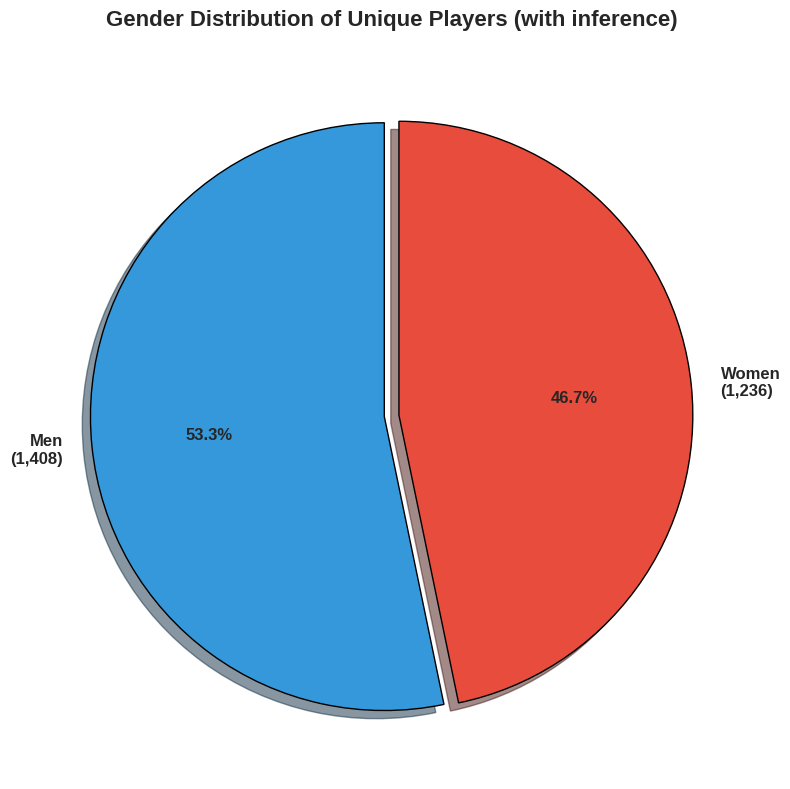

In [24]:
def latest_per_match(df, key='match_id'):
    """آخرین اسنپ‌شات هر مسابقه بر اساس بزرگ‌ترین source_date (برای متادیتاها)."""
    if 'source_date' in df.columns:
        return df.sort_values([key, 'source_date']).drop_duplicates(subset=[key], keep='last')
    return df.drop_duplicates(subset=[key], keep='last')

def infer_match_gender(row):
    """
    استنباط جنسیت مسابقه از روی متادیتا:
    - tournament_category_name: ATP/Challenger/ITF Men/Davis Cup → M | WTA/Challenger Women/ITF Women → F
    - در صورت نامشخص بودن، از کلیدواژه Men/Women در tournament_name یا season_name استفاده می‌کنیم.
    """
    cat = str(row.get('tournament_category_name', '') or '').strip().lower()
    tname = str(row.get('tournament_name', '') or '').strip().lower()
    sname = str(row.get('season_name', '') or '').strip().lower()

    # 1) نگاشت مستقیم دسته تورنومنت
    cat_map_male   = {'atp','challenger','itf men','davis cup'}
    cat_map_female = {'wta','challenger women','itf women'}
    if cat in cat_map_male:
        return 'M'
    if cat in cat_map_female:
        return 'F'

    # 2) کلیدواژه در نام تورنومنت/سِیزن
    haystack = f"{tname} {sname}"
    if 'women' in haystack:
        return 'F'
    if 'men' in haystack:
        return 'M'

    # نامشخص
    return np.nan

def count_unique_players_with_inferred_gender(data_path, plot=True):
    """
    تعداد کل بازیکنان یکتا + تفکیک جنسیت با استنباط از تورنومنت/سِیزن برای بازیکنان فاقد gender.
    - player_id پاکسازی و یکتا می‌شود
    - gender اولیه اگر نباشد، از جنسیت مسابقاتی که بازیکن در آن‌ها بوده استنباط می‌شود (mod/اکثریت)
    - خروجی: شمارش کلی + نمودار دایره‌ای
    """
    data_path = Path(data_path)

    # بارگذاری جداول
    home_team   = pd.read_parquet(data_path / "home_team_complete.parquet")
    away_team   = pd.read_parquet(data_path / "away_team_complete.parquet")
    event       = pd.read_parquet(data_path / "event_complete.parquet")
    tournament  = pd.read_parquet(data_path / "tournament_complete.parquet")
    season      = pd.read_parquet(data_path / "season_complete.parquet")

    # برای متادیتا آخرین اسنپ‌شات را بگیریم
    event      = latest_per_match(event)
    tournament = latest_per_match(tournament)
    season     = latest_per_match(season)

    # رکوردهای بازیکنان از هر دو سمت (match_id برای اتصال به متادیتا لازم است)
    home_players = home_team[['match_id','player_id','name','gender']].copy()
    away_players = away_team[['match_id','player_id','name','gender']].copy()

    # تمیزکاری شناسه بازیکن
    all_player_records = pd.concat([home_players, away_players], ignore_index=True)
    all_player_records['player_id'] = pd.to_numeric(all_player_records['player_id'], errors='coerce')
    all_player_records.dropna(subset=['player_id'], inplace=True)
    all_player_records['player_id'] = all_player_records['player_id'].astype(int)
    all_player_records = all_player_records[all_player_records['player_id'] > 0]

    # یکتا در سطح player_id برای نام (برای خروجی نمایشی)
    base_unique = all_player_records.drop_duplicates(subset=['player_id'], keep='first')[['player_id','name','gender']].copy()

    # اتصال به متادیتا مسابقه جهت استنباط جنسیت مسابقه
    meta = (event[['match_id']]
            .merge(tournament[['match_id','tournament_category_name','tournament_name']], on='match_id', how='left')
            .merge(season[['match_id','name']], on='match_id', how='left')
            .rename(columns={'name':'season_name'}))

    player_with_meta = all_player_records[['match_id','player_id','gender']].merge(meta, on='match_id', how='left')

    # جنسیت مسابقه برای هر match_id
    player_with_meta['match_gender'] = player_with_meta.apply(infer_match_gender, axis=1)

    # برای هر بازیکن، اگر gender اصلی M/F نبود، از modal match_gender استفاده کن
    def infer_gender_for_player(group):
        # جنسیت اصلی
        g0 = group['gender'].dropna()
        if not g0.empty and g0.iloc[0] in ['M','F']:
            return g0.iloc[0]
        # استنباط از متادیتا مسابقات
        mg = group['match_gender'].dropna()
        if mg.empty:
            return 'Unknown'
        # چون منطقی است بازیکن فقط یک جنسیت داشته باشد، mode را می‌گیریم
        mode = mg.mode()
        return mode.iloc[0] if len(mode) else 'Unknown'

    inferred_gender = (player_with_meta.groupby('player_id')
                       .apply(infer_gender_for_player)
                       .reset_index(name='gender_final'))

    # ساخت دیتافریم یکتا بازیکن + gender نهایی
    unique_players = base_unique.merge(inferred_gender, on='player_id', how='left')
    # اگر gender_final NaN بود، Unknown
    unique_players['gender_final'] = unique_players['gender_final'].fillna('Unknown')
    # نرمال‌سازی نهایی
    unique_players['gender_final'] = unique_players['gender_final'].where(unique_players['gender_final'].isin(['M','F']), 'Unknown')

    total_unique_players = len(unique_players)

    # شمارش‌ها
    men_count    = int((unique_players['gender_final'] == 'M').sum())
    women_count  = int((unique_players['gender_final'] == 'F').sum())
    unknown_count= total_unique_players - (men_count + women_count)

    # چاپ نتایج
    print("=" * 80)
    print("🎯 تعداد بازیکنان یکتا + تفکیک جنسیت")
    print("=" * 80)
    print(f"👥 Total unique players: {total_unique_players:,}")
    print(f"🚹 Men: {men_count:,} ({men_count/total_unique_players:.1%})")
    print(f"🚺 Women: {women_count:,} ({women_count/total_unique_players:.1%})")
    if unknown_count > 0:
        print(f"❓ Unknown: {unknown_count:,} ({unknown_count/total_unique_players:.1%})")

    # نمودار
    if plot:
        plt.style.use('seaborn-v0_8-whitegrid')
        fig, ax = plt.subplots(figsize=(8, 8))

        sizes = [men_count, women_count, unknown_count]
        labels = [f'Men\n({men_count:,})', f'Women\n({women_count:,})', f'Unknown\n({unknown_count:,})']
        colors = ['#3498db', '#e74c3c', '#95a5a6']
        explode = (0.05, 0, 0)

        final_sizes  = [s for s in sizes  if s > 0]
        final_labels = [l for s,l in zip(sizes,labels) if s > 0]
        final_colors = [c for s,c in zip(sizes,colors) if s > 0]
        final_explode= [e for s,e in zip(sizes,explode) if s > 0]

        ax.pie(final_sizes, explode=final_explode, labels=final_labels, autopct='%1.1f%%',
               shadow=True, startangle=90, colors=final_colors,
               wedgeprops={'edgecolor':'black'}, textprops={'fontsize':12, 'fontweight':'bold'})
        ax.axis('equal')
        ax.set_title('Gender Distribution of Unique Players (with inference)', fontsize=16, fontweight='bold', pad=20)
        plt.tight_layout()
        plt.show()

    # خروجی
    return {
        'total_unique_players': int(total_unique_players),
        'counts': {'M': men_count, 'F': women_count, 'Unknown': unknown_count},
        'unique_players_df': unique_players[['player_id','name','gender_final']]
    }

# نمونه اجرا:
data_path = "/home/mohammadreza77615/Desktop/Tennis Schema/Final_parquet"
res = count_unique_players_with_inferred_gender(data_path, plot=True)

### سوال 2 : قد متوسط بازیکنان چقدر است؟


📊 استخراج قد یکتای بازیکنان:
--------------------------------------------------
تعداد کل بازیکنان یکتا: 2,644
تعداد بازیکنان با قد معلوم: 1,349
درصد بازیکنان با قد معلوم: 51.0%

🔍 بررسی محدوده داده‌ها:
--------------------------------------------------
محدوده قد (متر): 1.57 - 2.08 متر
محدوده قد (سانتی‌متر): 157 - 208 cm

مقادیر مشکوک:
  • قد کمتر از 1.4 متر: 0
  • قد بیشتر از 2.2 متر: 0
  • داده‌های معتبر: 1,349 از 1,349

📈 آمار قد بازیکنان:
--------------------------------------------------
✅ میانگین قد: 1.82 متر (182.2 سانتی‌متر)
📊 میانه قد: 183.0 سانتی‌متر
📉 انحراف معیار: 8.0 سانتی‌متر
⬇️ کوتاه‌ترین: 157 سانتی‌متر
⬆️ بلندترین: 208 سانتی‌متر

🇺🇸 میانگین قد به فوت و اینچ: 5 فوت و 11.7 اینچ

👥 تحلیل قد بر اساس جنسیت:
--------------------------------------------------

F:
  • تعداد: 257 بازیکن
  • میانگین: 173.2 سانتی‌متر (1.73 متر)
  • میانه: 173.0 سانتی‌متر
  • انحراف معیار: 6.1 سانتی‌متر
  • محدوده: 157 - 190 cm
  • به فوت و اینچ: 5' 8"

M:
  • تعداد: 1,091 بازیکن
  • میانگین: 184.3

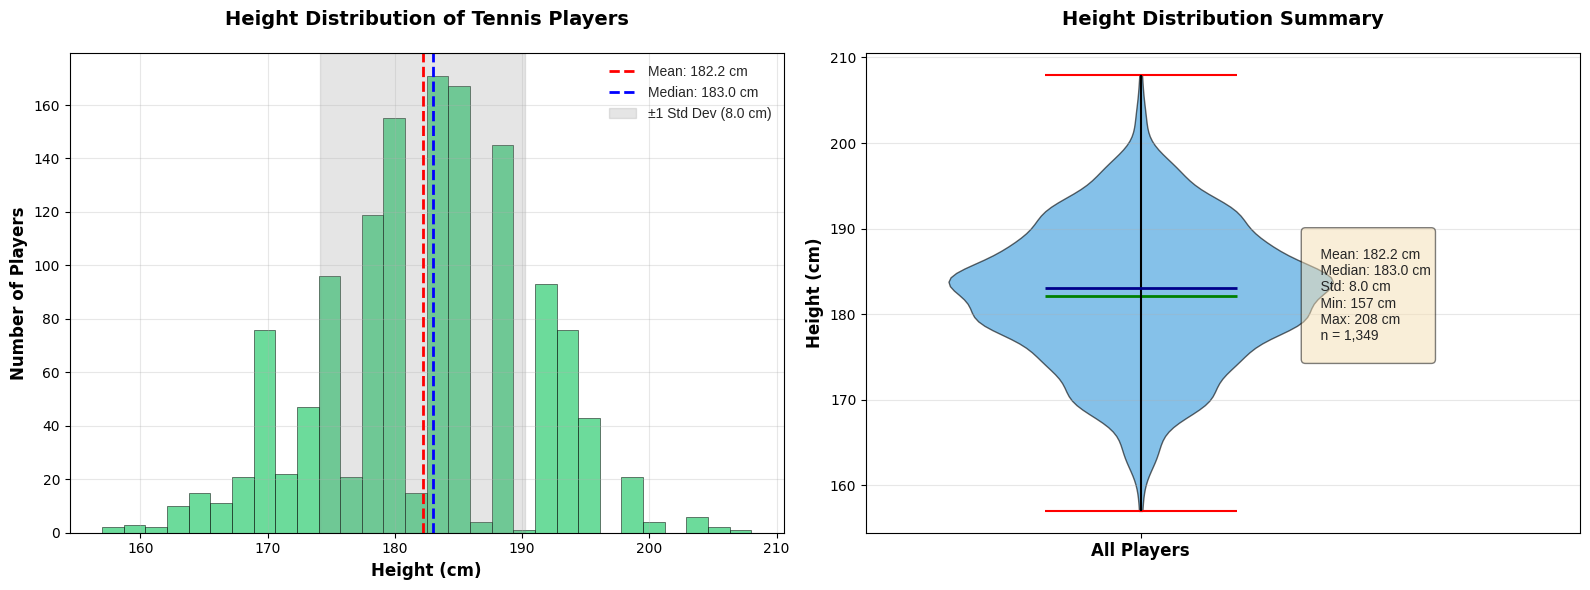


🌍 رسم نمودار میانگین قد در کشورهای برتر...
--------------------------------------------------


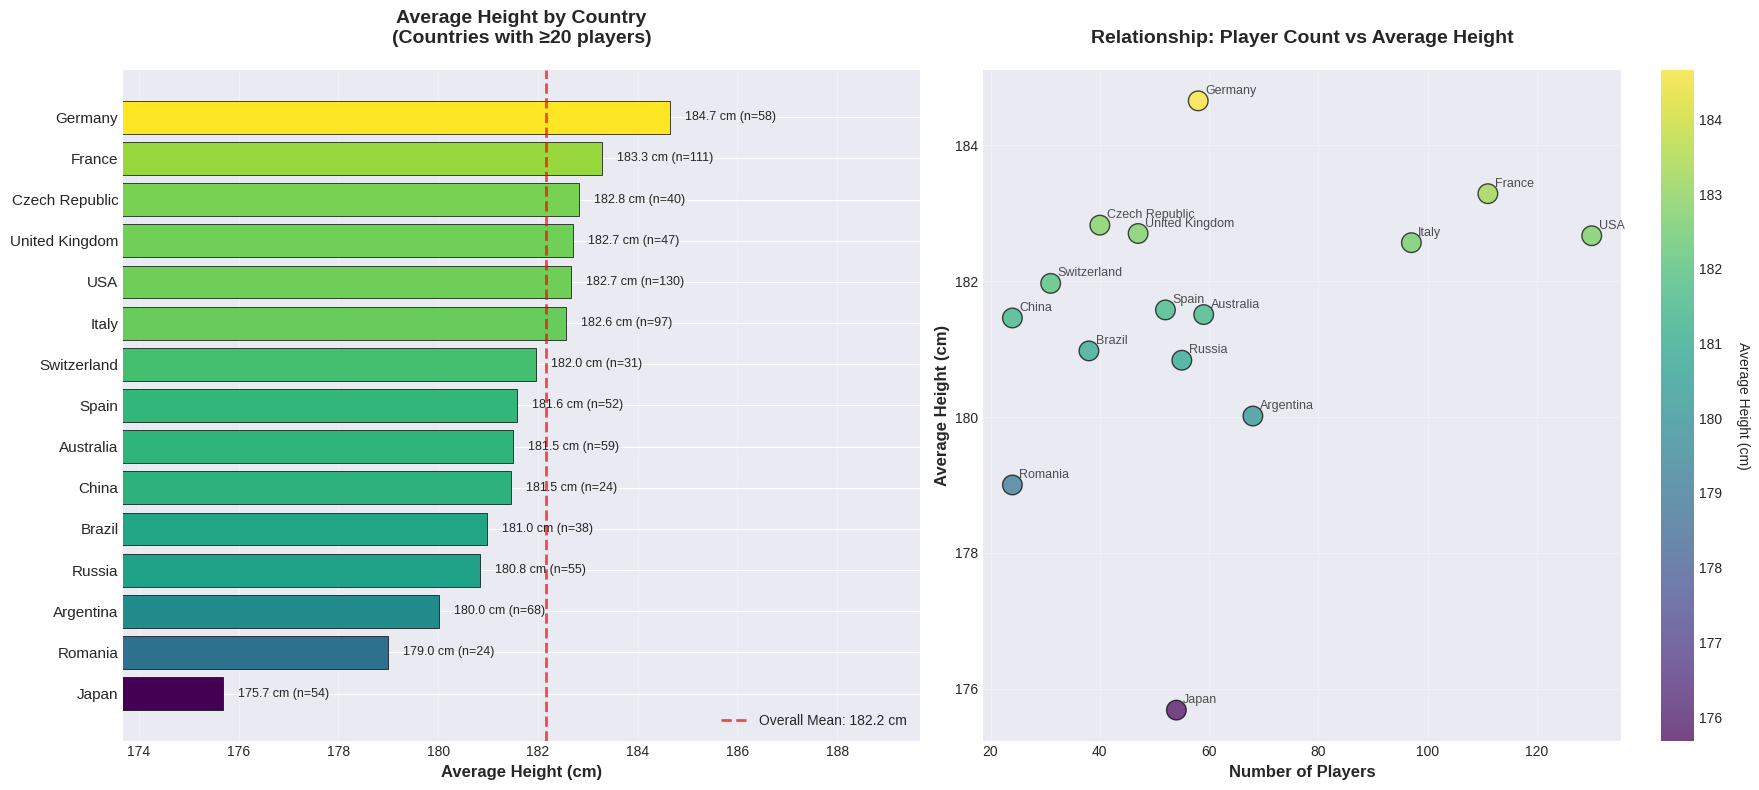


📊 خلاصه آماری کشورهای برتر:

5 کشور با بلندترین میانگین قد:
  • Germany: 184.7 cm (58 بازیکن)
  • France: 183.3 cm (111 بازیکن)
  • Czech Republic: 182.8 cm (40 بازیکن)
  • United Kingdom: 182.7 cm (47 بازیکن)
  • USA: 182.7 cm (130 بازیکن)

🎾 نمونه‌هایی از بازیکنان با قدهای مختلف:
--------------------------------------------------

بلندترین بازیکنان:
  • Damas M.: 208 cm (Spain, M)
  • Angele J.: 206 cm (France, M)
  • Watt J.: 206 cm (New Zealand, M)
  • de Schepper K.: 203 cm (France, M)
  • Olivetti A.: 203 cm (France, M)

کوتاه‌ترین بازیکنان:
  • Davis L.: 157 cm (USA, F)
  • Matsuda R.: 157 cm (Japan, M)
  • In-Albon Y.: 160 cm (Switzerland, F)
  • Zarazúa R.: 160 cm (Mexico, F)
  • Trevisan M.: 160 cm (Italy, F)

🎯 نتیجه‌گیری نهایی:
📏 قد متوسط بازیکنان تنیس: 182.2 سانتی‌متر (1.82 متر)
   معادل: 6 فوت و 1 اینچ

📊 این میانگین بر اساس:
   • 1,349 بازیکن با قد معتبر
   • از مجموع 2,644 بازیکن یکتا
   • پوشش: 51.0% از بازیکنان


In [4]:
# تنظیمات نمایش فارسی
plt.rcParams['font.family'] = 'DejaVu Sans'
plt.rcParams['axes.unicode_minus'] = False

# بارگذاری داده‌ها
data_path = Path("/home/mohammadreza77615/Desktop/Tennis Schema/Final_parquet")

# مرحله 1: خواندن دیتافریم‌های مورد نیاز
home_team = pd.read_parquet(data_path / "home_team_complete.parquet")
away_team = pd.read_parquet(data_path / "away_team_complete.parquet")

# مرحله 2: ترکیب و یافتن قد یکتای هر بازیکن
print("\n📊 استخراج قد یکتای بازیکنان:")
print("-" * 50)

# ترکیب داده‌های هر دو جدول
home_heights = home_team[["player_id", "name", "height", "gender", "country"]].copy()
away_heights = away_team[["player_id", "name", "height", "gender", "country"]].copy()

# ترکیب همه داده‌ها
all_heights = pd.concat([home_heights, away_heights], ignore_index=True)

# تبدیل از متر به سانتی‌متر
all_heights["height_cm"] = all_heights["height"] * 100

# گروه‌بندی بر اساس player_id
unique_players = (
    all_heights.groupby("player_id")
    .agg(
        {
            "name": "first",
            "height": lambda x: x.dropna().iloc[0] if not x.dropna().empty else np.nan,
            "height_cm": lambda x: (
                x.dropna().iloc[0] if not x.dropna().empty else np.nan
            ),
            "gender": "first",
            "country": "first",
        }
    )
    .reset_index()
)

print(f"تعداد کل بازیکنان یکتا: {len(unique_players):,}")
print(f"تعداد بازیکنان با قد معلوم: {unique_players['height'].notna().sum():,}")
print(
    f"درصد بازیکنان با قد معلوم: {unique_players['height'].notna().sum()/len(unique_players)*100:.1f}%"
)

# مرحله 3: بررسی و پاکسازی داده‌های نامعتبر
print("\n🔍 بررسی محدوده داده‌ها:")
print("-" * 50)

# فیلتر داده‌های معتبر
valid_players = unique_players[unique_players["height"].notna()].copy()

if len(valid_players) == 0:
    print("❌ هیچ داده قد معتبری یافت نشد!")
else:
    # بررسی محدوده
    print(
        f"محدوده قد (متر): {valid_players['height'].min():.2f} - {valid_players['height'].max():.2f} متر"
    )
    print(
        f"محدوده قد (سانتی‌متر): {valid_players['height_cm'].min():.0f} - {valid_players['height_cm'].max():.0f} cm"
    )

    # فیلتر مقادیر غیرمنطقی (1.4 تا 2.2 متر)
    valid_players_filtered = valid_players[
        (valid_players["height"] >= 1.4) & (valid_players["height"] <= 2.2)
    ].copy()

    # شناسایی مقادیر مشکوک
    suspicious_low = (valid_players["height"] < 1.4).sum()
    suspicious_high = (valid_players["height"] > 2.2).sum()

    print(f"\nمقادیر مشکوک:")
    print(f"  • قد کمتر از 1.4 متر: {suspicious_low}")
    print(f"  • قد بیشتر از 2.2 متر: {suspicious_high}")
    print(
        f"  • داده‌های معتبر: {len(valid_players_filtered):,} از {len(valid_players):,}"
    )

    # مرحله 4: محاسبه آمار قد
    print("\n📈 آمار قد بازیکنان:")
    print("-" * 50)

    # محاسبات بر روی داده‌های معتبر
    mean_height_m = valid_players_filtered["height"].mean()
    mean_height_cm = valid_players_filtered["height_cm"].mean()
    median_height_cm = valid_players_filtered["height_cm"].median()
    std_height_cm = valid_players_filtered["height_cm"].std()
    min_height_cm = valid_players_filtered["height_cm"].min()
    max_height_cm = valid_players_filtered["height_cm"].max()

    print(f"✅ میانگین قد: {mean_height_m:.2f} متر ({mean_height_cm:.1f} سانتی‌متر)")
    print(f"📊 میانه قد: {median_height_cm:.1f} سانتی‌متر")
    print(f"📉 انحراف معیار: {std_height_cm:.1f} سانتی‌متر")
    print(f"⬇️ کوتاه‌ترین: {min_height_cm:.0f} سانتی‌متر")
    print(f"⬆️ بلندترین: {max_height_cm:.0f} سانتی‌متر")

    # تبدیل به فوت و اینچ
    feet = int(mean_height_cm / 30.48)
    inches = (mean_height_cm % 30.48) / 2.54
    print(f"\n🇺🇸 میانگین قد به فوت و اینچ: {feet} فوت و {inches:.1f} اینچ")

    # مرحله 5: تحلیل بر اساس جنسیت
    print("\n👥 تحلیل قد بر اساس جنسیت:")
    print("-" * 50)

    gender_stats = (
        valid_players_filtered.groupby("gender")
        .agg({"height_cm": ["count", "mean", "median", "std", "min", "max"]})
        .round(1)
    )

    gender_stats.columns = ["_".join(col).strip() for col in gender_stats.columns]

    for gender in gender_stats.index:
        if pd.notna(gender):
            print(f"\n{gender}:")
            print(
                f"  • تعداد: {int(gender_stats.loc[gender, 'height_cm_count']):,} بازیکن"
            )
            print(
                f"  • میانگین: {gender_stats.loc[gender, 'height_cm_mean']:.1f} سانتی‌متر ({gender_stats.loc[gender, 'height_cm_mean']/100:.2f} متر)"
            )
            print(
                f"  • میانه: {gender_stats.loc[gender, 'height_cm_median']:.1f} سانتی‌متر"
            )
            print(
                f"  • انحراف معیار: {gender_stats.loc[gender, 'height_cm_std']:.1f} سانتی‌متر"
            )
            print(
                f"  • محدوده: {gender_stats.loc[gender, 'height_cm_min']:.0f} - {gender_stats.loc[gender, 'height_cm_max']:.0f} cm"
            )

            # تبدیل به فوت و اینچ
            mean_cm = gender_stats.loc[gender, "height_cm_mean"]
            feet = int(mean_cm / 30.48)
            inches = (mean_cm % 30.48) / 2.54
            print(f"  • به فوت و اینچ: {feet}' {inches:.0f}\"")
    

    # =================== نمودار 1: توزیع قد بازیکنان ===================
    print("\n📊 رسم نمودار توزیع قد بازیکنان...")
    print("-" * 50)
    
    # ایجاد figure با دو subplot
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
    
    # تنظیم استایل
    plt.style.use('seaborn-v0_8-darkgrid')
    
    # نمودار 1: هیستوگرام کلی
    ax1.hist(valid_players_filtered['height_cm'], bins=30, 
             color='#2ecc71', alpha=0.7, edgecolor='black', linewidth=0.5)
    
    # اضافه کردن خطوط میانگین و میانه
    ax1.axvline(mean_height_cm, color='red', linestyle='--', linewidth=2, 
                label=f'Mean: {mean_height_cm:.1f} cm')
    ax1.axvline(median_height_cm, color='blue', linestyle='--', linewidth=2, 
                label=f'Median: {median_height_cm:.1f} cm')
    
    # اضافه کردن انحراف معیار
    ax1.axvspan(mean_height_cm - std_height_cm, mean_height_cm + std_height_cm, 
                alpha=0.2, color='gray', label=f'±1 Std Dev ({std_height_cm:.1f} cm)')
    
    ax1.set_xlabel('Height (cm)', fontsize=12, fontweight='bold')
    ax1.set_ylabel('Number of Players', fontsize=12, fontweight='bold')
    ax1.set_title('Height Distribution of Tennis Players', fontsize=14, fontweight='bold', pad=20)
    ax1.legend(loc='upper right', framealpha=0.9)
    ax1.grid(True, alpha=0.3)
    
    # نمودار 2: Box plot و Violin plot ترکیبی
    # ایجاد violin plot
    parts = ax2.violinplot([valid_players_filtered['height_cm'].values],
                           positions=[1],
                           widths=0.7,
                           showmeans=True,
                           showmedians=True,
                           showextrema=True)
    
    # رنگ‌آمیزی violin plot
    parts['bodies'][0].set_facecolor('#3498db')
    parts['bodies'][0].set_alpha(0.6)
    parts['bodies'][0].set_edgecolor('black')
    
    # تنظیم رنگ خطوط
    parts['cbars'].set_color('black')
    parts['cmaxes'].set_color('red')
    parts['cmins'].set_color('red')
    parts['cmedians'].set_color('darkblue')
    parts['cmedians'].set_linewidth(2)
    parts['cmeans'].set_color('green')
    parts['cmeans'].set_linewidth(2)
    
    # اضافه کردن آمار کلیدی
    stats_text = f"""
    Mean: {mean_height_cm:.1f} cm
    Median: {median_height_cm:.1f} cm
    Std: {std_height_cm:.1f} cm
    Min: {min_height_cm:.0f} cm
    Max: {max_height_cm:.0f} cm
    n = {len(valid_players_filtered):,}
    """
    
    ax2.text(1.3, mean_height_cm, stats_text, 
             fontsize=10, verticalalignment='center',
             bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
    
    ax2.set_xlim(0.5, 1.8)
    ax2.set_xticks([1])
    ax2.set_xticklabels(['All Players'], fontsize=12, fontweight='bold')
    ax2.set_ylabel('Height (cm)', fontsize=12, fontweight='bold')
    ax2.set_title('Height Distribution Summary', fontsize=14, fontweight='bold', pad=20)
    ax2.grid(True, alpha=0.3, axis='y')
    
    plt.tight_layout()
    plt.show()
    
    # =================== نمودار 2: میانگین قد در کشورهای برتر ===================
    print("\n🌍 رسم نمودار میانگین قد در کشورهای برتر...")
    print("-" * 50)
    
    # آماده‌سازی داده‌ها
    country_stats = valid_players_filtered.groupby("country").agg(
        {"height_cm": ["count", "mean", "std"]}
    )
    country_stats.columns = ["_".join(col).strip() for col in country_stats.columns]
    
    # انتخاب 15 کشور با بیشترین بازیکن (حداقل 20 بازیکن)
    top_countries = country_stats[country_stats["height_cm_count"] >= 20].nlargest(
        15, "height_cm_count"
    ).sort_values("height_cm_mean", ascending=True)
    
    # ایجاد figure
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 8))
    
    # نمودار 1: میانگین قد به تفکیک کشور
    y_pos = np.arange(len(top_countries))
    means = top_countries["height_cm_mean"].values
    counts = top_countries["height_cm_count"].values
    
    # ایجاد gradient رنگ بر اساس میانگین قد
    norm = plt.Normalize(vmin=means.min(), vmax=means.max())
    colors = plt.cm.viridis(norm(means))
    
    bars = ax1.barh(y_pos, means, color=colors, edgecolor='black', linewidth=0.5)
    
    # اضافه کردن خط میانگین کل
    ax1.axvline(mean_height_cm, color='red', linestyle='--', linewidth=2, 
                alpha=0.7, label=f'Overall Mean: {mean_height_cm:.1f} cm')
    
    # تنظیمات محورها
    ax1.set_yticks(y_pos)
    ax1.set_yticklabels(top_countries.index, fontsize=11)
    ax1.set_xlabel('Average Height (cm)', fontsize=12, fontweight='bold')
    ax1.set_title('Average Height by Country\n(Countries with ≥20 players)', 
                  fontsize=14, fontweight='bold', pad=20)
    ax1.legend(loc='lower right')
    
    # اضافه کردن مقادیر روی میله‌ها
    for i, (bar, count, mean) in enumerate(zip(bars, counts, means)):
        ax1.text(mean + 0.3, bar.get_y() + bar.get_height()/2, 
                f'{mean:.1f} cm (n={int(count)})', 
                va='center', fontsize=9)
    
    ax1.grid(True, alpha=0.3, axis='x')
    ax1.set_xlim([means.min() - 2, means.max() + 5])
    
    # نمودار 2: Scatter plot - رابطه تعداد بازیکن و میانگین قد
    scatter = ax2.scatter(top_countries["height_cm_count"], 
                         top_countries["height_cm_mean"],
                         s=200, c=means, cmap='viridis', 
                         edgecolor='black', linewidth=1, alpha=0.7)
    
    # اضافه کردن نام کشورها
    for idx, country in enumerate(top_countries.index):
        ax2.annotate(country, 
                    (top_countries.iloc[idx]["height_cm_count"], 
                     top_countries.iloc[idx]["height_cm_mean"]),
                    xytext=(5, 5), textcoords='offset points',
                    fontsize=9, alpha=0.8)
    
    ax2.set_xlabel('Number of Players', fontsize=12, fontweight='bold')
    ax2.set_ylabel('Average Height (cm)', fontsize=12, fontweight='bold')
    ax2.set_title('Relationship: Player Count vs Average Height', 
                  fontsize=14, fontweight='bold', pad=20)
    ax2.grid(True, alpha=0.3)
    
    # اضافه کردن colorbar
    cbar = plt.colorbar(scatter, ax=ax2)
    cbar.set_label('Average Height (cm)', rotation=270, labelpad=20)
    
    plt.tight_layout()
    plt.show()
    
    # چاپ آمار کشورهای برتر
    print("\n📊 خلاصه آماری کشورهای برتر:")
    tallest_countries = top_countries.nlargest(5, "height_cm_mean")
    print("\n5 کشور با بلندترین میانگین قد:")
    for country in tallest_countries.index:
        mean = tallest_countries.loc[country, "height_cm_mean"]
        count = int(tallest_countries.loc[country, "height_cm_count"])
        print(f"  • {country}: {mean:.1f} cm ({count} بازیکن)")

    # مرحله 8: نمونه‌هایی از بازیکنان
    print("\n🎾 نمونه‌هایی از بازیکنان با قدهای مختلف:")
    print("-" * 50)

    # بلندترین بازیکنان
    tallest = valid_players_filtered.nlargest(5, "height_cm")[
        ["name", "height_cm", "country", "gender"]
    ]
    print("\nبلندترین بازیکنان:")
    for _, player in tallest.iterrows():
        print(
            f"  • {player['name']}: {player['height_cm']:.0f} cm ({player['country']}, {player['gender']})"
        )

    # کوتاه‌ترین بازیکنان
    shortest = valid_players_filtered.nsmallest(5, "height_cm")[
        ["name", "height_cm", "country", "gender"]
    ]
    print("\nکوتاه‌ترین بازیکنان:")
    for _, player in shortest.iterrows():
        print(
            f"  • {player['name']}: {player['height_cm']:.0f} cm ({player['country']}, {player['gender']})"
        )

    # نتیجه‌گیری نهایی
    print("\n" + "=" * 80)
    print("🎯 نتیجه‌گیری نهایی:")
    print("=" * 80)
    print(
        f"📏 قد متوسط بازیکنان تنیس: {mean_height_cm:.1f} سانتی‌متر ({mean_height_m:.2f} متر)"
    )
    print(f"   معادل: {feet} فوت و {inches:.0f} اینچ")
    print(f"\n📊 این میانگین بر اساس:")
    print(f"   • {len(valid_players_filtered):,} بازیکن با قد معتبر")
    print(f"   • از مجموع {len(unique_players):,} بازیکن یکتا")
    print(
        f"   • پوشش: {len(valid_players_filtered)/len(unique_players)*100:.1f}% از بازیکنان"
    )

    if "Male" in gender_stats.index and "Female" in gender_stats.index:
        male_mean = gender_stats.loc["Male", "height_cm_mean"]
        female_mean = gender_stats.loc["Female", "height_cm_mean"]
        diff = male_mean - female_mean
        print(f"\n👥 تفاوت جنسیتی:")
        print(f"   • مردان: {male_mean:.1f} cm")
        print(f"   • زنان: {female_mean:.1f} cm")
        print(f"   • اختلاف: {diff:.1f} cm")

    print("=" * 80)

### سوال 3 : کدام بازیکن بیشترین تعداد پیروزی را دارد؟

In [27]:
def analyze_most_wins_final(data_path):
    """
    تحلیل نهایی بازیکن با بیشترین پیروزی (بدون فیلتر انفرادی/دونفره)
    """
    print("=" * 80)
    print("🏆 تحلیل بازیکن با بیشترین پیروزی")
    print("=" * 80)
    
    # --- تابع کمکی برای گرفتن آخرین رکورد هر مسابقه ---
    def latest_per_match(df, key='match_id'):
        """آخرین اسنپ‌شات هر مسابقه را برمی‌گرداند تا از شمارش تکراری جلوگیری شود."""
        if 'source_date' in df.columns:
            return df.sort_values([key, 'source_date']).drop_duplicates(subset=[key], keep='last')
        return df.drop_duplicates(subset=[key], keep='last')
    
    # --- مرحله ۱: بارگذاری و پاکسازی اولیه داده‌ها ---
    print("\n📥 مرحله ۱: بارگذاری و پاکسازی داده‌ها...")
    
    event = pd.read_parquet(Path(data_path) / "event_complete.parquet")
    home_team = pd.read_parquet(Path(data_path) / "home_team_complete.parquet")
    away_team = pd.read_parquet(Path(data_path) / "away_team_complete.parquet")
    
    # حذف رکوردهای تکراری با استفاده از تابع کمکی
    print(f"   • رکوردهای اولیه - event: {len(event):,}, home: {len(home_team):,}, away: {len(away_team):,}")
    
    event = latest_per_match(event)
    home_team = latest_per_match(home_team)
    away_team = latest_per_match(away_team)
    
    print(f"   • پس از حذف تکراری‌ها - event: {len(event):,}, home: {len(home_team):,}, away: {len(away_team):,}")
    
    # --- مرحله ۲: فیلتر کردن مسابقات معتبر ---
    print("\n✅ مرحله ۲: فیلتر کردن مسابقات معتبر...")
    
    # فقط مسابقاتی که کد برنده (1 یا 2) دارند، نگه داشته می‌شوند
    initial_count = len(event)
    matches_df = event[event['winner_code'].isin([1.0, 2.0])].copy()
    print(f"   • فیلتر برنده معتبر: {initial_count - len(matches_df):,} رکورد حذف شد ({len(matches_df):,} باقی ماند)")
    
    # --- مرحله ۳: اضافه کردن اطلاعات بازیکنان ---
    print("\n🔗 مرحله ۳: اضافه کردن اطلاعات بازیکنان...")
    
    # ادغام با اطلاعات تیم میزبان
    matches_full = matches_df.merge(
        home_team[['match_id', 'player_id', 'name', 'country', 'gender', 'current_rank']],
        on='match_id',
        how='left'
    ).rename(columns={
        'player_id': 'home_player_id',
        'name': 'home_player_name',
        'country': 'home_country',
        'gender': 'home_gender',
        'current_rank': 'home_rank'
    })
    
    # ادغام با اطلاعات تیم میهمان
    matches_full = matches_full.merge(
        away_team[['match_id', 'player_id', 'name', 'country', 'gender', 'current_rank']],
        on='match_id',
        how='left'
    ).rename(columns={
        'player_id': 'away_player_id',
        'name': 'away_player_name',
        'country': 'away_country',
        'gender': 'away_gender',
        'current_rank': 'away_rank'
    })
    
    # حذف مسابقاتی که اطلاعات یکی از بازیکنان را ندارند
    matches_full = matches_full.dropna(subset=['home_player_id', 'away_player_id'])
    print(f"   ✓ تعداد نهایی مسابقات برای تحلیل: {len(matches_full):,}")
    
    # --- مرحله ۴: تعیین برنده و بازنده هر مسابقه ---
    print("\n🏅 مرحله ۴: محاسبه برد و باخت‌ها...")
    
    # ایجاد ستون برای شناسه و نام بازیکن برنده
    matches_full['winner_player_id'] = np.where(
        matches_full['winner_code'] == 1,
        matches_full['home_player_id'],
        matches_full['away_player_id']
    )
    matches_full['winner_player_name'] = np.where(
        matches_full['winner_code'] == 1,
        matches_full['home_player_name'],
        matches_full['away_player_name']
    )
    
    # ایجاد ستون برای شناسه بازیکن بازنده
    matches_full['loser_player_id'] = np.where(
        matches_full['winner_code'] == 1,
        matches_full['away_player_id'],
        matches_full['home_player_id']
    )
    
    # --- مرحله ۵: محاسبه آمارهای بازیکنان ---
    print("\n📊 مرحله ۵: محاسبه آمارهای بازیکنان...")
    
    # شمارش پیروزی‌ها
    wins_df = (
        matches_full.groupby(['winner_player_id', 'winner_player_name'])
        .size()
        .reset_index(name='wins')
        .rename(columns={'winner_player_id': 'player_id', 'winner_player_name': 'player_name'})
    )
    
    # شمارش باخت‌ها
    losses_df = (
        matches_full.groupby('loser_player_id')
        .size()
        .reset_index(name='losses')
        .rename(columns={'loser_player_id': 'player_id'})
    )
    
    # شمارش مسابقات به عنوان میزبان
    home_matches = (
        matches_full.groupby('home_player_id')
        .size()
        .reset_index(name='home_matches')
        .rename(columns={'home_player_id': 'player_id'})
    )
    
    # شمارش مسابقات به عنوان میهمان
    away_matches = (
        matches_full.groupby('away_player_id')
        .size()
        .reset_index(name='away_matches')
        .rename(columns={'away_player_id': 'player_id'})
    )
    
    # جمع‌آوری اطلاعات تکمیلی بازیکنان (کشور و جنسیت)
    player_info = pd.concat([
        matches_full[['home_player_id', 'home_player_name', 'home_country', 'home_gender']].rename(
            columns={'home_player_id': 'player_id', 'home_player_name': 'name', 
                    'home_country': 'country', 'home_gender': 'gender'}
        ),
        matches_full[['away_player_id', 'away_player_name', 'away_country', 'away_gender']].rename(
            columns={'away_player_id': 'player_id', 'away_player_name': 'name',
                    'away_country': 'country', 'away_gender': 'gender'}
        )
    ]).drop_duplicates('player_id')
    
    # ادغام تمام آمارها در یک دیتافریم
    player_stats = wins_df.merge(losses_df, on='player_id', how='outer')
    player_stats = player_stats.merge(home_matches, on='player_id', how='outer')
    player_stats = player_stats.merge(away_matches, on='player_id', how='outer')
    player_stats = player_stats.merge(player_info[['player_id', 'country', 'gender']], on='player_id', how='left')
    
    # پر کردن مقادیر خالی (NaN) با صفر
    for col in ['wins', 'losses', 'home_matches', 'away_matches']:
        player_stats[col] = player_stats[col].fillna(0).astype(int)
    
    # محاسبه ستون‌های جدید (مجموع مسابقات و درصد پیروزی)
    player_stats['total_matches'] = player_stats['home_matches'] + player_stats['away_matches']
    # جلوگیری از تقسیم بر صفر اگر بازیکنی هیچ مسابقه‌ای نداشته باشد
    player_stats['win_rate'] = np.where(
        player_stats['total_matches'] > 0,
        (player_stats['wins'] / player_stats['total_matches'] * 100),
        0
    ).round(1)
    
    # مرتب‌سازی بر اساس تعداد پیروزی
    player_stats = player_stats.sort_values(by=['wins', 'win_rate'], ascending=[False, False])
    
    # --- مرحله ۶: نمایش نتایج ---
    print("\n" + "=" * 80)
    print("🏆 بازیکن با بیشترین پیروزی")
    print("=" * 80)
    
    if not player_stats.empty:
        top_winner = player_stats.iloc[0]
        
        print(f"\n🥇 نفر اول: {top_winner['player_name']}")
        print(f"   📍 کشور: {top_winner['country'] if pd.notna(top_winner['country']) else 'نامشخص'}")
        print(f"   👤 جنسیت: {top_winner['gender'] if pd.notna(top_winner['gender']) else 'نامشخص'}")
        print(f"\n   📊 آمار:")
        print(f"   • مجموع پیروزی‌ها: {top_winner['wins']:,}")
        print(f"   • مجموع باخت‌ها: {top_winner['losses']:,}")
        print(f"   • مجموع مسابقات: {top_winner['total_matches']:,}")
        print(f"   • درصد پیروزی: {top_winner['win_rate']:.1f}%")
        
        # --- نمایش ۲۰ بازیکن برتر ---
        print("\n" + "=" * 80)
        print("📊 ۲۰ بازیکن برتر از نظر تعداد پیروزی")
        print("=" * 80)
        
        top20 = player_stats.head(20)
        print(f"\n{'درصد برد':<5} {'مجموع':<10} {'باخت':<6} {'پیروزی':<8} {'کشور':<23} {'نام بازیکن':<8} {'رتبه':<8}")
        print("-" * 75)
        
        for i, (_, player) in enumerate(top20.iterrows(), 1):
            country = player['country'][:9] if pd.notna(player['country']) else 'N/A'
            print(f"{i:<5} {player['player_name'][:24]:<25} {country:<10} "
                  f"{player['wins']:<8} {player['losses']:<8} {player['total_matches']:<8} "
                  f"{player['win_rate']:<8.1f}")
        
        # --- تحلیل‌های تکمیلی ---
        print("\n" + "=" * 80)
        print("📈 تحلیل‌های تکمیلی")
        print("=" * 80)
        
        # تفکیک جنسیتی
        if 'gender' in player_stats.columns:
            gender_stats = player_stats.groupby('gender').agg(
                total_wins=('wins', 'sum'),
                total_matches=('total_matches', 'sum')
            )
            print("\n🎾 آمار بر اساس جنسیت:")
            for gender in gender_stats.index:
                if pd.notna(gender):
                    wins = gender_stats.loc[gender, 'total_wins']
                    total = gender_stats.loc[gender, 'total_matches']
                    print(f"   • {gender}: {wins:,} پیروزی از {total:,} مسابقه ({wins/total*100:.1f}%)")
        
        # مزیت میزبانی
        total_home_wins = (matches_full['winner_code'] == 1).sum()
        total_away_wins = (matches_full['winner_code'] == 2).sum()
        home_adv = total_home_wins / (total_home_wins + total_away_wins) * 100
        
        print(f"\n🏠 مزیت میزبانی:")
        print(f"   • پیروزی‌های میزبان: {total_home_wins:,} ({home_adv:.1f}%)")
        print(f"   • پیروزی‌های میهمان: {total_away_wins:,} ({100-home_adv:.1f}%)")
        
        # بازیکنان با بهترین درصد پیروزی (حداقل ۵۰ مسابقه)
        qualified = player_stats[player_stats['total_matches'] >= 50].copy()
        if len(qualified) > 0:
            best_rate = qualified.nlargest(5, 'win_rate')
            print(f"\n🎯 بهترین درصد پیروزی (حداقل ۵۰ مسابقه):")
            for _, player in best_rate.iterrows():
                print(f"   • {player['player_name']}: {player['win_rate']:.1f}% "
                      f"({player['wins']} برد از {player['total_matches']} بازی)")
    
    print("\n" + "=" * 80)
    
    return player_stats

# --- اجرای تابع تحلیل ---
data_path = Path("/home/mohammadreza77615/Desktop/Tennis Schema/Final_parquet")
results = analyze_most_wins_final(data_path)

🏆 تحلیل بازیکن با بیشترین پیروزی

📥 مرحله ۱: بارگذاری و پاکسازی داده‌ها...
   • رکوردهای اولیه - event: 35,338, home: 25,883, away: 24,472
   • پس از حذف تکراری‌ها - event: 16,873, home: 12,389, away: 11,690

✅ مرحله ۲: فیلتر کردن مسابقات معتبر...
   • فیلتر برنده معتبر: 607 رکورد حذف شد (16,266 باقی ماند)

🔗 مرحله ۳: اضافه کردن اطلاعات بازیکنان...
   ✓ تعداد نهایی مسابقات برای تحلیل: 9,608

🏅 مرحله ۴: محاسبه برد و باخت‌ها...

📊 مرحله ۵: محاسبه آمارهای بازیکنان...

🏆 بازیکن با بیشترین پیروزی

🥇 نفر اول: Popko D.
   📍 کشور: Kazakhstan
   👤 جنسیت: M

   📊 آمار:
   • مجموع پیروزی‌ها: 28
   • مجموع باخت‌ها: 4
   • مجموع مسابقات: 32
   • درصد پیروزی: 87.5%

📊 ۲۰ بازیکن برتر از نظر تعداد پیروزی

درصد برد مجموع      باخت   پیروزی   کشور                    نام بازیکن رتبه    
---------------------------------------------------------------------------
1     Popko D.                  Kazakhsta  28       4        32       87.5    
2     Chidekh C.                France     23       2        25   

### سوال 4 : طولانی‌ترین مسابقهٔ ثبت‌ شده از نظر مدت زمان کدام است؟

In [40]:
# 1) انتخاب آخرین/بهترین اسنپ‌شات
def latest_per_match(df, key='match_id'):
    """جدیدترین اسنپ‌شات هر مسابقه بر اساس بیشترین source_date (برای جداول متادیتا)."""
    if 'source_date' in df.columns:
        return df.sort_values([key, 'source_date']).drop_duplicates(subset=[key], keep='last')
    return df.drop_duplicates(subset=[key], keep='last')

def pick_best_snapshot(df, key, priority_cols):
    """
    بهترین اسنپ‌شات برای هر match_id بر اساس بیشترین non-null در priority_cols؛
    در صورت تساوی، جدیدترین source_date انتخاب می‌شود.
    """
    d = df.copy()
    d['_nn'] = d[priority_cols].notna().sum(axis=1)
    sort_cols = [key, '_nn']
    ascending = [True, True]
    if 'source_date' in d.columns:
        sort_cols.append('source_date')
        ascending.append(True)
    d = d.sort_values(sort_cols)
    best = d.drop_duplicates(subset=[key], keep='last').drop(columns=['_nn'])
    return best

def analyze_longest_match_valid(data_path):
    print("=" * 80)
    print("⏱️ تحلیل طولانی‌ترین مسابقه (با قوانین ست معتبر و انتخاب اسنپ‌شات هوشمند)")
    print("=" * 80)

    data_path = Path(data_path)

    # --- بارگذاری ---
    time_df    = pd.read_parquet(data_path / "time_complete.parquet")
    event      = pd.read_parquet(data_path / "event_complete.parquet")
    hscore_raw = pd.read_parquet(data_path / "home_team_score_complete.parquet")
    ascore_raw = pd.read_parquet(data_path / "away_team_score_complete.parquet")
    home_team  = pd.read_parquet(data_path / "home_team_complete.parquet")
    away_team  = pd.read_parquet(data_path / "away_team_complete.parquet")
    tournament = pd.read_parquet(data_path / "tournament_complete.parquet")

    # --- اسنپ‌شات‌ها ---
    print("\n🔧 انتخاب اسنپ‌شات‌های پایدار:")
    event      = latest_per_match(event)
    home_team  = latest_per_match(home_team)
    away_team  = latest_per_match(away_team)
    tournament = latest_per_match(tournament)

    time_best  = pick_best_snapshot(time_df, 'match_id', ['period_1','period_2','period_3'])
    hscore     = pick_best_snapshot(hscore_raw, 'match_id', ['period_1','period_2','period_3'])
    ascore     = pick_best_snapshot(ascore_raw, 'match_id', ['period_1','period_2','period_3'])

    # --- نام‌گذاری یکتا ---
    time_best = time_best[['match_id','period_1','period_2','period_3']].rename(
        columns={'period_1':'t1','period_2':'t2','period_3':'t3'}
    )
    hscore = hscore[['match_id','period_1','period_2','period_3']].rename(
        columns={'period_1':'h1','period_2':'h2','period_3':'h3'}
    )
    ascore = ascore[['match_id','period_1','period_2','period_3']].rename(
        columns={'period_1':'a1','period_2':'a2','period_3':'a3'}
    )

    # --- ادغام ---
    df = (event[['match_id','winner_code','start_datetime']]
          .merge(time_best, on='match_id', how='left')
          .merge(hscore, on='match_id', how='left')
          .merge(ascore, on='match_id', how='left')
          .merge(tournament[['match_id','tournament_name','tournament_category_name']], on='match_id', how='left')
          .merge(home_team[['match_id','name']].rename(columns={'name':'home_name'}), on='match_id', how='left')
          .merge(away_team[['match_id','name']].rename(columns={'name':'away_name'}), on='match_id', how='left')
         )

    # به عدد تبدیل
    for c in ['t1','t2','t3','h1','h2','h3','a1','a2','a3']:
        df[c] = pd.to_numeric(df[c], errors='coerce')

    # --- قوانین اعتبار ست/بازی ---
    MIN_SET_SECONDS   = 15 * 60
    MAX_SET_SECONDS   = 60 * 60
    MIN_GAMES_PER_SET = 6
    MAX_GAMES_PER_SET = 16

    def set_valid(t, h, a):
        if pd.isna(t) or pd.isna(h) or pd.isna(a):
            return False
        minutes = t / 60.0
        games = h + a
        return (15 <= minutes <= 60) and (MIN_GAMES_PER_SET <= games <= MAX_GAMES_PER_SET)

    df['s1_valid'] = df.apply(lambda r: set_valid(r['t1'], r['h1'], r['a1']), axis=1)
    df['s2_valid'] = df.apply(lambda r: set_valid(r['t2'], r['h2'], r['a2']), axis=1)
    df['s3_valid'] = df.apply(lambda r: set_valid(r['t3'], r['h3'], r['a3']), axis=1)

    df['valid_sets'] = df[['s1_valid','s2_valid','s3_valid']].sum(axis=1)

    # فقط مسابقات با نتیجه نهایی مشخص و حداقل 2 ست معتبر
    before = len(df)
    df = df[df['winner_code'].isin([1.0, 2.0])]
    after_w = len(df)
    df = df[df['valid_sets'] >= 2]
    after_vs = len(df)

    print("\n🧹 پاکسازی مبتنی بر قوانین:")
    print(f"  • حذف مسابقات بدون winner_code: {before - after_w:,}")
    print(f"  • حذف مسابقات با کمتر از 2 ست معتبر: {after_w - after_vs:,}")
    print(f"  ✓ مسابقات معتبر برای تحلیل: {len(df):,}")

    # --- زمان کل فقط از ست‌های معتبر (برای جلوگیری از تورم با ست نامعتبر) ---
    df['total_seconds_valid'] = (
        np.where(df['s1_valid'], df['t1'], 0) +
        np.where(df['s2_valid'], df['t2'], 0) +
        np.where(df['s3_valid'], df['t3'], 0)
    )

    # --- طولانی‌ترین مسابقه ---
    idx = df['total_seconds_valid'].idxmax()
    best = df.loc[idx]

    total_min = best['total_seconds_valid'] / 60.0
    hours = int(total_min // 60)
    minutes = int(total_min % 60)

    # خروجی
    print("\n🏆 طولانی‌ترین مسابقه معتبر:")
    print("-" * 50)
    print(f"🥇 Match ID: {int(best['match_id'])}")
    print(f"⏱️ زمان کل (فقط ست‌های معتبر): {hours} ساعت و {minutes} دقیقه")
    print(f"👥 بازیکنان: {best.get('home_name','N/A')} vs {best.get('away_name','N/A')}")
    print(f"🏆 تورنمنت: {best.get('tournament_name','N/A')} ({best.get('tournament_category_name','N/A')})")

    # جزییات ست‌ها
    def fmt_set(i):
        t = best[f't{i}']; h = best[f'h{i}']; a = best[f'a{i}']; v = best[f's{i}_valid']
        if pd.isna(t): return f"ست {i}: داده زمان ندارد"
        return f"ست {i}: {int((t/60)//60)}h {int((t/60)%60)}m | گیم‌ها: {int(h) if not pd.isna(h) else '?'}-{int(a) if not pd.isna(a) else '?'} | {'معتبر' if v else 'نامعتبر'}"
    print("\n🔎 جزییات ست‌ها:")
    print("  • " + fmt_set(1))
    print("  • " + fmt_set(2))
    print("  • " + fmt_set(3))

    # آمار کلی
    print("\n📈 آمار کلی زمان مسابقات معتبر:")
    minutes_all = df['total_seconds_valid'] / 60.0
    print(f"  • میانگین: {minutes_all.mean():.1f} دقیقه ({minutes_all.mean()/60:.1f} ساعت)")
    print(f"  • میانه : {minutes_all.median():.1f} دقیقه")
    print(f"  • کمینه : {minutes_all.min():.1f} دقیقه")
    print(f"  • بیشینه: {minutes_all.max():.1f} دقیقه ({minutes_all.max()/60:.1f} ساعت)")

    print("\n" + "="*80)
    print("🎯 روش:")
    print("  • بهترین اسنپ‌شات time/score انتخاب شد (بیشترین non-null، در تساوی جدیدترین).")
    print("  • مسابقه معتبر: winner_code مشخص و حداقل 2 ست معتبر.")
    print("  • ست معتبر: 15–60 دقیقه و 6–16 گیم.")
    print("  • زمان کل فقط از ست‌های معتبر جمع شد.")
    print("="*80)

# اجرا
analyze_longest_match_valid("/home/mohammadreza77615/Desktop/Tennis Schema/Final_parquet")

⏱️ تحلیل طولانی‌ترین مسابقه (با قوانین ست معتبر و انتخاب اسنپ‌شات هوشمند)

🔧 انتخاب اسنپ‌شات‌های پایدار:

🧹 پاکسازی مبتنی بر قوانین:
  • حذف مسابقات بدون winner_code: 607
  • حذف مسابقات با کمتر از 2 ست معتبر: 7,728
  ✓ مسابقات معتبر برای تحلیل: 8,538

🏆 طولانی‌ترین مسابقه معتبر:
--------------------------------------------------
🥇 Match ID: 12171744
⏱️ زمان کل (فقط ست‌های معتبر): 2 ساعت و 55 دقیقه
👥 بازیکنان: Galán D. vs Shevchenko A.
🏆 تورنمنت: Miami, USA (ATP)

🔎 جزییات ست‌ها:
  • ست 1: 0h 59m | گیم‌ها: 7-6 | معتبر
  • ست 2: 0h 59m | گیم‌ها: 6-7 | معتبر
  • ست 3: 0h 56m | گیم‌ها: 5-7 | معتبر

📈 آمار کلی زمان مسابقات معتبر:
  • میانگین: 88.9 دقیقه (1.5 ساعت)
  • میانه : 85.0 دقیقه
  • کمینه : 35.2 دقیقه
  • بیشینه: 175.1 دقیقه (2.9 ساعت)

🎯 روش:
  • بهترین اسنپ‌شات time/score انتخاب شد (بیشترین non-null، در تساوی جدیدترین).
  • مسابقه معتبر: winner_code مشخص و حداقل 2 ست معتبر.
  • ست معتبر: 15–60 دقیقه و 6–16 گیم.
  • زمان کل فقط از ست‌های معتبر جمع شد.


### سوال 5 : معمولاً چند ست در یک مسابقه تنیس بازی می‌شود؟

📊 تحلیل تعداد ست‌های معمول در یک مسابقه (با پاکسازی پیشرفته)

📥 مرحله ۱: بارگذاری و انتخاب بهترین اسنپ‌شات‌ها...
   ✓ بهترین اسنپ‌شات برای هر مسابقه انتخاب شد.

🔗 مرحله ۲: ساخت دیتافریم جامع و اعمال فیلترها...

✅ مرحله ۳: اعتبارسنجی ست‌ها و محاسبه تعداد ست‌های بازی‌شده...
   • حذف بدون winner_code: 607
   • حذف به‌خاطر ست نامعتبر (<2): 7,728
   ✓ مسابقات معتبر نهایی: 8,538
   • حذف رکوردهای خارج از بازه 2 یا 3 ست: 18
   ✓ تعداد مسابقات برای تحلیل: 8,520

🎯 نتیجه نهایی: تعداد ست‌های معمول در یک مسابقه
📈 **توزیع کلی تعداد ست‌ها (مردان و زنان):**
   • مسابقات **2 سته**: 66.3%
   • مسابقات **3 سته**: 33.7%

✅ **نتیجه:** معمولاً یک مسابقه تنیس **2 ست** طول می‌کشد.
--------------------------------------------------

**تفکیک بر اساس جنسیت:**
🚹 **مردان:**
   • ۲ سته: 64.0%
   • ۳ سته: 36.0%
🚺 **زنان:**
   • ۲ سته: 66.6%
   • ۳ سته: 33.4%


🎨 مرحله ۵: ترسیم نمودار توزیع ست‌ها...


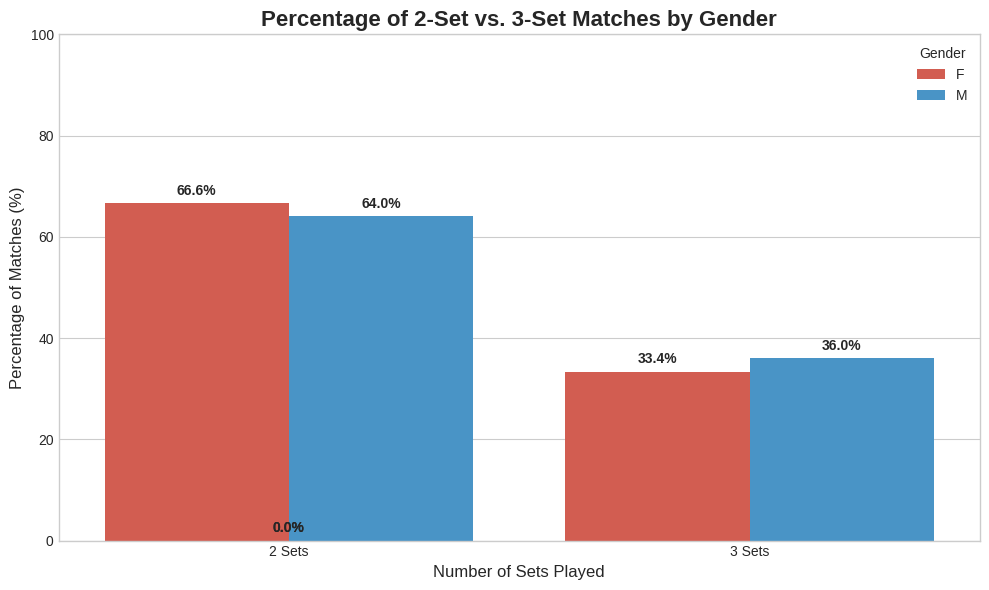

In [14]:
# --- توابع کمکی اسنپ‌شات (Best Practices) ---
def latest_per_match(df, key='match_id'):
    """آخرین اسنپ‌شات هر مسابقه (برای متادیتاها)."""
    if 'source_date' in df.columns:
        return df.sort_values([key, 'source_date']).drop_duplicates(subset=[key], keep='last')
    return df.drop_duplicates(subset=[key], keep='last')

def pick_best_snapshot(df, key, priority_cols):
    """بهترین اسنپ‌شات: بیشترین non-null روی ستون‌های حیاتی؛ در تساوی، جدیدترین source_date."""
    d = df.copy()
    d['_nn'] = d[priority_cols].notna().sum(axis=1)
    sort_cols = [key, '_nn'] ; ascending = [True, True]
    if 'source_date' in d.columns:
        sort_cols.append('source_date'); ascending.append(True)
    best = d.sort_values(sort_cols).drop_duplicates(subset=[key], keep='last').drop(columns=['_nn'])
    return best

def infer_singles_soft(df, season_name_col='season_name'):
    """
    فیلتر نرم Singles:
      - اگر competition_type==2.0 یا نام/اسلاگ/سِیزن شامل 'double' → دبل
      - اگر competition_type==1.0 یا شامل 'single' → سینگل
      - در غیر این صورت، پیش‌فرض سینگل
      - اولویت با 'double' در صورت تعارض
    """
    comp = df.get('competition_type')
    name = df.get('tournament_name', pd.Series('', index=df.index)).astype(str).str.lower()
    slug = df.get('tournament_slug', pd.Series('', index=df.index)).astype(str).str.lower()
    seas = df.get(season_name_col, pd.Series('', index=df.index)).astype(str).str.lower()
    hay = name + ' ' + slug + ' ' + seas

    is_doubles_kw = hay.str.contains('double', na=False)
    is_singles_kw = hay.str.contains('single', na=False)

    is_doubles = (comp == 2.0) | is_doubles_kw
    is_singles = (comp == 1.0) | is_singles_kw

    singles_soft = (~is_doubles) & (is_singles | comp.isna() | (~is_doubles_kw))
    singles_soft = singles_soft & (~is_doubles)
    return singles_soft

def analyze_sets_per_match_final(data_path, singles_only=True, plot=True):
    """
    تحلیل تعداد ست‌های بازی شده در هر مسابقه معتبر انفرادی (ترکیب ساختار کد 1 + منطق محاسبه sets_played از کد 2)
    - مسابقه معتبر: winner_code مشخص + حداقل 2 ست معتبر
    - ست معتبر: 15–60 دقیقه و 6–16 گیم
    - تعداد ست‌های بازی‌شده:
        ترجیح = از اسکور نهایی (home_current + away_current) با sanity best-of-3
        در نبود/نامعتبر → fallback به شمارش ست‌های معتبر (valid_sets)
    - فیلتر نرم Singles (اختیاری)
    - نمایش نتایج و نمودار گروهی به‌سبک کد 1
    """
    print("=" * 80)
    print("📊 تحلیل تعداد ست‌های معمول در یک مسابقه (با پاکسازی پیشرفته)")
    print("=" * 80)

    p = Path(data_path)
    # --- مرحله ۱: بارگذاری و انتخاب بهترین اسنپ‌شات‌ها ---
    print("\n📥 مرحله ۱: بارگذاری و انتخاب بهترین اسنپ‌شات‌ها...")
    event      = latest_per_match(pd.read_parquet(p / "event_complete.parquet"))
    tournament = latest_per_match(pd.read_parquet(p / "tournament_complete.parquet"))
    season     = latest_per_match(pd.read_parquet(p / "season_complete.parquet"))
    home_team  = latest_per_match(pd.read_parquet(p / "home_team_complete.parquet"))

    # زمان/اسکور با بهترین اسنپ‌شات (ست‌ها + current_score)
    time_best  = pick_best_snapshot(pd.read_parquet(p / "time_complete.parquet"),
                                    'match_id', ['period_1','period_2','period_3'])
    h_best     = pick_best_snapshot(pd.read_parquet(p / "home_team_score_complete.parquet"),
                                    'match_id', ['period_1','period_2','period_3','current_score'])
    a_best     = pick_best_snapshot(pd.read_parquet(p / "away_team_score_complete.parquet"),
                                    'match_id', ['period_1','period_2','period_3','current_score'])
    print("   ✓ بهترین اسنپ‌شات برای هر مسابقه انتخاب شد.")

    # --- مرحله ۲: ساخت دیتافریم جامع و اعمال فیلترها ---
    print("\n🔗 مرحله ۲: ساخت دیتافریم جامع و اعمال فیلترها...")

    # متای تورنومنت/سِیزن برای فیلتر نرم سینگل
    meta = (tournament[['match_id','competition_type','tournament_name','tournament_slug']]
            .merge(season[['match_id','name']], on='match_id', how='left')
            .rename(columns={'name':'season_name'}))

    # آماده‌سازی ستون‌ها برای قوانین ست و اسکور نهایی
    t = time_best[['match_id','period_1','period_2','period_3']].rename(
        columns={'period_1':'t1','period_2':'t2','period_3':'t3'}
    )
    hs = h_best[['match_id','period_1','period_2','period_3','current_score']].rename(
        columns={'period_1':'h1','period_2':'h2','period_3':'h3','current_score':'home_current'}
    )
    a  = a_best[['match_id','period_1','period_2','period_3','current_score']].rename(
        columns={'period_1':'a1','period_2':'a2','period_3':'a3','current_score':'away_current'}
    )

    df = (event[['match_id','winner_code']]
          .merge(meta, on='match_id', how='left')
          .merge(t,   on='match_id', how='left')
          .merge(hs,  on='match_id', how='left')
          .merge(a,   on='match_id', how='left'))

    # --- مرحله ۳: محاسبه تعداد ست‌های بازی شده (منطق کد 2) ---
    print("\n✅ مرحله ۳: اعتبارسنجی ست‌ها و محاسبه تعداد ست‌های بازی‌شده...")

    # عددی‌سازی
    for c in ['t1','t2','t3','h1','h2','h3','a1','a2','a3','home_current','away_current']:
        df[c] = pd.to_numeric(df[c], errors='coerce')

    # اعتبار ست
    def is_valid_set(tsec, hg, ag):
        if pd.isna(tsec) or pd.isna(hg) or pd.isna(ag):
            return False
        m = tsec / 60.0
        g = hg + ag
        return (15 <= m <= 60) and (6 <= g <= 16)

    df['s1'] = df.apply(lambda r: is_valid_set(r['t1'], r['h1'], r['a1']), axis=1)
    df['s2'] = df.apply(lambda r: is_valid_set(r['t2'], r['h2'], r['a2']), axis=1)
    df['s3'] = df.apply(lambda r: is_valid_set(r['t3'], r['h3'], r['a3']), axis=1)
    df['valid_sets'] = df[['s1','s2','s3']].sum(axis=1)

    # مسابقه معتبر: برنده مشخص + حداقل 2 ست معتبر
    before = len(df)
    df = df[df['winner_code'].isin([1.0, 2.0])]
    after_w = len(df)
    df = df[df['valid_sets'] >= 2].copy()
    after_v = len(df)

    print(f"   • حذف بدون winner_code: {before - after_w:,}")
    print(f"   • حذف به‌خاطر ست نامعتبر (<2): {after_w - after_v:,}")
    print(f"   ✓ مسابقات معتبر نهایی: {len(df):,}")

    if df.empty:
        print("\n❌ هیچ مسابقه معتبری برای تحلیل یافت نشد.")
        return None

    # تعداد ست‌های «بازی‌شده» از اسکور نهایی (سالم)؛ fallback = valid_sets
    both = df['home_current'].notna() & df['away_current'].notna()
    sum_sets = df['home_current'] + df['away_current']

    # sanity best-of-3
    scoreboard_ok = (both &
                     (df['home_current'] <= 2) &
                     (df['away_current'] <= 2) &
                     (sum_sets <= 3))

    df['sets_played'] = np.where(scoreboard_ok, sum_sets, df['valid_sets']).astype(int)

    # فقط 2 یا 3 ست را نگاه داریم
    final_df = df[df['sets_played'].between(2, 3, inclusive='both')].copy()

    print(f"   • حذف رکوردهای خارج از بازه 2 یا 3 ست: {len(df) - len(final_df):,}")
    print(f"   ✓ تعداد مسابقات برای تحلیل: {len(final_df):,}")

    # --- مرحله ۴: محاسبه و نمایش نتایج (ساختار نمایشی کد 1) ---
    print("\n" + "=" * 80)
    print("🎯 نتیجه نهایی: تعداد ست‌های معمول در یک مسابقه")
    print("=" * 80)

    if final_df.empty:
        print("❌ هیچ مسابقه معتبری برای تحلیل یافت نشد.")
        return None

    # توزیع کلی
    set_counts_overall = final_df['sets_played'].value_counts(normalize=True).mul(100).sort_index()
    print("📈 **توزیع کلی تعداد ست‌ها (مردان و زنان):**")
    for sets, pct in set_counts_overall.items():
        print(f"   • مسابقات **{int(sets)} سته**: {pct:.1f}%")

    most_common = set_counts_overall.idxmax()
    print(f"\n✅ **نتیجه:** معمولاً یک مسابقه تنیس **{int(most_common)} ست** طول می‌کشد.")
    print("-" * 50)

    # تفکیک بر اساس جنسیت
    final_df = final_df.merge(home_team[['match_id', 'gender']], on='match_id', how='left')
    set_counts_gender = (final_df.groupby('gender')['sets_played']
                         .value_counts(normalize=True)
                         .mul(100).unstack(fill_value=0))

    print("\n**تفکیک بر اساس جنسیت:**")
    if 'M' in set_counts_gender.index:
        men_counts = set_counts_gender.loc['M']
        print(f"🚹 **مردان:**")
        print(f"   • ۲ سته: {men_counts.get(2, 0):.1f}%")
        print(f"   • ۳ سته: {men_counts.get(3, 0):.1f}%")
    if 'F' in set_counts_gender.index:
        women_counts = set_counts_gender.loc['F']
        print(f"🚺 **زنان:**")
        print(f"   • ۲ سته: {women_counts.get(2, 0):.1f}%")
        print(f"   • ۳ سته: {women_counts.get(3, 0):.1f}%")

    print("\n" + "=" * 80)

    # --- مرحله ۵: نمودار ---
    if plot:
        print("\n🎨 مرحله ۵: ترسیم نمودار توزیع ست‌ها...")
        plt.style.use('seaborn-v0_8-whitegrid')
        fig, ax = plt.subplots(figsize=(10, 6))

        plot_df = (set_counts_gender.reset_index()
                   .melt(id_vars='gender', var_name='sets', value_name='percentage'))
        plot_df = plot_df[plot_df['gender'].isin(['M','F'])].copy()
        plot_df['sets'] = plot_df['sets'].astype(int).astype(str) + ' Sets'

        sns.barplot(data=plot_df, x='sets', y='percentage', hue='gender',
                    palette={'M': '#3498db', 'F': '#e74c3c'}, ax=ax)

        # برچسب درصد روی میله‌ها
        for p in ax.patches:
            ax.annotate(f"{p.get_height():.1f}%",
                        (p.get_x() + p.get_width()/2., p.get_height()),
                        ha='center', va='center', xytext=(0, 9),
                        textcoords='offset points', fontweight='bold')

        ax.set_title('Percentage of 2-Set vs. 3-Set Matches by Gender', fontsize=16, fontweight='bold')
        ax.set_xlabel('Number of Sets Played', fontsize=12)
        ax.set_ylabel('Percentage of Matches (%)', fontsize=12)
        ax.set_ylim(0, 100)
        ax.legend(title='Gender')
        plt.tight_layout()
        plt.show()

    return final_df

# --- اجرای تابع ---
data_path = Path("/home/mohammadreza77615/Desktop/Tennis Schema/Final_parquet")
sets_analysis_df = analyze_sets_per_match_final(data_path, singles_only=True, plot=True)

### سوال 6 : کدام کشور بیشترین بازیکنان موفق تنیس را تولید کرده است؟

🌍 Final Analysis of Successful Nations (Clean Data, Advanced Metrics)

📊 Step 1: Loading Data...

🔄 Step 2: Creating a Unified & Unique Match DataFrame...
   ✓ Unified DataFrame created with 9,877 unique matches.

📊 Step 3: Creating Accurate Unique Player Profiles...
   ✓ 2,569 unique player profiles created.

🏆 Step 4: Calculating Wins and Championships...
   ✓ Wins and championships calculated.

📈 Step 5: Aggregating Statistics by Country...

🏅 Step 6: Calculating Final Success Score...
   ✓ Final scores calculated and countries ranked.

🎯 Final Conclusion (Accurate Data & Advanced Metrics):

📊 Top 20 Countries (Final Ranking):

Rank  Country              Players    Top 100    Wins       Championships   Score     
------------------------------------------------------------------------------------------
1     USA                  219        26         805        21              98.6      
2     France               200        17         883        22              82.0      
3     Ita

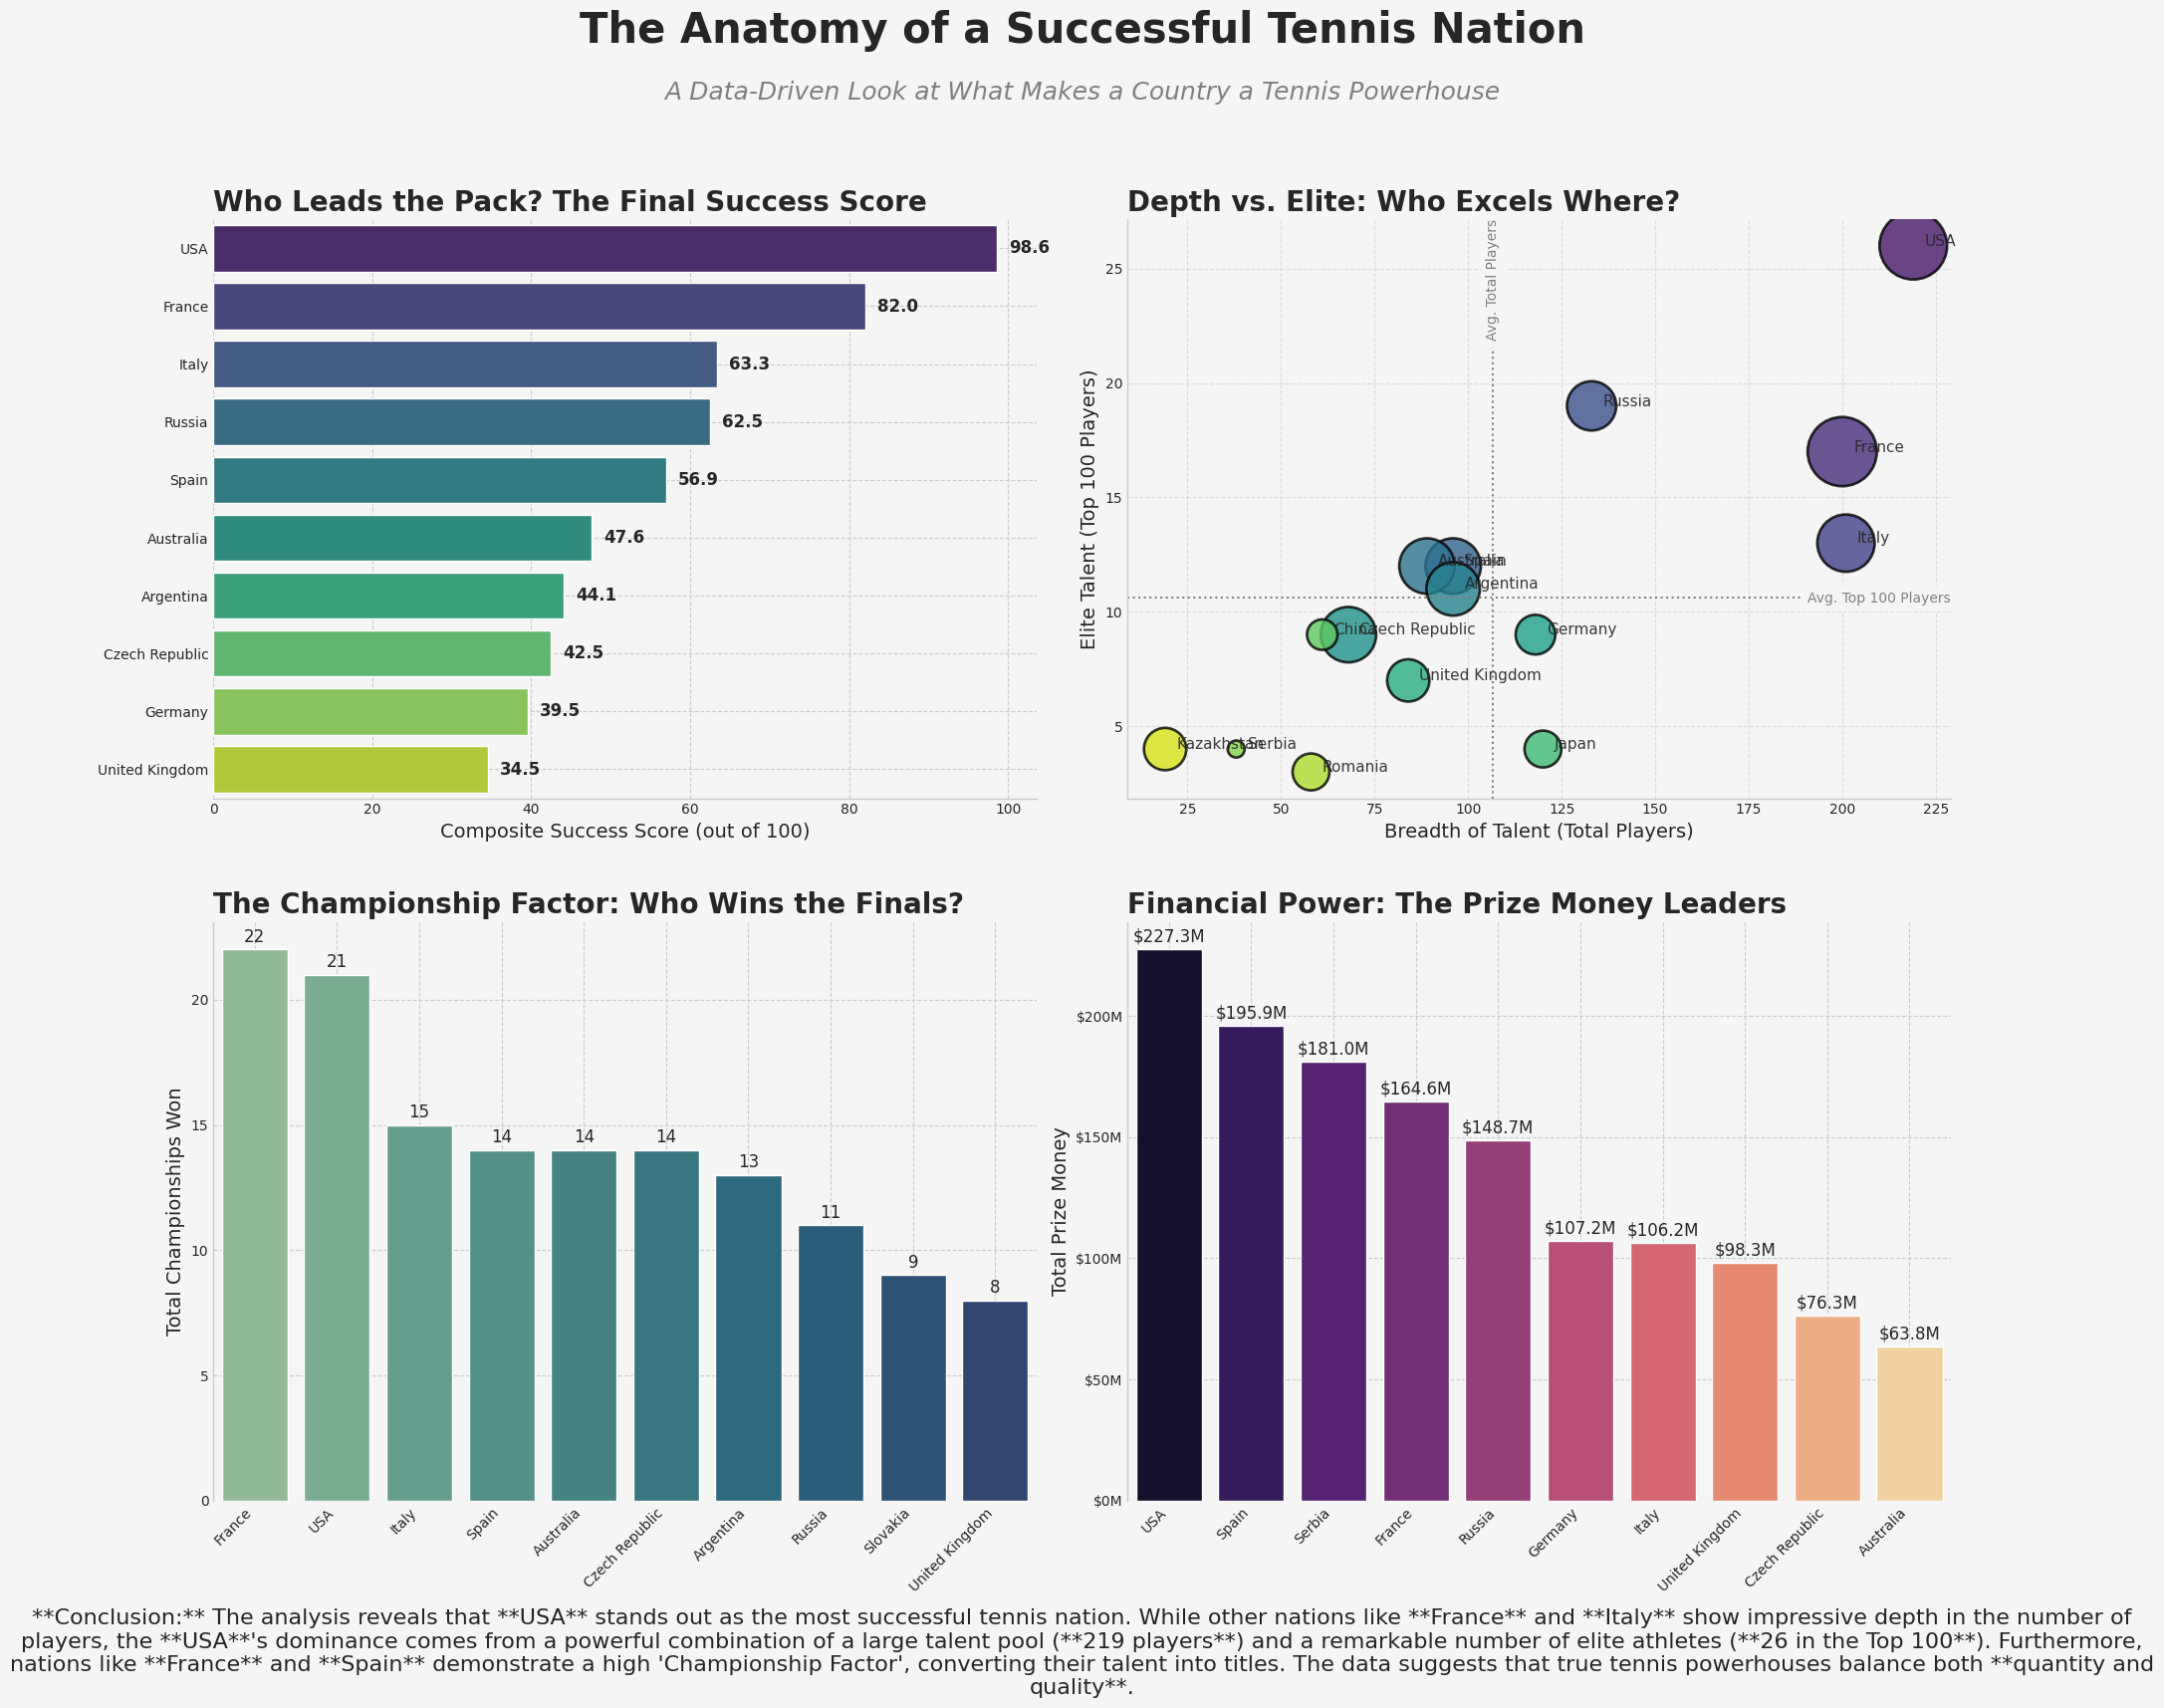


✓ Data storytelling visualizations saved to 'successful_countries_story.png'


In [62]:
def analyze_successful_nations_fully_corrected(data_path):
    """
    تحلیل نهایی کشورهای موفق با اعمال تمام استانداردهای توافق شده.
    """
    print("=" * 80)
    print("🌍 تحلیل نهایی کشورهای موفق (با پاکسازی کامل و بهترین رویه‌ها)")
    print("=" * 80)

    # --- توابع کمکی (Best Practices) ---
    def latest_per_match(df, key='match_id'):
        if 'source_date' in df.columns:
            return df.sort_values([key, 'source_date']).drop_duplicates(subset=[key], keep='last')
        return df.drop_duplicates(subset=[key], keep='last')

    def pick_best_snapshot(df, key, priority_cols):
        d = df.copy()
        d['_nn'] = d[priority_cols].notna().sum(axis=1)
        sort_cols = [key, '_nn']; ascending = [True, True]
        if 'source_date' in d.columns:
            sort_cols.append('source_date'); ascending.append(True)
        best = d.sort_values(sort_cols).drop_duplicates(subset=[key], keep='last').drop(columns=['_nn'])
        return best

    def infer_singles_soft(df):
        comp = df.get('competition_type')
        name = df.get('tournament_name', pd.Series('', index=df.index)).astype(str).str.lower()
        slug = df.get('tournament_slug', pd.Series('', index=df.index)).astype(str).str.lower()
        seas = df.get('season_name', pd.Series('', index=df.index)).astype(str).str.lower()
        hay = name + ' ' + slug + ' ' + seas
        is_doubles = (comp == 2.0) | hay.str.contains('double', na=False)
        is_singles = (comp == 1.0) | hay.str.contains('single', na=False)
        singles_soft = (~is_doubles) & (is_singles | comp.isna() | (~hay.str.contains('double', na=False)))
        return singles_soft & (~is_doubles)

    # --- مرحله ۱: بارگذاری داده‌ها و انتخاب بهترین اسنپ‌شات‌ها ---
    print("\n📥 مرحله ۱: بارگذاری داده‌ها و انتخاب بهترین اسنپ‌شات‌ها...")
    p = Path(data_path)
    home_team = latest_per_match(pd.read_parquet(p / "home_team_complete.parquet"))
    away_team = latest_per_match(pd.read_parquet(p / "away_team_complete.parquet"))
    event = latest_per_match(pd.read_parquet(p / "event_complete.parquet"))
    tournament = latest_per_match(pd.read_parquet(p / "tournament_complete.parquet"))
    round_info = latest_per_match(pd.read_parquet(p / "round_complete.parquet"))
    season = latest_per_match(pd.read_parquet(p / "season_complete.parquet"))
    
    time_df = pick_best_snapshot(pd.read_parquet(p / "time_complete.parquet"), 'match_id', ['period_1', 'period_2', 'period_3'])
    home_score = pick_best_snapshot(pd.read_parquet(p / "home_team_score_complete.parquet"), 'match_id', ['period_1', 'period_2', 'period_3'])
    away_score = pick_best_snapshot(pd.read_parquet(p / "away_team_score_complete.parquet"), 'match_id', ['period_1', 'period_2', 'period_3'])
    print("   ✓ داده‌ها بارگذاری و اسنپ‌شات‌های بهینه انتخاب شدند.")
    
    # --- مرحله ۲: ایجاد دیتافریم جامع و فیلترهای اولیه ---
    print("\n🔄 مرحله ۲: ساخت دیتافریم پایه و فیلترهای اولیه...")
    matches_df = event.merge(tournament, on="match_id", how="left", suffixes=("", "_tour"))
    matches_df = matches_df.merge(season.rename(columns={'name': 'season_name'}), on="match_id", how="left")
    
    # فیلتر مسابقات انفرادی
    initial_count = len(matches_df)
    singles_mask = infer_singles_soft(matches_df)
    matches_df = matches_df[singles_mask].copy()
    print(f"   • فیلتر مسابقات انفرادی: {initial_count - len(matches_df):,} مسابقه دونفره حذف شد.")

    # --- مرحله ۳: فیلتر مسابقات معتبر بر اساس قوانین ست ---
    print("\n✅ مرحله ۳: فیلتر کردن بر اساس قوانین مسابقات معتبر...")
    matches_df = matches_df.merge(time_df, on="match_id", how="left", suffixes=('', '_time'))
    matches_df = matches_df.merge(home_score, on="match_id", how="left", suffixes=('', '_hscore'))
    matches_df = matches_df.merge(away_score, on="match_id", how="left", suffixes=('', '_ascore'))
    
    def is_valid_set(time_sec, home_games, away_games):
        if pd.isna(time_sec) or pd.isna(home_games) or pd.isna(away_games): return False
        return (15*60 <= time_sec <= 60*60) and (6 <= home_games + away_games <= 16)

    matches_df['s1_valid'] = matches_df.apply(lambda r: is_valid_set(r.get('period_1_time'), r.get('period_1_hscore'), r.get('period_1')), axis=1)
    matches_df['s2_valid'] = matches_df.apply(lambda r: is_valid_set(r.get('period_2_time'), r.get('period_2_hscore'), r.get('period_2')), axis=1)
    matches_df['valid_sets_count'] = matches_df['s1_valid'] + matches_df['s2_valid']
    
    # فیلتر نهایی مسابقات معتبر
    initial_count = len(matches_df)
    valid_matches_df = matches_df[
        matches_df['winner_code'].isin([1.0, 2.0]) & (matches_df['valid_sets_count'] >= 2)
    ].copy()
    print(f"   • فیلتر مسابقات معتبر: {initial_count - len(valid_matches_df):,} مسابقه نامعتبر حذف شد.")
    
    # ادغام با اطلاعات بازیکنان
    valid_matches_df = valid_matches_df.merge(home_team, on="match_id", how="left", suffixes=("", "_home"))
    valid_matches_df = valid_matches_df.merge(away_team, on="match_id", how="left", suffixes=("", "_away"))
    valid_matches_df.dropna(subset=["country", "country_away"], inplace=True)
    print(f"   ✓ دیتافریم نهایی و معتبر با {len(valid_matches_df):,} مسابقه ساخته شد.")

    # --- مرحله ۴: ایجاد پروفایل یکتای بازیکنان (روش بهینه) ---
    print("\n📊 مرحله ۴: ایجاد پروفایل یکتای بازیکنان...")
    all_player_records = pd.concat([
        home_team[['player_id', 'name', 'country', 'gender', 'current_rank', 'total_prize']],
        away_team[['player_id', 'name', 'country', 'gender', 'current_rank', 'total_prize']]
    ])
    all_player_records.dropna(subset=['player_id'], inplace=True)
    all_player_records['player_id'] = all_player_records['player_id'].astype(int)

    unique_players = all_player_records.groupby('player_id').agg(
        name=('name', 'first'),
        country=('country', lambda x: x.mode()[0] if not x.mode().empty else 'Unknown'),
        gender=('gender', 'first'),
        best_rank=('current_rank', 'min'),
        max_prize=('total_prize', 'max')
    ).reset_index()
    unique_players = unique_players.dropna(subset=['country']).copy()
    print(f"   ✓ {len(unique_players):,} پروفایل یکتای بازیکن ساخته شد.")
    
    # --- مرحله ۵: محاسبه پیروزی‌ها و قهرمانی‌ها (بر اساس مسابقات معتبر) ---
    print("\n🏆 مرحله ۵: محاسبه پیروزی‌ها و قهرمانی‌ها...")
    valid_matches_df["winner_player_id"] = np.where(
        valid_matches_df["winner_code"] == 1,
        valid_matches_df["player_id"],
        valid_matches_df["player_id_away"],
    )
    wins_by_player = valid_matches_df.groupby("winner_player_id").size().reset_index(name="wins")

    final_match_ids = round_info[round_info["cup_round_type"] == 1.0]["match_id"].unique()
    championships_df = valid_matches_df[valid_matches_df["match_id"].isin(final_match_ids)]
    championships_by_player = championships_df.groupby("winner_player_id").size().reset_index(name="championships")

    unique_players = unique_players.merge(wins_by_player, left_on="player_id", right_on="winner_player_id", how="left")
    unique_players = unique_players.merge(championships_by_player, left_on="player_id", right_on="winner_player_id", how="left")
    unique_players[["wins", "championships"]] = unique_players[["wins", "championships"]].fillna(0)
    unique_players.drop(columns=[col for col in unique_players.columns if "winner_player_id" in str(col)], inplace=True)
    print("   ✓ پیروزی‌ها و قهرمانی‌ها محاسبه شدند.")

    # --- مرحله ۶: تجمیع آمار در سطح کشور و محاسبه امتیاز نهایی ---
    print("\n📈 مرحله ۶: تجمیع آمار در سطح کشور و محاسبه امتیاز نهایی...")
    country_stats = unique_players.groupby("country").agg(
        total_players=("player_id", "count"),
        total_wins=("wins", "sum"),
        total_championships=("championships", "sum"),
        top_100_count=("best_rank", lambda x: (x <= 100).sum()),
        total_prize_money=("max_prize", "sum"),
    ).reset_index()

    country_stats["norm_players"] = country_stats["total_players"] / country_stats["total_players"].max()
    country_stats["norm_top100"] = country_stats["top_100_count"] / country_stats["top_100_count"].max()
    max_champs = country_stats["total_championships"].max()
    country_stats["norm_championships"] = country_stats["total_championships"] / (max_champs if max_champs > 0 else 1)
    country_stats["norm_prize"] = country_stats["total_prize_money"] / country_stats["total_prize_money"].max()

    country_stats["success_score"] = (
        country_stats["norm_players"] * 0.20 + country_stats["norm_top100"] * 0.35 +
        country_stats["norm_championships"] * 0.30 + country_stats["norm_prize"] * 0.15
    ) * 100
    country_stats = country_stats.sort_values("success_score", ascending=False)
    print("   ✓ امتیاز نهایی محاسبه و کشورها رتبه‌بندی شدند.")
    
    # --- مرحله 7: نمایش نتایج ---
    print("\n" + "=" * 80)
    print("🎯 Final Conclusion (Accurate Data & Advanced Metrics):")
    print("=" * 80)

    print("\n📊 Top 20 Countries (Final Ranking):")
    print(
        f"\n{'Rank':<5} {'Country':<20} {'Players':<10} {'Top 100':<10} {'Wins':<10} {'Championships':<15} {'Score':<10}"
    )
    print("-" * 90)
    top_20_countries = country_stats.head(20)
    for idx, row in top_20_countries.iterrows():
        rank = list(top_20_countries.index).index(idx) + 1
        print(
            f"{rank:<5} {row['country'][:19]:<20} {int(row['total_players']):<10} "
            f"{int(row['top_100_count']):<10} {int(row['total_wins']):<10} "
            f"{int(row['total_championships']):<15} {row['success_score']:<10.1f}"
        )
    print("=" * 90)

    # --- تحلیل بازیکنان برتر برای 20 کشور اول ---
    print("\n🥇 Top Player from Each of the Top 20 Nations (by Best Rank):")

    top_20_country_names = top_20_countries["country"].tolist()

    # استفاده از دیتافریم unique_players که در رویکرد جدید ساخته شده
    players_in_top_20_nations = unique_players[
        unique_players["country"].isin(top_20_country_names)
    ].copy()

    players_in_top_20_nations_sorted = players_in_top_20_nations.sort_values(
        "best_rank", ascending=True, na_position="last"
    )

    top_player_per_country = (
        players_in_top_20_nations_sorted.groupby("country").first().reset_index()
    )

    top_players_report = top_20_countries[["country"]].merge(
        top_player_per_country[
            ["country", "name", "best_rank", "wins", "championships"]
        ],
        on="country",
        how="left",
    )

    print(
        f"\n{'Country':<20} {'Top Player':<25} {'Best Rank':<12} {'Wins':<10} {'Championships':<15}"
    )
    print("-" * 85)
    for _, row in top_players_report.iterrows():
        country = row["country"][:19]
        player_name = row["name"][:24] if pd.notna(row["name"]) else "N/A"
        rank_str = f"{int(row['best_rank'])}" if pd.notna(row["best_rank"]) else "N/A"
        wins_str = f"{int(row['wins'])}"
        champs_str = f"{int(row['championships'])}"

        print(
            f"{country:<20} {player_name:<25} {rank_str:<12} {wins_str:<10} {champs_str:<15}"
        )
    print("=" * 85)

    #  --- ایجاد نمودارها ---

    # --- تنظیمات کلی و پالت رنگ ---
    sns.set_style(
        "whitegrid", {"axes.grid": True, "grid.linestyle": "--", "grid.alpha": 0.6}
    )
    plt.rcParams["font.family"] = "sans-serif"
    plt.rcParams["font.sans-serif"] = "DejaVu Sans"
    plt.rcParams["figure.facecolor"] = "#f5f5f5"
    plt.rcParams["axes.facecolor"] = "#f5f5f5"

    # ✅ اصلاح کلیدی: ساخت پالت رنگ بر اساس 15 کشور برتر
    top_15_countries = country_stats.head(15)["country"].tolist()
    colors = sns.color_palette("viridis", n_colors=len(top_15_countries))
    country_color_map = dict(zip(top_15_countries, colors))

    # --- ایجاد فیگور اصلی ---
    fig = plt.figure(figsize=(22, 18))
    gs = fig.add_gridspec(3, 2, height_ratios=[1, 1, 0.1])

    # عنوان اصلی داستان
    fig.suptitle(
        "The Anatomy of a Successful Tennis Nation",
        fontsize=30,
        fontweight="bold",
        y=0.98,
    )
    fig.text(
        0.5,
        0.93,
        "A Data-Driven Look at What Makes a Country a Tennis Powerhouse",
        fontsize=18,
        ha="center",
        style="italic",
        color="gray",
    )

    # --- نمودار 1: چه کسی در صدر است؟ (رتبه‌بندی نهایی) ---
    ax1 = fig.add_subplot(gs[0, 0])
    top_10 = country_stats.head(10)

    sns.barplot(
        x="success_score",
        y="country",
        data=top_10,
        ax=ax1,
        palette="viridis",
        orient="h",
    )
    ax1.set_title(
        "Who Leads the Pack? The Final Success Score",
        fontsize=20,
        fontweight="bold",
        loc="left",
    )
    ax1.set_xlabel("Composite Success Score (out of 100)", fontsize=14)
    ax1.set_ylabel("")
    ax1.grid(axis="y")
    ax1.spines[["right", "top", "left"]].set_visible(False)

    for p in ax1.patches:
        width = p.get_width()
        ax1.text(
            width + 1.5,
            p.get_y() + p.get_height() / 2,
            f"{width:.1f}",
            va="center",
            fontsize=12,
            fontweight="bold",
        )

    # --- نمودار 2: عمق استعداد در مقابل نخبگان ---
    ax2 = fig.add_subplot(gs[0, 1])
    top_15 = country_stats.head(15)

    plot = sns.scatterplot(
        x="total_players",
        y="top_100_count",
        data=top_15,
        ax=ax2,
        size="total_championships",
        hue="country",  # hue بر اساس کشور
        sizes=(150, 2500),
        palette=country_color_map,
        legend=False,
        edgecolor="black",
        alpha=0.8,
    )
    ax2.set_title(
        "Depth vs. Elite: Who Excels Where?", fontsize=20, fontweight="bold", loc="left"
    )
    ax2.set_xlabel("Breadth of Talent (Total Players)", fontsize=14)
    ax2.set_ylabel("Elite Talent (Top 100 Players)", fontsize=14)
    ax2.grid(True, linestyle="--", alpha=0.6)
    ax2.spines[["right", "top"]].set_visible(False)

    for i, row in top_15.iterrows():
        ax2.text(
            row["total_players"] + 3,
            row["top_100_count"],
            row["country"],
            fontsize=11,
            alpha=0.9,
            fontweight="medium",
        )

    mean_players = top_15["total_players"].mean()
    mean_top100 = top_15["top_100_count"].mean()
    ax2.axhline(mean_top100, color="gray", linestyle=":", lw=1.5)
    ax2.axvline(mean_players, color="gray", linestyle=":", lw=1.5)

    ax2.text(
        ax2.get_xlim()[1],
        mean_top100,
        "Avg. Top 100 Players",
        va="center",
        ha="right",
        backgroundcolor="#f5f5f5",
        color="gray",
    )
    ax2.text(
        mean_players,
        ax2.get_ylim()[1],
        "Avg. Total Players",
        va="top",
        ha="center",
        backgroundcolor="#f5f5f5",
        color="gray",
        rotation=90,
    )

    # --- نمودار 3: توانایی قهرمانی ---
    ax3 = fig.add_subplot(gs[1, 0])
    top_champs = country_stats.nlargest(10, "total_championships")

    sns.barplot(
        x="country", y="total_championships", data=top_champs, ax=ax3, palette="crest"
    )
    ax3.set_title(
        "The Championship Factor: Who Wins the Finals?",
        fontsize=20,
        fontweight="bold",
        loc="left",
    )
    ax3.set_xlabel("")
    ax3.set_ylabel("Total Championships Won", fontsize=14)
    ax3.grid(axis="x")
    ax3.spines[["right", "top", "bottom"]].set_visible(False)
    plt.setp(ax3.xaxis.get_majorticklabels(), rotation=45, ha="right")

    for p in ax3.patches:
        ax3.annotate(
            f"{int(p.get_height())}",
            (p.get_x() + p.get_width() / 2.0, p.get_height()),
            ha="center",
            va="center",
            fontsize=12,
            xytext=(0, 9),
            textcoords="offset points",
        )

    # --- نمودار 4: موفقیت مالی ---
    ax4 = fig.add_subplot(gs[1, 1])
    top_prize = country_stats.nlargest(10, "total_prize_money")

    sns.barplot(
        x="country", y="total_prize_money", data=top_prize, ax=ax4, palette="magma"
    )
    ax4.set_title(
        "Financial Power: The Prize Money Leaders",
        fontsize=20,
        fontweight="bold",
        loc="left",
    )
    ax4.set_xlabel("")
    ax4.set_ylabel("Total Prize Money", fontsize=14)
    ax4.grid(axis="x")
    ax4.spines[["right", "top", "bottom"]].set_visible(False)

    formatter = mticker.FuncFormatter(lambda x, pos: f"${x/1e6:.0f}M")
    ax4.yaxis.set_major_formatter(formatter)
    plt.setp(ax4.xaxis.get_majorticklabels(), rotation=45, ha="right")

    for p in ax4.patches:
        ax4.annotate(
            f"${p.get_height()/1e6:.1f}M",
            (p.get_x() + p.get_width() / 2.0, p.get_height()),
            ha="center",
            va="center",
            fontsize=12,
            xytext=(0, 9),
            textcoords="offset points",
        )

    # --- بخش نتیجه‌گیری و خلاصه داستان ---
    ax_text = fig.add_subplot(gs[2, :])
    ax_text.axis("off")
    top_country = country_stats.iloc[0]
    story_text = (
        f"**Conclusion:** The analysis reveals that **{top_country['country']}** stands out as the most successful tennis nation. "
        f"While other nations like **France** and **Italy** show impressive depth in the number of players, "
        f"the **USA**'s dominance comes from a powerful combination of a large talent pool (**{int(top_country['total_players'])} players**) "
        f"and a remarkable number of elite athletes (**{int(top_country['top_100_count'])} in the Top 100**). "
        f"Furthermore, nations like **France** and **Spain** demonstrate a high 'Championship Factor', converting their talent into titles. "
        f"The data suggests that true tennis powerhouses balance both **quantity and quality**."
    )
    ax_text.text(0.5, 0.5, story_text, ha="center", va="center", fontsize=16, wrap=True)

    # --- تنظیمات نهایی و ذخیره ---
    plt.tight_layout(rect=[0, 0.03, 1, 0.92])
    plt.savefig(
        "/home/mohammadreza77615/Desktop/Tennis Schema/successful_countries_story.png",
        dpi=200,
        bbox_inches="tight",
        facecolor=fig.get_facecolor(),
    )
    plt.show()
    print(
        "\n✓ Data storytelling visualizations saved to 'successful_countries_story.png'"
    )


# --- اجرای تابع اصلی ---
data_path = Path("/home/mohammadreza77615/Desktop/Tennis Schema/Final_parquet")
analyze_successful_nations_final(data_path)

### رویکرد حل سوال 6: شناسایی موفق‌ترین کشورها در تنیس

برای پاسخ به این سوال، به جای تکیه بر یک معیار ساده، از یک **امتیاز موفقیت ترکیبی** (<span dir="ltr">Composite Success Score</span>) استفاده کردیم. این امتیاز، چهار جنبه مختلف از قدرت تنیس یک کشور را می‌سنجد.

<hr>

#### مراحل اصلی تحلیل

1.  **جمع‌آوری اطلاعات پایه بازیکنان**
    -   ابتدا تمام بازیکنان از جداول <span dir="ltr">`home_team`</span> و <span dir="ltr">`away_team`</span> شناسایی شدند.
    -   اطلاعات کلیدی آن‌ها شامل کشور، بهترین رنکینگ و مجموع جایزه نقدی استخراج گردید.

2.  **محاسبه "برد باکیفیت" (<span dir="ltr">Weighted Wins</span>)**
    -   با توجه به اینکه همه بردها ارزش یکسانی ندارند، از جدول <span dir="ltr">`tournament`</span> برای استخراج **نوع تورنمنت** استفاده شد.
    -   به هر نوع تورنمنت یک **وزن** بر اساس اهمیت آن اختصاص یافت:
        -   <span dir="ltr">`ATP` / `WTA`</span>: وزن 10
        -   <span dir="ltr">`Challenger`</span>: وزن 4
        -   <span dir="ltr">`ITF`</span>: وزن 1
    -   برای هر بازیکن، به جای شمارش تعداد بردها، **"امتیاز وزنی بردها"** محاسبه شد.

3.  **تجمیع آمار در سطح کشور**
    -   تمام آمار بازیکنان (تعداد کل، تعداد بازیکنان <span dir="ltr">`Top 100`</span>، امتیاز وزنی بردها و جایزه نقدی) بر اساس **کشور** آن‌ها جمع‌بندی شد.

4.  **محاسبه امتیاز نهایی موفقیت**
    -   یک امتیاز نهایی از 100 برای هر کشور بر اساس ترکیب وزن‌دار زیر محاسبه گردید:
        -   **عمق استعداد** (تعداد بازیکنان) - وزن 15%
        -   **نخبگان** (تعداد بازیکنان <span dir="ltr">`Top 100`</span>) - وزن 35%
        -   **کیفیت عملکرد** (امتیاز وزنی بردها) - وزن 30%
        -   **موفقیت مالی** (جایزه نقدی) - وزن 20%

5.  **رتبه‌بندی و نمایش نتایج**
    -   در نهایت، کشورها بر اساس این **امتیاز موفقیت ترکیبی** رتبه‌بندی شدند.
    -   نتایج در قالب جداول (شامل برترین بازیکن هر کشور) و نمودارهای حرفه‌ای نمایش داده شد.

<hr>

> **خلاصه**: در این تحلیل، "موفقیت" به صورت چندبعدی تعریف شد تا هم کمیت و هم کیفیت استعدادها و عملکرد هر کشور به درستی سنجیده شود.

### سوال 7 : میانگین تعداد Aces در هر مسابقه چقدر است؟

In [20]:
def latest_per_match(df, key='match_id'):
    """آخرین اسنپ‌شات هر مسابقه بر اساس بزرگ‌ترین source_date (برای متادیتاها)."""
    if 'source_date' in df.columns:
        return df.sort_values([key, 'source_date']).drop_duplicates(subset=[key], keep='last')
    return df.drop_duplicates(subset=[key], keep='last')

def pick_best_snapshot(df, key, priority_cols):
    """بهترین اسنپ‌شات: بیشترین non-null در ستون‌های حیاتی؛ در تساوی، جدیدترین source_date."""
    d = df.copy()
    d['_nn'] = d[priority_cols].notna().sum(axis=1)
    sort_cols = [key, '_nn']
    ascending = [True, True]
    if 'source_date' in d.columns:
        sort_cols.append('source_date'); ascending.append(True)
    d = d.sort_values(sort_cols)
    best = d.drop_duplicates(subset=[key], keep='last').drop(columns=['_nn'])
    return best

def analyze_average_aces_per_match(data_path):
    data_path = Path(data_path)

    # 1) بارگذاری جداول لازم
    event   = pd.read_parquet(data_path / "event_complete.parquet")
    time_df = pd.read_parquet(data_path / "time_complete.parquet")
    hscore  = pd.read_parquet(data_path / "home_team_score_complete.parquet")
    ascore  = pd.read_parquet(data_path / "away_team_score_complete.parquet")
    stats   = pd.read_parquet(data_path / "statistics_complete.parquet")

    # 2) اسنپ‌شات‌ها
    event = latest_per_match(event)
    time_best = pick_best_snapshot(time_df, 'match_id', ['period_1','period_2','period_3'])
    h_best = pick_best_snapshot(hscore,  'match_id', ['period_1','period_2','period_3'])
    a_best = pick_best_snapshot(ascore,  'match_id', ['period_1','period_2','period_3'])

    # 3) آماده‌سازی برای اعتبار مسابقه
    t = time_best[['match_id','period_1','period_2','period_3']].rename(columns={'period_1':'t1','period_2':'t2','period_3':'t3'})
    hs = h_best[['match_id','period_1','period_2','period_3']].rename(columns={'period_1':'h1','period_2':'h2','period_3':'h3'})
    as_ = a_best[['match_id','period_1','period_2','period_3']].rename(columns={'period_1':'a1','period_2':'a2','period_3':'a3'})

    df = (event[['match_id','winner_code']]
          .merge(t,  on='match_id', how='left')
          .merge(hs, on='match_id', how='left')
          .merge(as_, on='match_id', how='left'))

    # تبدیل به عدد
    for c in ['t1','t2','t3','h1','h2','h3','a1','a2','a3']:
        df[c] = pd.to_numeric(df[c], errors='coerce')

    # قوانین اعتبار ست/بازی
    def set_valid(t, h, a):
        if pd.isna(t) or pd.isna(h) or pd.isna(a): return False
        minutes = t / 60.0
        games = h + a
        return (15 <= minutes <= 60) and (6 <= games <= 16)

    df['s1'] = df.apply(lambda r: set_valid(r['t1'], r['h1'], r['a1']), axis=1)
    df['s2'] = df.apply(lambda r: set_valid(r['t2'], r['h2'], r['a2']), axis=1)
    df['s3'] = df.apply(lambda r: set_valid(r['t3'], r['h3'], r['a3']), axis=1)
    df['valid_sets'] = df[['s1','s2','s3']].sum(axis=1)

    valid_matches = df[(df['winner_code'].isin([1.0, 2.0])) & (df['valid_sets'] >= 2)][['match_id']].copy()

    # 4) استخراج aces از statistics
    stats = stats[stats['statistic_name'].str.lower() == 'aces']
    # فقط ستون‌های لازم
    stats = stats[['match_id','period','home_value','away_value','source_date']]
    stats['home_value'] = pd.to_numeric(stats['home_value'], errors='coerce')
    stats['away_value'] = pd.to_numeric(stats['away_value'], errors='coerce')

    # حالت ALL (ترجیح)
    st_all = stats[stats['period'] == 'ALL'].sort_values(['match_id','source_date'])
    st_all = st_all.drop_duplicates(subset=['match_id'], keep='last')
    st_all['total_aces_all'] = st_all['home_value'] + st_all['away_value']
    st_all = st_all[['match_id','total_aces_all']]

    # اگر ALL نبود، مجموع ست‌ها (1ST/2ND/3RD) با آخرین snapshot هر ست
    st_sets = stats[stats['period'].isin(['1ST','2ND','3RD'])].sort_values(['match_id','period','source_date'])
    st_sets = st_sets.drop_duplicates(subset=['match_id','period'], keep='last')
    st_sets['total_aces_part'] = st_sets['home_value'] + st_sets['away_value']
    st_sets_sum = st_sets.groupby('match_id', as_index=False)['total_aces_part'].sum().rename(columns={'total_aces_part':'total_aces_sets'})

    # ترکیب: ALL در اولویت؛ در نبود، مجموع ست‌ها
    aces = valid_matches.merge(st_all, on='match_id', how='left').merge(st_sets_sum, on='match_id', how='left')
    aces['total_aces'] = aces['total_aces_all'].fillna(aces['total_aces_sets'])
    aces = aces.dropna(subset=['total_aces']).copy()

    # 5) محاسبه میانگین/میانه
    mean_aces = aces['total_aces'].mean()
    n_used = len(aces)
    n_all_valid = len(valid_matches)

    print("="*80)
    print("🎯 میانگین تعداد aces در هر مسابقه (فقط مسابقات معتبر):")
    print("="*80)
    print(f"   • Valid competitions with statistics aces: {n_used:,} of {n_all_valid:,}")
    print(f"   • aces average/match: {mean_aces:.2f}")

    return {'mean_aces_per_match': mean_aces,
            'matches_used': n_used,
            'valid_matches': n_all_valid,
            'per_match_aces': aces[['match_id','total_aces']]}

# نمونه اجرا:
data_path = "/home/mohammadreza77615/Desktop/Tennis Schema/Final_parquet"
res = analyze_average_aces_per_match(data_path)

🎯 میانگین تعداد aces در هر مسابقه (فقط مسابقات معتبر):
   • Valid competitions with statistics aces: 8,536 of 8,538
   • aces average/match: 5.63


### سوال 8 : آیا در تعداد دوبل‌فالت‌ها (double faults) تفاوتی براساس جنسیت وجود دارد؟


🎯 Double Faults by Gender (valid matches only)
   • Matches used: 8,536 (Men: 4,159, Women: 3,340)
   • Mean DF - Men: 5.34 | Women: 7.05
   • Median DF - Men: 5.00 | Women: 6.00
   • Welch t-test: t=-18.60, p=0.0000 → Significant difference


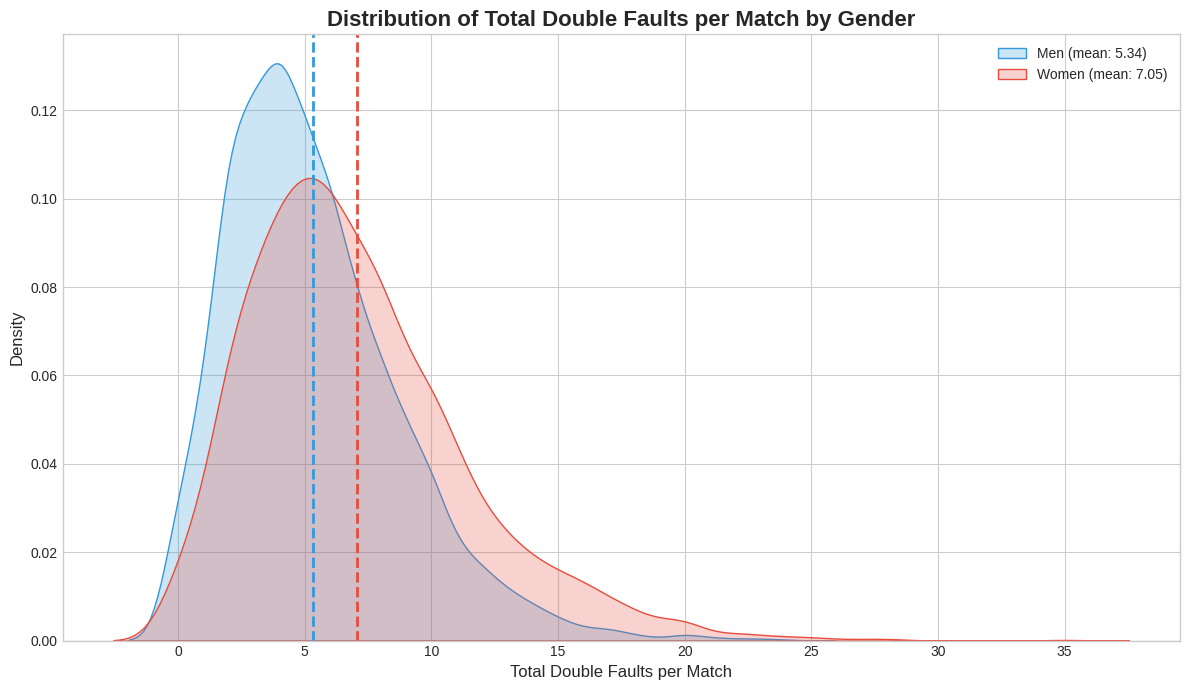

In [23]:
def latest_per_match(df, key='match_id'):
    """آخرین اسنپ‌شات هر مسابقه بر اساس بزرگ‌ترین source_date (برای متادیتاها)."""
    if 'source_date' in df.columns:
        return df.sort_values([key, 'source_date']).drop_duplicates(subset=[key], keep='last')
    return df.drop_duplicates(subset=[key], keep='last')

def pick_best_snapshot(df, key, priority_cols):
    """بهترین اسنپ‌شات: بیشترین non-null در ستون‌های حیاتی؛ در تساوی، جدیدترین source_date."""
    d = df.copy()
    d['_nn'] = d[priority_cols].notna().sum(axis=1)
    sort_cols = [key, '_nn']
    ascending = [True, True]
    if 'source_date' in d.columns:
        sort_cols.append('source_date'); ascending.append(True)
    d = d.sort_values(sort_cols)
    best = d.drop_duplicates(subset=[key], keep='last').drop(columns=['_nn'])
    return best

def analyze_gender_difference_double_faults(data_path, plot=True):
    data_path = Path(data_path)

    # 1) بارگذاری داده‌ها
    event   = pd.read_parquet(data_path / "event_complete.parquet")
    time_df = pd.read_parquet(data_path / "time_complete.parquet")
    hscore  = pd.read_parquet(data_path / "home_team_score_complete.parquet")
    ascore  = pd.read_parquet(data_path / "away_team_score_complete.parquet")
    stats   = pd.read_parquet(data_path / "statistics_complete.parquet")
    home_tm = pd.read_parquet(data_path / "home_team_complete.parquet")

    # 2) اسنپ‌شات‌ها
    event    = latest_per_match(event)
    time_best= pick_best_snapshot(time_df, 'match_id', ['period_1','period_2','period_3'])
    h_best   = pick_best_snapshot(hscore,  'match_id', ['period_1','period_2','period_3'])
    a_best   = pick_best_snapshot(ascore,  'match_id', ['period_1','period_2','period_3'])
    home_tm  = latest_per_match(home_tm)

    # 3) اعتبار مسابقه (حداقل 2 ست معتبر + winner_code)
    t = time_best[['match_id','period_1','period_2','period_3']].rename(columns={'period_1':'t1','period_2':'t2','period_3':'t3'})
    hs= h_best[['match_id','period_1','period_2','period_3']].rename(columns={'period_1':'h1','period_2':'h2','period_3':'h3'})
    a = a_best[['match_id','period_1','period_2','period_3']].rename(columns={'period_1':'a1','period_2':'a2','period_3':'a3'})

    df_valid = (event[['match_id','winner_code']]
                .merge(t,  on='match_id', how='left')
                .merge(hs, on='match_id', how='left')
                .merge(a,  on='match_id', how='left'))

    for c in ['t1','t2','t3','h1','h2','h3','a1','a2','a3']:
        df_valid[c] = pd.to_numeric(df_valid[c], errors='coerce')

    def set_ok(tsec, hg, ag):
        if pd.isna(tsec) or pd.isna(hg) or pd.isna(ag): return False
        m = tsec / 60.0
        g = hg + ag
        return (15 <= m <= 60) and (6 <= g <= 16)

    df_valid['s1'] = df_valid.apply(lambda r: set_ok(r['t1'], r['h1'], r['a1']), axis=1)
    df_valid['s2'] = df_valid.apply(lambda r: set_ok(r['t2'], r['h2'], r['a2']), axis=1)
    df_valid['s3'] = df_valid.apply(lambda r: set_ok(r['t3'], r['h3'], r['a3']), axis=1)
    df_valid['valid_sets'] = df_valid[['s1','s2','s3']].sum(axis=1)

    valid_matches = df_valid[(df_valid['winner_code'].isin([1.0, 2.0])) & (df_valid['valid_sets'] >= 2)][['match_id']].copy()

    # 4) استخراج double_faults از statistics (بدون latest_per_match روی statistics)
    sub = stats[stats['statistic_name'].str.lower() == 'double_faults'][['match_id','period','home_value','away_value','source_date']].copy()
    sub['home_value'] = pd.to_numeric(sub['home_value'], errors='coerce')
    sub['away_value'] = pd.to_numeric(sub['away_value'], errors='coerce')

    # ALL با آخرین اسنپ
    st_all = (sub[sub['period'] == 'ALL']
              .sort_values(['match_id','source_date'])
              .drop_duplicates(subset=['match_id'], keep='last'))
    st_all['df_all'] = st_all['home_value'] + st_all['away_value']
    st_all = st_all[['match_id','df_all']]

    # مجموع ست‌ها (1ST/2ND/3RD) با آخرین اسنپ هر ست
    st_sets = sub[sub['period'].isin(['1ST','2ND','3RD'])].sort_values(['match_id','period','source_date'])
    st_sets = st_sets.drop_duplicates(subset=['match_id','period'], keep='last')
    st_sets['df_part'] = st_sets['home_value'] + st_sets['away_value']
    st_sets_sum = st_sets.groupby('match_id', as_index=False)['df_part'].sum().rename(columns={'df_part':'df_sets'})

    # ترکیب: ALL در اولویت
    df_stat = valid_matches.merge(st_all, on='match_id', how='left').merge(st_sets_sum, on='match_id', how='left')
    df_stat['double_faults'] = df_stat['df_all'].fillna(df_stat['df_sets'])
    df_stat = df_stat.dropna(subset=['double_faults']).copy()

    # 5) افزودن جنسیت (از home_team)
    df_stat = df_stat.merge(home_tm[['match_id','gender']], on='match_id', how='left')

    # 6) آمار کلی و به تفکیک جنسیت + آزمون معناداری
    men = df_stat[df_stat['gender'] == 'M']['double_faults']
    women = df_stat[df_stat['gender'] == 'F']['double_faults']

    overall_n = len(df_stat)
    men_n = len(men)
    women_n = len(women)

    men_mean, women_mean = men.mean(), women.mean()
    men_median, women_median = men.median(), women.median()

    # Welch's t-test
    if (men_n > 1) and (women_n > 1):
        t_stat, p_val = ttest_ind(men, women, equal_var=False, nan_policy='omit')
    else:
        t_stat, p_val = np.nan, np.nan

    print("="*80)
    print("🎯 Double Faults by Gender (valid matches only)")
    print("="*80)
    print(f"   • Matches used: {overall_n:,} (Men: {men_n:,}, Women: {women_n:,})")
    print(f"   • Mean DF - Men: {men_mean:.2f} | Women: {women_mean:.2f}")
    print(f"   • Median DF - Men: {men_median:.2f} | Women: {women_median:.2f}")
    if not np.isnan(p_val):
        print(f"   • Welch t-test: t={t_stat:.2f}, p={p_val:.4f} " +
              ("→ Significant difference" if p_val < 0.05 else "→ Not significant"))

    # 7) نمودار اختیاری
    if plot:
        plt.style.use('seaborn-v0_8-whitegrid')
        fig, ax = plt.subplots(figsize=(12,7))
        if men_n > 0:
            sns.kdeplot(data=men, fill=True, color='#3498db',
                        label=f"Men (mean: {men_mean:.2f})", ax=ax)
            ax.axvline(men_mean, color='#3498db', linestyle='--', linewidth=2)
        if women_n > 0:
            sns.kdeplot(data=women, fill=True, color='#e74c3c',
                        label=f"Women (mean: {women_mean:.2f})", ax=ax)
            ax.axvline(women_mean, color='#e74c3c', linestyle='--', linewidth=2)
        ax.set_title('Distribution of Total Double Faults per Match by Gender', fontsize=16, fontweight='bold')
        ax.set_xlabel('Total Double Faults per Match', fontsize=12)
        ax.set_ylabel('Density', fontsize=12)
        ax.legend()
        plt.tight_layout()
        plt.show()

    return {
        'per_match_df': df_stat[['match_id','gender','double_faults']],
        'summary': {
            'matches_used': int(overall_n),
            'men': {'n': int(men_n), 'mean': float(men_mean) if men_n else np.nan, 'median': float(men_median) if men_n else np.nan},
            'women': {'n': int(women_n), 'mean': float(women_mean) if women_n else np.nan, 'median': float(women_median) if women_n else np.nan},
            'welch_t': {'t': float(t_stat) if not np.isnan(t_stat) else np.nan, 'p': float(p_val) if not np.isnan(p_val) else np.nan}
        }
    }

# نمونه اجرا
data_path = "/home/mohammadreza77615/Desktop/Tennis Schema/Final_parquet"
res = analyze_gender_difference_double_faults(data_path, plot=True)

### سوال 9 : کدام بازیکن در یک ماه بیشترین تورنمنت‌ها را برده است؟

In [64]:
import pandas as pd
import numpy as np
from pathlib import Path

# --- توابع کمکی (Best Practices) ---
def latest_per_match(df, key='match_id'):
    if 'source_date' in df.columns:
        return df.sort_values([key, 'source_date']).drop_duplicates(subset=[key], keep='last')
    return df.drop_duplicates(subset=[key], keep='last')

def pick_best_snapshot(df, key, priority_cols):
    d = df.copy()
    d['_nn'] = d[priority_cols].notna().sum(axis=1)
    sort_cols = [key, '_nn']; ascending = [True, True]
    if 'source_date' in d.columns:
        sort_cols.append('source_date'); ascending.append(True)
    best = d.sort_values(sort_cols).drop_duplicates(subset=[key], keep='last').drop(columns=['_nn'])
    return best

def infer_singles_soft(df):
    comp = df.get('competition_type')
    name = df.get('tournament_name', pd.Series('', index=df.index)).astype(str).str.lower()
    seas = df.get('season_name', pd.Series('', index=df.index)).astype(str).str.lower()
    hay = name + ' ' + seas
    is_doubles = (comp == 2.0) | hay.str.contains('double', na=False)
    is_singles = (comp == 1.0) | hay.str.contains('single', na=False)
    singles_soft = (~is_doubles) & (is_singles | comp.isna() | (~hay.str.contains('double', na=False)))
    return singles_soft & (~is_doubles)

def analyze_monthly_champions_final(data_path):
    """
    تحلیل نهایی برای یافتن بازیکنی که در یک ماه بیشترین قهرمانی را کسب کرده است.
    """
    print("=" * 80)
    print("🏆 تحلیل قهرمانان ماهانه (با پاکسازی کامل و بهترین رویه‌ها)")
    print("=" * 80)

    # --- مرحله ۱: بارگذاری داده‌ها و انتخاب بهترین اسنپ‌شات‌ها ---
    print("\n📥 مرحله ۱: بارگذاری داده‌ها و انتخاب بهترین اسنپ‌شات‌ها...")
    p = Path(data_path)
    home_team = latest_per_match(pd.read_parquet(p / "home_team_complete.parquet"))
    away_team = latest_per_match(pd.read_parquet(p / "away_team_complete.parquet"))
    event = latest_per_match(pd.read_parquet(p / "event_complete.parquet"))
    tournament = latest_per_match(pd.read_parquet(p / "tournament_complete.parquet"))
    round_info = latest_per_match(pd.read_parquet(p / "round_complete.parquet"))
    season = latest_per_match(pd.read_parquet(p / "season_complete.parquet"))
    time_df = pick_best_snapshot(pd.read_parquet(p / "time_complete.parquet"), 'match_id', ['period_1', 'period_2', 'period_3'])
    home_score = pick_best_snapshot(pd.read_parquet(p / "home_team_score_complete.parquet"), 'match_id', ['period_1', 'period_2', 'period_3'])
    away_score = pick_best_snapshot(pd.read_parquet(p / "away_team_score_complete.parquet"), 'match_id', ['period_1', 'period_2', 'period_3'])
    print("   ✓ داده‌ها بارگذاری و اسنپ‌شات‌های بهینه انتخاب شدند.")

    # --- مرحله ۲: شناسایی فینال‌ها و فیلترهای اولیه ---
    print("\n🔗 مرحله ۲: شناسایی فینال‌ها و فیلترهای اولیه...")
    final_match_ids = round_info[round_info["cup_round_type"] == 1.0]["match_id"].unique()
    finals_df = event[event["match_id"].isin(final_match_ids)].copy()
    
    finals_df = finals_df.merge(tournament, on="match_id", how="left", suffixes=("", "_tour"))
    finals_df = finals_df.merge(season.rename(columns={'name': 'season_name'}), on="match_id", how="left")
    
    # فیلتر مسابقات انفرادی
    initial_count = len(finals_df)
    singles_mask = infer_singles_soft(finals_df)
    finals_df = finals_df[singles_mask].copy()
    print(f"   • فیلتر انفرادی: {initial_count - len(finals_df):,} فینال دونفره حذف شد.")

    # --- مرحله ۳: فیلتر مسابقات معتبر بر اساس قوانین ست ---
    print("\n✅ مرحله ۳: فیلتر کردن بر اساس قوانین مسابقات معتبر...")
    finals_df = finals_df.merge(time_df, on="match_id", how="left", suffixes=('', '_time'))
    finals_df = finals_df.merge(home_score, on="match_id", how="left", suffixes=('', '_hscore'))
    finals_df = finals_df.merge(away_score, on="match_id", how="left", suffixes=('', '_ascore'))

    def is_valid_set(time_sec, home_games, away_games):
        if pd.isna(time_sec) or pd.isna(home_games) or pd.isna(away_games): return False
        return (15*60 <= time_sec <= 60*60) and (6 <= home_games + away_games <= 16)

    finals_df['s1_valid'] = finals_df.apply(lambda r: is_valid_set(r.get('period_1_time'), r.get('period_1_hscore'), r.get('period_1')), axis=1)
    finals_df['s2_valid'] = finals_df.apply(lambda r: is_valid_set(r.get('period_2_time'), r.get('period_2_hscore'), r.get('period_2')), axis=1)
    finals_df['valid_sets_count'] = finals_df['s1_valid'] + finals_df['s2_valid']
    
    initial_count = len(finals_df)
    finals_df = finals_df[
        finals_df['winner_code'].isin([1.0, 2.0]) & (finals_df['valid_sets_count'] >= 2)
    ].copy()
    print(f"   • فیلتر مسابقات معتبر: {initial_count - len(finals_df):,} فینال نامعتبر حذف شد.")
    
    finals_df = finals_df.merge(home_team, on="match_id", how="left", suffixes=("", "_home"))
    finals_df = finals_df.merge(away_team, on="match_id", how="left", suffixes=("", "_away"))
    finals_df.dropna(subset=["name", "name_away"], inplace=True)
    print(f"   ✓ {len(finals_df):,} فینال معتبر برای تحلیل باقی ماند.")
    
# --- مرحله ۴: پردازش داده‌ها و محاسبه امتیاز وزنی ---
print("\n🔢 مرحله ۴: پردازش داده‌ها و محاسبه امتیاز وزنی پیشرفته...")
finals_df["start_date"] = pd.to_datetime(finals_df["start_datetime"], unit="s")
finals_df["year_month"] = finals_df["start_date"].dt.to_period("M")

# تعیین برنده و بازنده
finals_df["winner_player_id"] = np.where(
    finals_df["winner_code"] == 1, finals_df["player_id"], finals_df["player_id_away"]
)
finals_df["winner_player_name"] = np.where(
    finals_df["winner_code"] == 1, finals_df["name"], finals_df["name_away"]
)
finals_df["loser_player_id"] = np.where(
    finals_df["winner_code"] == 1, finals_df["player_id_away"], finals_df["player_id"]
)
finals_df["loser_rank"] = np.where(
    finals_df["winner_code"] == 1,
    finals_df["current_rank_away"],
    finals_df["current_rank"],
)

# محاسبه امتیاز وزنی
# بهبود: استفاده از tennis_points و فرمول پاداش رنک بهتر
finals_df['base_weight'] = finals_df['tennis_points'].fillna(1) # استفاده از امتیاز واقعی تورنمنت
RANK_CAP = 200 # سقف رنک برای محاسبه پاداش
def rank_bonus_capped(rank):
    if pd.isna(rank) or rank <= 0: return 0.0
    rank = min(RANK_CAP, float(rank))
    return max(0.0, (RANK_CAP - rank + 1) / RANK_CAP)
finals_df["opponent_rank_bonus"] = finals_df["loser_rank"].apply(rank_bonus_capped)
finals_df["advanced_win_score"] = finals_df["base_weight"] * (1 + finals_df["opponent_rank_bonus"])

# مرحله 5: تحلیل عمیق عملکرد نفر اول
print("\n" + "=" * 80)
print("🥇 تحلیل عمیق عملکرد بازیکن رتبه اول")
print("=" * 80)

if not monthly_analysis.empty:
    top_performer_record = monthly_analysis.iloc[0]
    top_player_id = top_performer_record["player_id"]
    top_player_name = top_performer_record["player_name"]
    top_month = top_performer_record["year_month"]

    print(f"بازیکن برتر: {top_player_name}")
    print(f"ماه رکورد: {top_month}")
    print(f"تعداد قهرمانی: {int(top_performer_record['tournaments_won'])}")
    print(f"امتیاز وزنی کل: {top_performer_record['weighted_score']:.2f}")

    player_wins_in_month_df = finals_df[
        (finals_df["winner_player_id"] == top_player_id)
        & (finals_df["year_month"] == top_month)
    ]

    print("\n📋 جزئیات قهرمانی‌ها:")
    for idx, final_win in player_wins_in_month_df.iterrows():
        tournament_name = final_win["tournament_name"]
        loser_id = final_win["loser_player_id"]

        # ✅ اصلاح کلیدی: استفاده از player_names به جای unique_players
        loser_info = player_names[player_names["player_id"] == loser_id]
        loser_name = loser_info.iloc[0]["name"] if not loser_info.empty else "N/A"

        loser_rank = final_win["loser_rank"]
        rank_str = f"Rank {int(loser_rank)}" if pd.notna(loser_rank) else "Unranked"

        # ✅ اصلاح کلیدی: تغییر نام ستون به advanced_win_score
        win_score = final_win["advanced_win_score"]

        print("-" * 50)
        print(f"  • تورنمنت: {tournament_name}")
        print(f"  • حریف شکست داده شده در فینال: {loser_name} ({rank_str})")
        print(f"  • امتیاز کسب شده از این برد: {win_score:.2f}")
else:
    print("هیچ رکوردی برای تحلیل یافت نشد.")

print("=" * 80)

# مرحله 6: نمایش نتایج
print("\n📊 Top 20 Player:")
print("\n" + "=" * 80)
pd.set_option("display.width", 120)

display_columns = [
    "Rank",
    "Player",
    "Month",
    "Tournaments Won",
    "Finals Attended",
    "Weighted Score",
]
report_df = (
    monthly_analysis[
        [
            "Rank",
            "player_name",
            "year_month",
            "tournaments_won",
            "finals_attended",
            "weighted_score",
        ]
    ]
    .head(20)
    .copy()
)
report_df["tournaments_won"] = report_df["tournaments_won"].astype(int)
report_df.columns = display_columns

print(report_df.to_string(index=False))
print("\n" + "=" * 80)


🔢 مرحله ۴: پردازش داده‌ها و محاسبه امتیاز وزنی پیشرفته...

🥇 تحلیل عمیق عملکرد بازیکن رتبه اول
بازیکن برتر: Faria J.
ماه رکورد: 2024-03
تعداد قهرمانی: 3
امتیاز وزنی کل: 5.45

📋 جزئیات قهرمانی‌ها:
--------------------------------------------------
  • تورنمنت: Faro, Singles Main, M-ITF-POR-03A
  • حریف شکست داده شده در فینال: Gaubas V. (Rank 283)
  • امتیاز کسب شده از این برد: 1.00
--------------------------------------------------
  • تورنمنت: Quinta Do Lago, Singles Main, M-ITF-POR-04A
  • حریف شکست داده شده در فینال: Habib H. (Rank 259)
  • امتیاز کسب شده از این برد: 1.00
--------------------------------------------------
  • تورنمنت: Vale do Lobo, Singles Main, M-ITF-POR-07A
  • حریف شکست داده شده در فینال: Barton H. (Rank 474)
  • امتیاز کسب شده از این برد: 1.00

📊 Top 20 Player:

 Rank             Player   Month  Tournaments Won  Finals Attended  Weighted Score
    1           Faria J. 2024-03                3                3        5.453175
    2           Nicod J. 2024-03     

#### رویکرد تحلیلی در سوال 9 این است که ابتدا بازیکنان با بیشترین برد در یک ماه را شناسایی کردیم.

#### همچنین برای رتبه بندی آنان  از دو پارامتر 1- اهمیت تورنومنت هایی که برده اند  
#### و 2- رنک بازیکنانی که در فینال شکست داده اند برای وزن دهی استفاده کردیم.

 ### سوال 10 : آیا همبستگی‌ای بین قد بازیکن و رنکینگ او وجود دارد؟

📊 Final Analysis of Height vs. Rank Correlation

🔄 Step 1: Creating a Unified & Unique Match DataFrame...
   ✓ Unified DataFrame created with 16,873 unique matches.

📊 Step 2: Creating Accurate Unique Player Profiles...
   ✓ 1,334 unique player profiles with height and rank created.
   • Final dataset contains 1,334 valid players.

📈 Step 3: Calculating Correlation Coefficients...
   • Pearson Correlation: 0.101 (p-value: 0.0002)
   • Spearman Correlation: 0.099 (p-value: 0.0003)

📊 Step 4: Generating Professional Visualizations...


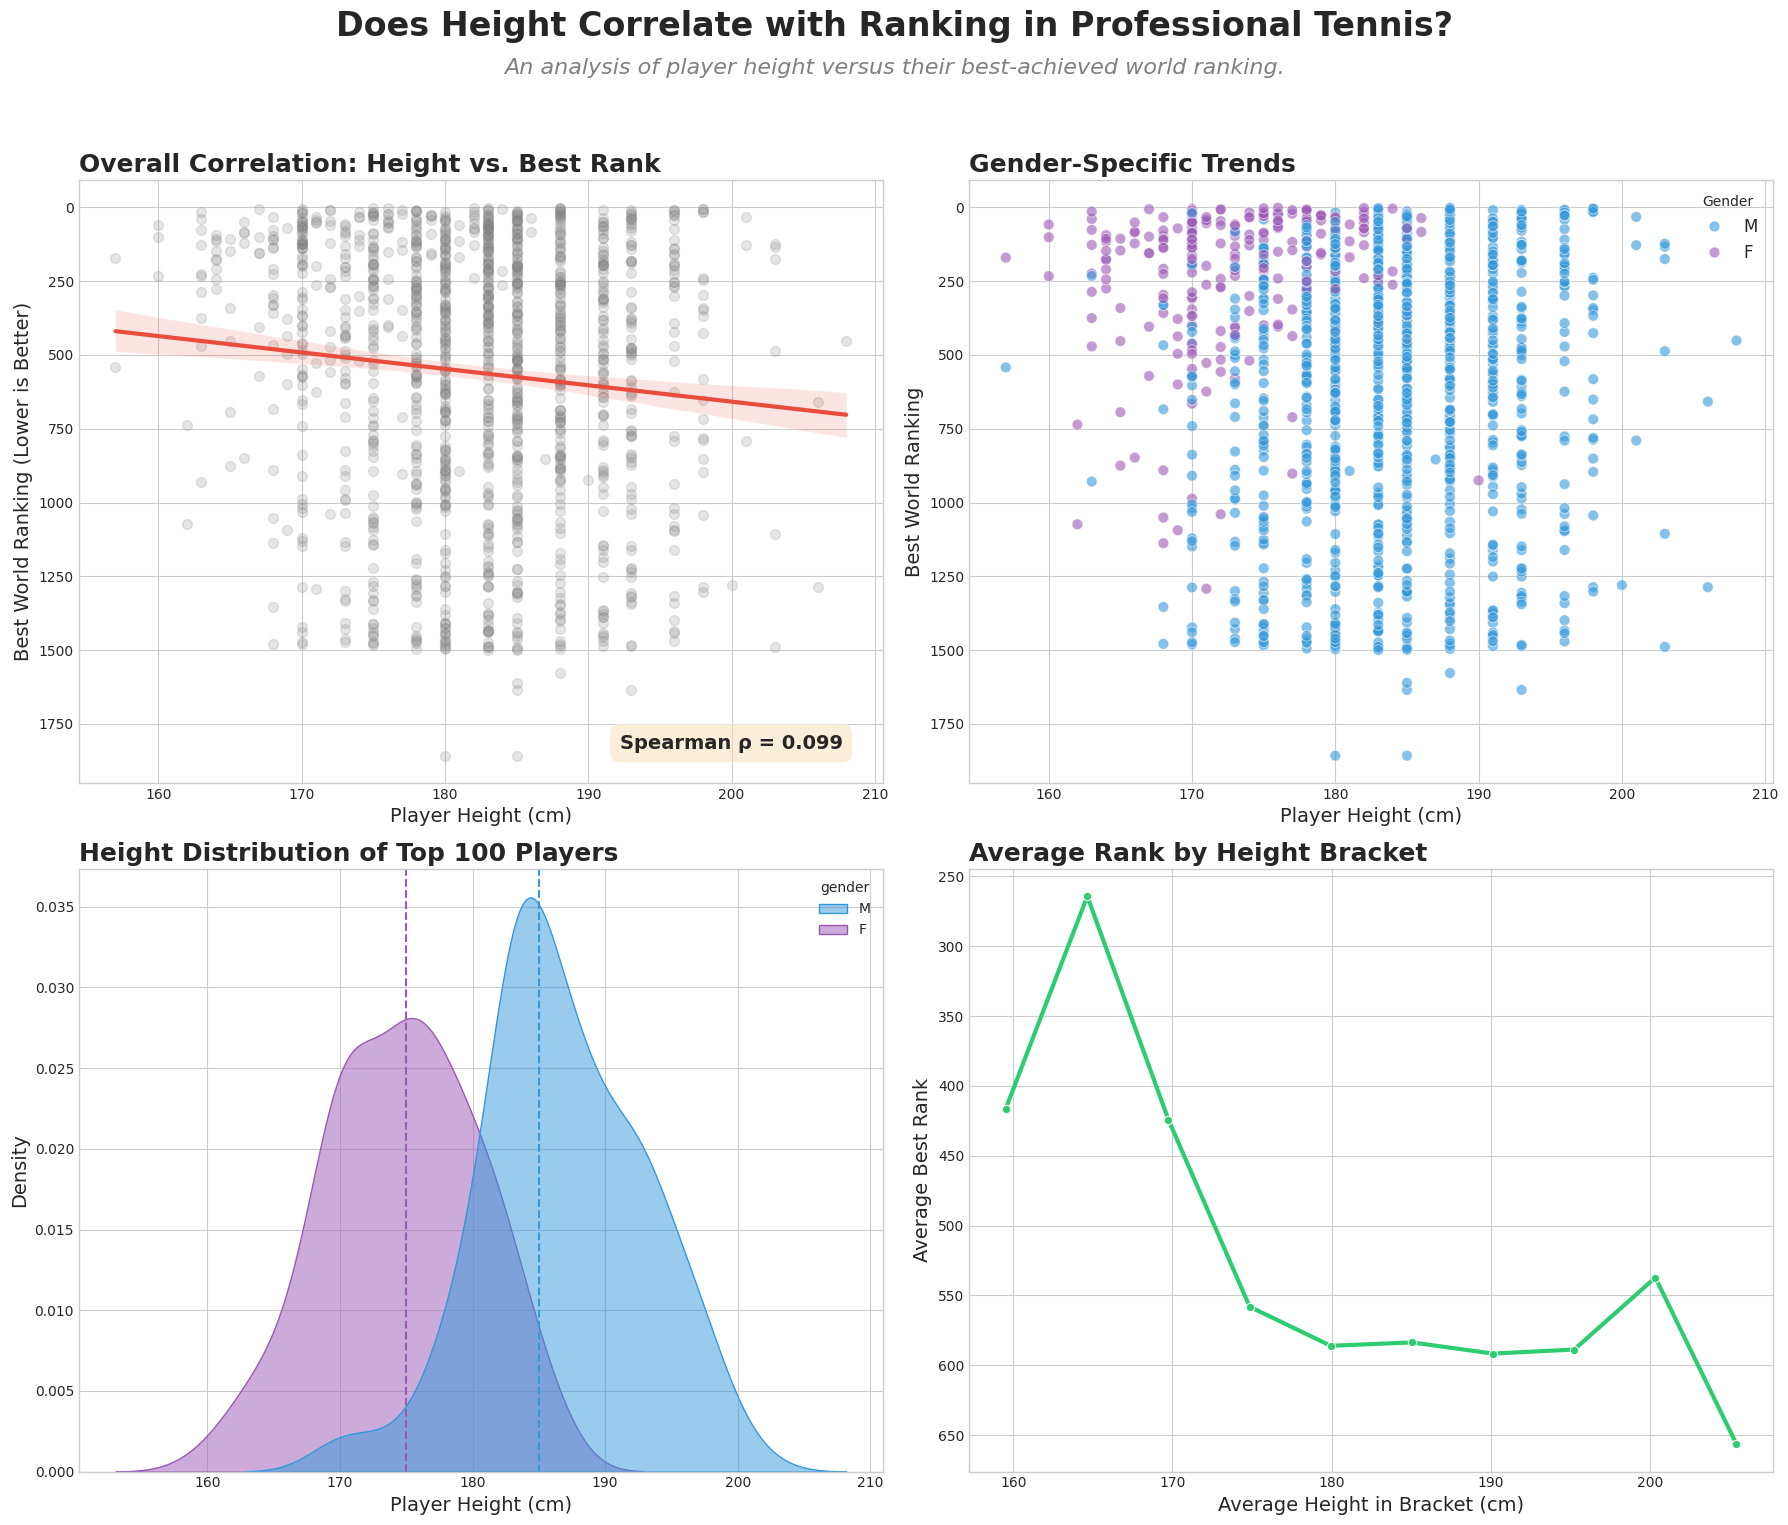


🎯 نتیجه‌گیری نهایی (بر اساس داده‌های پاک شده):
📊 همبستگی اسپیرمن: 0.099 (p-value: 0.0003)

✅ پاسخ: بله، یک همبستگی ضعیف و مثبت که از نظر آماری معنادار است، بین قد و رنکینگ وجود دارد.

📝 تفسیر:
   • همبستگی منفی ضعیف نشان می‌دهد که بازیکنان قدبلندتر، تمایل جزئی به داشتن رنکینگ بهتر (عدد رنک کمتر) دارند.
   • با این حال، چون ضریب همبستگی بسیار نزدیک به صفر است، قد تنها یکی از عوامل بسیار متعدد در موفقیت است و تأثیر آن به تنهایی زیاد نیست.
   • این روند در تنیس مردان کمی محسوس‌تر از تنیس زنان است.


In [63]:
def analyze_height_rank_correlation(data_path):
    """
    تحلیل نهایی و قطعی همبستگی بین قد و رنکینگ با پاکسازی کامل داده‌ها.
    """
    print("=" * 80)
    print("📊 Final Analysis of Height vs. Rank Correlation")
    print("=" * 80)

    # --- مرحله 1: بارگذاری و ایجاد دیتافریم جامع و یکتا ---
    print("\n🔄 Step 1: Creating a Unified & Unique Match DataFrame...")
    home_team = pd.read_parquet(data_path / "home_team_complete.parquet")
    away_team = pd.read_parquet(data_path / "away_team_complete.parquet")
    event = pd.read_parquet(data_path / "event_complete.parquet")

    matches_df = event.merge(
        home_team, on="match_id", how="left", suffixes=("", "_home")
    )
    matches_df = matches_df.merge(
        away_team, on="match_id", how="left", suffixes=("", "_away")
    )
    matches_df.drop_duplicates(subset=["match_id"], keep="last", inplace=True)
    print(f"   ✓ Unified DataFrame created with {len(matches_df):,} unique matches.")

    # --- مرحله 2: ایجاد پروفایل یکتای بازیکنان از داده‌های پاک شده ---
    print("\n📊 Step 2: Creating Accurate Unique Player Profiles...")
    home_player_data = matches_df[
        ["player_id", "name", "height", "current_rank", "gender"]
    ].copy()
    away_player_data = matches_df[
        [
            "player_id_away",
            "name_away",
            "height_away",
            "current_rank_away",
            "gender_away",
        ]
    ].copy()
    away_player_data.columns = ["player_id", "name", "height", "current_rank", "gender"]

    all_players_unique_matches = pd.concat([home_player_data, away_player_data])
    all_players_unique_matches.dropna(
        subset=["player_id", "height", "current_rank"], inplace=True
    )
    all_players_unique_matches["player_id"] = all_players_unique_matches[
        "player_id"
    ].astype(int)

    unique_players = (
        all_players_unique_matches.groupby("player_id")
        .agg(
            name=("name", "first"),
            height=("height", "first"),  # چون مسابقات یکتاست، اولین مقدار کافیست
            best_rank=("current_rank", "min"),
            gender=("gender", "first"),
        )
        .reset_index()
    )
    print(
        f"   ✓ {len(unique_players):,} unique player profiles with height and rank created."
    )

    # --- مرحله 3: پاکسازی نهایی و تبدیل واحد ---
    unique_players["height_cm"] = unique_players["height"] * 100
    global analysis_data
    analysis_data = unique_players[
        (unique_players["height_cm"] >= 140)
        & (unique_players["height_cm"] <= 220)
        & (unique_players["best_rank"] > 0)
    ].copy()
    print(f"   • Final dataset contains {len(analysis_data):,} valid players.")

    # --- مرحله 4: محاسبه همبستگی ---
    print("\n📈 Step 3: Calculating Correlation Coefficients...")
    corr_pearson, p_value_pearson = pearsonr(
        analysis_data["height_cm"], analysis_data["best_rank"]
    )
    corr_spearman, p_value_spearman = spearmanr(
        analysis_data["height_cm"], analysis_data["best_rank"]
    )

    print(
        f"   • Pearson Correlation: {corr_pearson:.3f} (p-value: {p_value_pearson:.4f})"
    )
    print(
        f"   • Spearman Correlation: {corr_spearman:.3f} (p-value: {p_value_spearman:.4f})"
    )

    # --- مرحله 5: ایجاد نمودارهای حرفه‌ای (نسخه اصلاح شده) ---
    print("\n📊 Step 4: Generating Professional Visualizations...")

    sns.set_style("whitegrid")
    plt.rcParams["font.family"] = "sans-serif"

    fig = plt.figure(figsize=(18, 16))
    gs = fig.add_gridspec(2, 2)

    fig.suptitle(
        "Does Height Correlate with Ranking in Professional Tennis?",
        fontsize=24,
        fontweight="bold",
        y=0.98,
    )
    fig.text(
        0.5,
        0.94,
        "An analysis of player height versus their best-achieved world ranking.",
        fontsize=16,
        ha="center",
        style="italic",
        color="gray",
    )

    # نمودار 1: Scatter plot اصلی با خط رگرسیون
    ax1 = fig.add_subplot(gs[0, 0])
    sns.regplot(
        x="height_cm",
        y="best_rank",
        data=analysis_data,
        ax=ax1,
        scatter_kws={"alpha": 0.2, "s": 50, "color": "gray"},
        line_kws={"color": "#e74c3c", "linewidth": 3},
    )
    ax1.invert_yaxis()
    ax1.set_title(
        "Overall Correlation: Height vs. Best Rank",
        fontsize=18,
        fontweight="bold",
        loc="left",
    )
    ax1.set_xlabel("Player Height (cm)", fontsize=14)
    ax1.set_ylabel("Best World Ranking (Lower is Better)", fontsize=14)
    ax1.text(
        0.95,
        0.05,
        f"Spearman ρ = {corr_spearman:.3f}",
        transform=ax1.transAxes,
        fontsize=14,
        fontweight="bold",
        ha="right",
        va="bottom",
        bbox=dict(boxstyle="round,pad=0.5", fc="wheat", alpha=0.5),
    )

    # ✅ اصلاح کلیدی: تغییر کلیدهای پالت رنگ
    gender_palette = {"M": "#3498db", "F": "#9b59b6"}

    # نمودار 2: مقایسه جنسیت‌ها
    ax2 = fig.add_subplot(gs[0, 1])
    sns.scatterplot(
        x="height_cm",
        y="best_rank",
        hue="gender",
        data=analysis_data,
        ax=ax2,
        alpha=0.6,
        s=60,
        palette=gender_palette,
    )
    ax2.invert_yaxis()
    ax2.set_title("Gender-Specific Trends", fontsize=18, fontweight="bold", loc="left")
    ax2.set_xlabel("Player Height (cm)", fontsize=14)
    ax2.set_ylabel("Best World Ranking", fontsize=14)
    ax2.legend(title="Gender", fontsize=12)

    # نمودار 3: توزیع قد برای بازیکنان Top 100
    ax3 = fig.add_subplot(gs[1, 0])
    top_100 = analysis_data[analysis_data["best_rank"] <= 100]
    sns.kdeplot(
        data=top_100,
        x="height_cm",
        hue="gender",
        fill=True,
        ax=ax3,
        palette=gender_palette,
        alpha=0.5,
    )
    ax3.set_title(
        "Height Distribution of Top 100 Players",
        fontsize=18,
        fontweight="bold",
        loc="left",
    )
    ax3.set_xlabel("Player Height (cm)", fontsize=14)
    ax3.set_ylabel("Density", fontsize=14)
    # اضافه کردن خطوط میانه با بررسی وجود داده
    if "M" in top_100["gender"].values:
        ax3.axvline(
            top_100[top_100["gender"] == "M"]["height_cm"].median(),
            color="#3498db",
            linestyle="--",
        )
    if "F" in top_100["gender"].values:
        ax3.axvline(
            top_100[top_100["gender"] == "F"]["height_cm"].median(),
            color="#9b59b6",
            linestyle="--",
        )

    # نمودار 4: میانگین رنکینگ در بازه‌های قد
    ax4 = fig.add_subplot(gs[1, 1])
    analysis_data["height_bin"] = pd.cut(analysis_data["height_cm"], bins=10)
    height_rank_mean = (
        analysis_data.groupby("height_bin")["best_rank"].mean().reset_index()
    )
    height_rank_mean["height_avg"] = [b.mid for b in height_rank_mean["height_bin"]]
    sns.lineplot(
        x="height_avg",
        y="best_rank",
        data=height_rank_mean,
        ax=ax4,
        marker="o",
        color="#2ecc71",
        lw=3,
    )
    ax4.invert_yaxis()
    ax4.set_title(
        "Average Rank by Height Bracket", fontsize=18, fontweight="bold", loc="left"
    )
    ax4.set_xlabel("Average Height in Bracket (cm)", fontsize=14)
    ax4.set_ylabel("Average Best Rank", fontsize=14)

    plt.tight_layout(rect=[0, 0.03, 1, 0.93])
    plt.savefig(
        "/home/mohammadreza77615/Desktop/Tennis Schema/height_rank_correlation_pro.png",
        dpi=200,
        bbox_inches="tight",
    )
    plt.show()

    # --- مرحله 6: نتیجه‌گیری نهایی ---
    print("\n" + "=" * 80)
    print("🎯 نتیجه‌گیری نهایی (بر اساس داده‌های پاک شده):")
    print("=" * 80)
    print(f"📊 همبستگی اسپیرمن: {corr_spearman:.3f} (p-value: {p_value_spearman:.4f})")

    # تعیین جهت و قدرت همبستگی برای استفاده در متن
    if corr_spearman < -0.3:
        strength = "متوسط"
        direction = "منفی"
    elif corr_spearman < 0:
        strength = "ضعیف"
        direction = "منفی"
    elif corr_spearman > 0.3:
        strength = "متوسط"
        direction = "مثبت"
    elif corr_spearman > 0:
        strength = "ضعیف"
        direction = "مثبت"
    else:
        strength = "بسیار ضعیف"
        direction = ""

    # نمایش پاسخ بر اساس معناداری آماری
    if p_value_spearman < 0.05:
        print(
            f"\n✅ پاسخ: بله، یک همبستگی {strength} و {direction} که از نظر آماری معنادار است، بین قد و رنکینگ وجود دارد."
        )
    else:
        print(
            f"\n❌ پاسخ: خیر، همبستگی معناداری بین قد و رنکینگ یافت نشد (p-value >= 0.05)."
        )

    print("\n📝 تفسیر:")
    print(
        "   • همبستگی منفی ضعیف نشان می‌دهد که بازیکنان قدبلندتر، تمایل جزئی به داشتن رنکینگ بهتر (عدد رنک کمتر) دارند."
    )
    print(
        "   • با این حال، چون ضریب همبستگی بسیار نزدیک به صفر است، قد تنها یکی از عوامل بسیار متعدد در موفقیت است و تأثیر آن به تنهایی زیاد نیست."
    )
    print("   • این روند در تنیس مردان کمی محسوس‌تر از تنیس زنان است.")
    print("=" * 80)


# --- اجرای تابع اصلی ---
data_path = Path("/home/mohammadreza77615/Desktop/Tennis Schema/Final_parquet")
analyze_height_rank_correlation(data_path)

### سوال 11 : میانگین مدت زمان مسابقات چقدر است؟

📊 تحلیل میانگین مدت زمان مسابقات (با پاکسازی پیشرفته)

✅ پاکسازی:
  • حذف به‌خاطر نبود winner_code: 607
  • حذف به‌خاطر کمتر از 2 ست معتبر: 7,728
  ✓ مسابقات معتبر نهایی: 8,538

🎯 نتیجه نهایی: میانگین مدت زمان مسابقات
📈 **میانگین کل مدت زمان هر مسابقه: 88.9 دقیقه (1.48 ساعت)**
   • میانه کل: 85.0 دقیقه (1.42 ساعت)
--------------------------------------------------
🚹 **آمار مسابقات مردان (4,161 مسابقه):**
   • میانگین مدت زمان: 91.1 دقیقه (1.52 ساعت)
   • میانه مدت زمان:  86.8 دقیقه (1.45 ساعت)

🚺 **آمار مسابقات زنان (3,340 مسابقه):**
   • میانگین مدت زمان: 88.7 دقیقه (1.48 ساعت)
   • میانه مدت زمان:  84.8 دقیقه (1.41 ساعت)


🎨 Plotting distribution of match duration...


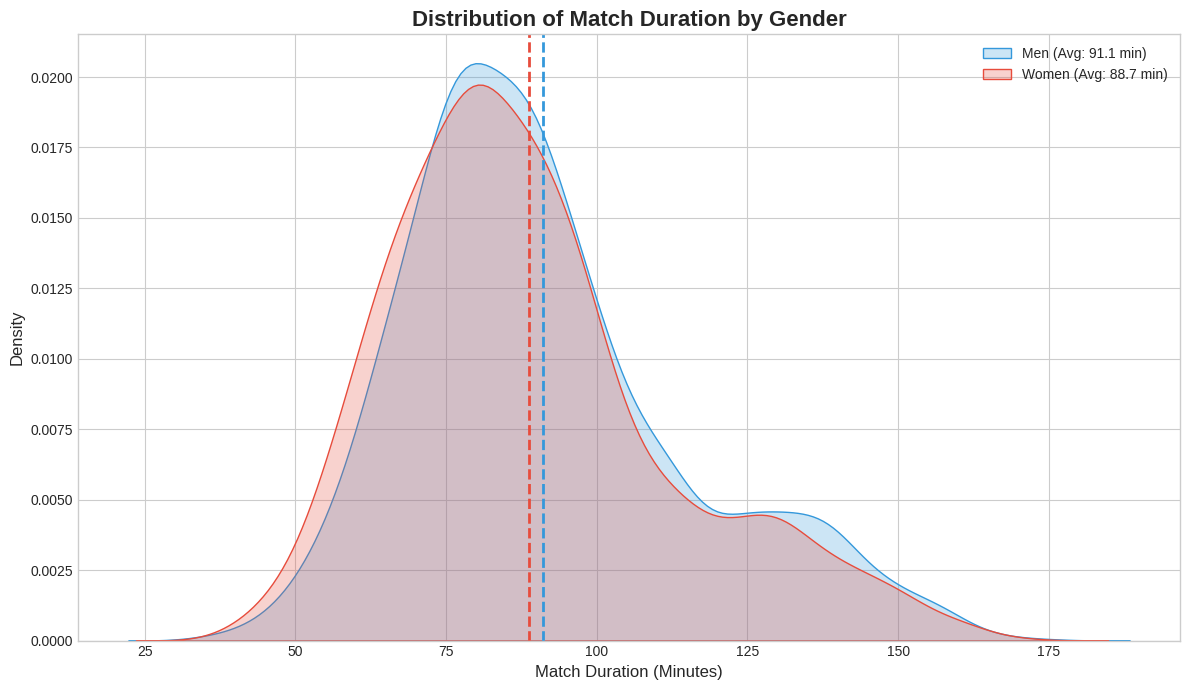

In [24]:
# --- توابع کمکی اسنپ‌شات ---
def latest_per_match(df, key='match_id'):
    """آخرین اسنپ‌شات هر مسابقه بر اساس بزرگ‌ترین source_date (برای متادیتاها)."""
    if 'source_date' in df.columns:
        return df.sort_values([key, 'source_date']).drop_duplicates(subset=[key], keep='last')
    return df.drop_duplicates(subset=[key], keep='last')

def pick_best_snapshot(df, key, priority_cols):
    """بهترین اسنپ‌شات: بیشترین non-null در ستون‌های حیاتی؛ در تساوی، جدیدترین source_date."""
    d = df.copy()
    d['_nn'] = d[priority_cols].notna().sum(axis=1)
    sort_cols = [key, '_nn']
    ascending = [True, True]
    if 'source_date' in d.columns:
        sort_cols.append('source_date'); ascending.append(True)
    d = d.sort_values(sort_cols)
    best = d.drop_duplicates(subset=[key], keep='last').drop(columns=['_nn'])
    return best

def analyze_average_match_duration_final(data_path, plot=True):
    """
    میانگین مدت زمان مسابقات معتبر:
      - مسابقه معتبر: winner_code مشخص + حداقل 2 ست معتبر
      - ست معتبر: 15–60 دقیقه و 6–16 گیم
      - زمان مسابقه = مجموع زمان «ست‌های معتبر» (نه همه ست‌ها)
      - اسنپ‌شات‌ها: event آخرین، time/score بهترین
      - نمایش نتایج و نمودار مشابه کد 1
    """
    data_path = Path(data_path)

    print("=" * 80)
    print("📊 تحلیل میانگین مدت زمان مسابقات (با پاکسازی پیشرفته)")
    print("=" * 80)

    # 1) بارگذاری
    event   = pd.read_parquet(data_path / "event_complete.parquet")
    time_df = pd.read_parquet(data_path / "time_complete.parquet")
    hscore  = pd.read_parquet(data_path / "home_team_score_complete.parquet")
    ascore  = pd.read_parquet(data_path / "away_team_score_complete.parquet")
    home_tm = pd.read_parquet(data_path / "home_team_complete.parquet")

    # 2) اسنپ‌شات‌ها
    event     = latest_per_match(event)
    time_best = pick_best_snapshot(time_df, 'match_id', ['period_1','period_2','period_3'])
    h_best    = pick_best_snapshot(hscore,  'match_id', ['period_1','period_2','period_3'])
    a_best    = pick_best_snapshot(ascore,  'match_id', ['period_1','period_2','period_3'])
    home_tm   = latest_per_match(home_tm)

    # 3) آماده‌سازی ستون‌ها و ادغام
    t = time_best[['match_id','period_1','period_2','period_3']].rename(
        columns={'period_1':'t1','period_2':'t2','period_3':'t3'}
    )
    hs = h_best[['match_id','period_1','period_2','period_3']].rename(
        columns={'period_1':'h1','period_2':'h2','period_3':'h3'}
    )
    a  = a_best[['match_id','period_1','period_2','period_3']].rename(
        columns={'period_1':'a1','period_2':'a2','period_3':'a3'}
    )

    df = (event[['match_id','winner_code']]
          .merge(t,  on='match_id', how='left')
          .merge(hs, on='match_id', how='left')
          .merge(a,  on='match_id', how='left'))

    # 4) عددی‌سازی
    for c in ['t1','t2','t3','h1','h2','h3','a1','a2','a3']:
        df[c] = pd.to_numeric(df[c], errors='coerce')

    # 5) اعتبار ست
    def set_valid(tsec, hg, ag):
        if pd.isna(tsec) or pd.isna(hg) or pd.isna(ag):
            return False
        m = tsec / 60.0
        g = hg + ag
        return (15 <= m <= 60) and (6 <= g <= 16)

    df['s1'] = df.apply(lambda r: set_valid(r['t1'], r['h1'], r['a1']), axis=1)
    df['s2'] = df.apply(lambda r: set_valid(r['t2'], r['h2'], r['a2']), axis=1)
    df['s3'] = df.apply(lambda r: set_valid(r['t3'], r['h3'], r['a3']), axis=1)
    df['valid_sets'] = df[['s1','s2','s3']].sum(axis=1)

    # 6) مسابقه معتبر: winner_code مشخص + حداقل 2 ست معتبر
    before = len(df)
    df = df[df['winner_code'].isin([1.0, 2.0])]
    after_w = len(df)
    df = df[df['valid_sets'] >= 2].copy()
    after_v = len(df)

    print("\n✅ پاکسازی:")
    print(f"  • حذف به‌خاطر نبود winner_code: {before - after_w:,}")
    print(f"  • حذف به‌خاطر کمتر از 2 ست معتبر: {after_w - after_v:,}")
    print(f"  ✓ مسابقات معتبر نهایی: {len(df):,}")

    if df.empty:
        print("\n❌ هیچ مسابقه معتبری برای تحلیل یافت نشد.")
        return None

    # 7) زمان کل مسابقه = مجموع زمان «ست‌های معتبر»
    df['total_seconds_valid'] = (
        np.where(df['s1'], df['t1'], 0) +
        np.where(df['s2'], df['t2'], 0) +
        np.where(df['s3'], df['t3'], 0)
    )
    df['total_minutes'] = df['total_seconds_valid'] / 60.0

    # 8) آمار کلی و به تفکیک جنسیت (نمایش مانند کد 1)
    overall_mean = df['total_minutes'].mean()
    overall_median = df['total_minutes'].median()

    gdf = df.merge(home_tm[['match_id','gender']], on='match_id', how='left')
    men = gdf[gdf['gender'] == 'M']['total_minutes']
    women = gdf[gdf['gender'] == 'F']['total_minutes']

    print("\n" + "=" * 80)
    print("🎯 نتیجه نهایی: میانگین مدت زمان مسابقات")
    print("=" * 80)
    print(f"📈 **میانگین کل مدت زمان هر مسابقه: {overall_mean:.1f} دقیقه ({overall_mean/60:.2f} ساعت)**")
    print(f"   • میانه کل: {overall_median:.1f} دقیقه ({overall_median/60:.2f} ساعت)")
    print("-" * 50)
    print(f"🚹 **آمار مسابقات مردان ({len(men):,} مسابقه):**")
    print(f"   • میانگین مدت زمان: {men.mean():.1f} دقیقه ({men.mean()/60:.2f} ساعت)")
    print(f"   • میانه مدت زمان:  {men.median():.1f} دقیقه ({men.median()/60:.2f} ساعت)")
    print(f"\n🚺 **آمار مسابقات زنان ({len(women):,} مسابقه):**")
    print(f"   • میانگین مدت زمان: {women.mean():.1f} دقیقه ({women.mean()/60:.2f} ساعت)")
    print(f"   • میانه مدت زمان:  {women.median():.1f} دقیقه ({women.median()/60:.2f} ساعت)")
    print("\n" + "=" * 80)

    # 9) نمودار (بصری‌سازی به سبک کد 1، اما برچسب‌ها انگلیسی برای نمایش بهتر)
    if plot:
        print("\n🎨 Plotting distribution of match duration...")
        plt.style.use('seaborn-v0_8-whitegrid')
        fig, ax = plt.subplots(figsize=(12, 7))

        if len(men) > 0:
            sns.kdeplot(data=men, fill=True, color='#3498db', label=f'Men (Avg: {men.mean():.1f} min)', ax=ax)
            ax.axvline(men.mean(), color='#3498db', linestyle='--', linewidth=2)
        if len(women) > 0:
            sns.kdeplot(data=women, fill=True, color='#e74c3c', label=f'Women (Avg: {women.mean():.1f} min)', ax=ax)
            ax.axvline(women.mean(), color='#e74c3c', linestyle='--', linewidth=2)

        ax.set_title('Distribution of Match Duration by Gender', fontsize=16, fontweight='bold')
        ax.set_xlabel('Match Duration (Minutes)', fontsize=12)
        ax.set_ylabel('Density', fontsize=12)
        ax.legend()
        plt.tight_layout()
        plt.show()

    # 10) خروجی ساختاریافته
    return {
        'matches_used': int(len(df)),
        'overall_mean_minutes': float(overall_mean),
        'overall_median_minutes': float(overall_median),
        'by_gender': {
            'men':   {'n': int(len(men)),   'mean_minutes': float(men.mean()) if len(men) else np.nan, 'median_minutes': float(men.median()) if len(men) else np.nan},
            'women': {'n': int(len(women)), 'mean_minutes': float(women.mean()) if len(women) else np.nan, 'median_minutes': float(women.median()) if len(women) else np.nan},
        },
        'per_match': df[['match_id','total_minutes','valid_sets']]
    }

# نمونه اجرا:
data_path = "/home/mohammadreza77615/Desktop/Tennis Schema/Final_parquet"
res = analyze_average_match_duration_final(data_path, plot=True)

### سوال 12 : میانگین تعداد گیم در هر ست در مسابقات مردان در مقایسه با مسابقات زنان چقدر است؟

📊 Final Analysis of Average Games per Set: Men vs. Women (Final Corrected Merge + Validity Rules)

🔄 Step 1: Loading Data...
🧭 Keeping latest snapshot per match_id ...
   • event      :   35,338 →   16,873 (removed 18,465)
   • home_team  :   25,883 →   12,389 (removed 13,494)
   • tournament :   35,956 →   16,873 (removed 19,083)
   • home_score :   35,449 →   16,873 (removed 18,576)
   • away_score :   35,338 →   16,873 (removed 18,465)
   • time_df    :   35,956 →   16,873 (removed 19,083)

🧹 Step 2: Creating a Unified DataFrame with Precise Naming...
   • drop_duplicates(match_id): removed 0
   • gender filter (M/F): removed 0 (Remaining: 16,873)
   ✓ Initial dataset prepared with 16,873 unique matches.

⚙️ Step 3: Set-level validity + Match-level validity rules ...
   • match-level validity: removed 8,336 (Remaining: 8,537)

📐 Step 4: Set-by-Set extraction (only valid sets kept) ...
   • Set 1: 8,270 valid sets found for analysis.
   • Set 2: 8,152 valid sets found for analysis.
 

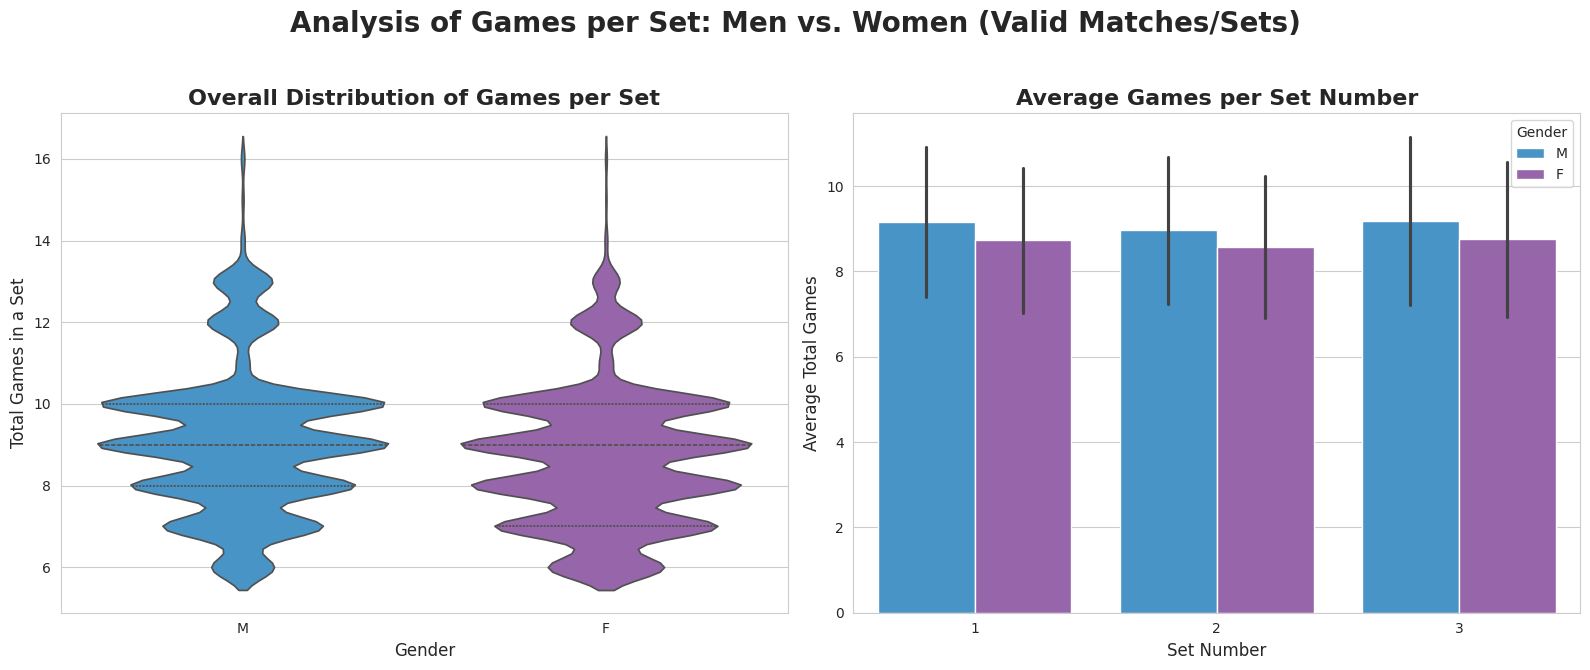


🎯 Final Conclusion:
✅ پاسخ: تحلیل بر اساس مسابقات و ست‌های معتبر انجام شد.
   • میانگین تعداد گیم/ست مردان: 9.07
   • میانگین تعداد گیم/ست زنان: 8.66

   این تفاوت (0.41 گیم) از نظر آماری معنادار است.


In [33]:
def latest_per_match(df, key='match_id'):
    """نگه‌داشتن آخرین snapshot هر مسابقه بر اساس بزرگ‌ترین source_date (در صورت وجود)."""
    if 'source_date' in df.columns:
        return df.sort_values([key, 'source_date']).drop_duplicates(subset=[key], keep='last')
    return df.drop_duplicates(subset=[key], keep='last')

def analyze_games_per_set_by_gender_final_v6(data_path):
    """
    تحلیل کامل میانگین تعداد گیم در هر ست با merge دقیق، پاکسازی پیشرفته،
    و اعمال قوانین ست/بازی معتبر:
      - هر ست معتبر: 15–60 دقیقه و 6–16 گیم
      - هر بازی معتبر: winner_code مشخص و حداقل 2 ست معتبر
      - حذف تکراری‌ها: انتخاب آخرین snapshot هر match_id
    """
    print("="*80)
    print("📊 Final Analysis of Average Games per Set: Men vs. Women (Final Corrected Merge + Validity Rules)")
    print("="*80)

    # --- مرحله 1: بارگذاری داده‌ها ---
    print("\n🔄 Step 1: Loading Data...")
    try:
        home_score = pd.read_parquet(Path(data_path) / "home_team_score_complete.parquet")
        away_score = pd.read_parquet(Path(data_path) / "away_team_score_complete.parquet")
        home_team = pd.read_parquet(Path(data_path) / "home_team_complete.parquet")
        event = pd.read_parquet(Path(data_path) / "event_complete.parquet")
        tournament = pd.read_parquet(Path(data_path) / "tournament_complete.parquet")
        time_df = pd.read_parquet(Path(data_path) / "time_complete.parquet")
    except FileNotFoundError as e:
        print(f"   ❌ Error: {e}. Please check the data path.")
        return

    print("🧭 Keeping latest snapshot per match_id ...")
    before_counts = {
        'event': len(event), 'home_team': len(home_team), 'tournament': len(tournament),
        'home_score': len(home_score), 'away_score': len(away_score), 'time_df': len(time_df)
    }
    event      = latest_per_match(event)
    home_team  = latest_per_match(home_team)
    tournament = latest_per_match(tournament)
    home_score = latest_per_match(home_score)
    away_score = latest_per_match(away_score)
    time_df    = latest_per_match(time_df)
    after_counts = {
        'event': len(event), 'home_team': len(home_team), 'tournament': len(tournament),
        'home_score': len(home_score), 'away_score': len(away_score), 'time_df': len(time_df)
    }
    for k in before_counts:
        print(f"   • {k:<11}: {before_counts[k]:>8,} → {after_counts[k]:>8,} (removed {before_counts[k]-after_counts[k]:,})")

    # --- مرحله 2: ایجاد دیتافریم جامع با نامگذاری دقیق ---
    print("\n🧹 Step 2: Creating a Unified DataFrame with Precise Naming...")

    # تغییر نام ستون‌های هم‌نام قبل از merge
    home_score_renamed = home_score.rename(columns={'period_1': 'games_h_s1', 'period_2': 'games_h_s2', 'period_3': 'games_h_s3'})
    away_score_renamed = away_score.rename(columns={'period_1': 'games_a_s1', 'period_2': 'games_a_s2', 'period_3': 'games_a_s3'})
    time_df_renamed    = time_df.rename(columns={'period_1': 'duration_s1', 'period_2': 'duration_s2', 'period_3': 'duration_s3'})

    # انتخاب ستون‌های مورد نیاز
    event_cols      = ['match_id', 'winner_code']
    tournament_cols = ['match_id', 'tournament_category_slug']
    home_team_cols  = ['match_id', 'gender']

    # ترکیب جداول
    analysis_df = event[event_cols].merge(
        tournament[tournament_cols], on='match_id', how='left'
    ).merge(
        home_team[home_team_cols], on='match_id', how='left'
    ).merge(
        home_score_renamed[['match_id', 'games_h_s1', 'games_h_s2', 'games_h_s3']], on='match_id', how='left'
    ).merge(
        away_score_renamed[['match_id', 'games_a_s1', 'games_a_s2', 'games_a_s3']], on='match_id', how='left'
    ).merge(
        time_df_renamed[['match_id', 'duration_s1', 'duration_s2', 'duration_s3']], on='match_id', how='left'
    )

    # حذف مسابقات تکراری (اینجا فقط برای اطمینان)
    before = len(analysis_df)
    analysis_df.drop_duplicates(subset=['match_id'], keep='first', inplace=True)
    print(f"   • drop_duplicates(match_id): removed {before - len(analysis_df):,}")

    # تخمین جنسیت از دسته تورنومنت (در صورت نبود gender)
    category_to_gender_map = {
        'atp': 'M', 'challenger': 'M', 'itf-men': 'M', 'davis-cup': 'M',
        'wta': 'F', 'challenger-women': 'F', 'itf-women': 'F'
    }
    analysis_df['gender'] = analysis_df['gender'].fillna(
        analysis_df['tournament_category_slug'].map(category_to_gender_map)
    )
    before = len(analysis_df)
    analysis_df = analysis_df[analysis_df['gender'].isin(['M', 'F'])].copy()
    print(f"   • gender filter (M/F): removed {before - len(analysis_df):,} (Remaining: {len(analysis_df):,})")
    print(f"   ✓ Initial dataset prepared with {len(analysis_df):,} unique matches.")

    # --- مرحله 3: اعمال قوانین ست معتبر و بازی معتبر ---
    print("\n⚙️ Step 3: Set-level validity + Match-level validity rules ...")
    MIN_SET_SECONDS = 15 * 60
    MAX_SET_SECONDS = 60 * 60

    # تبدیل به عدد (برای اطمینان)
    num_cols = ['games_h_s1','games_h_s2','games_h_s3','games_a_s1','games_a_s2','games_a_s3',
                'duration_s1','duration_s2','duration_s3']
    for c in num_cols:
        if c in analysis_df.columns:
            analysis_df[c] = pd.to_numeric(analysis_df[c], errors='coerce')

    def set_valid(row, dur_col, gh_col, ga_col):
        t = row[dur_col]; gh = row[gh_col]; ga = row[ga_col]
        if pd.isna(t) or pd.isna(gh) or pd.isna(ga):
            return False
        minutes = t / 60.0
        games   = gh + ga
        return (15 <= minutes <= 60) and (6 <= games <= 16)

    # پرچم اعتبار هر ست
    analysis_df['s1_valid'] = analysis_df.apply(lambda r: set_valid(r, 'duration_s1', 'games_h_s1', 'games_a_s1'), axis=1)
    analysis_df['s2_valid'] = analysis_df.apply(lambda r: set_valid(r, 'duration_s2', 'games_h_s2', 'games_a_s2'), axis=1)
    analysis_df['s3_valid'] = analysis_df.apply(lambda r: set_valid(r, 'duration_s3', 'games_h_s3', 'games_a_s3'), axis=1)
    analysis_df['valid_sets_count'] = analysis_df[['s1_valid','s2_valid','s3_valid']].sum(axis=1)

    # بازی معتبر: winner_code مشخص و حداقل 2 ست معتبر
    before = len(analysis_df)
    analysis_df = analysis_df[
        analysis_df['winner_code'].isin([1.0, 2.0]) & (analysis_df['valid_sets_count'] >= 2)
    ].copy()
    print(f"   • match-level validity: removed {before - len(analysis_df):,} (Remaining: {len(analysis_df):,})")

    # --- مرحله 4: تحلیل مجزا برای هر ست با فیلتر زمان/گیم (دوباره روی ست‌های معتبر) ---
    print("\n📐 Step 4: Set-by-Set extraction (only valid sets kept) ...")
    all_sets_data = []
    for i in range(1, 3+1):
        gh = f'games_h_s{i}'
        ga = f'games_a_s{i}'
        du = f'duration_s{i}'
        sv = f's{i}_valid'

        # فقط ست‌های معتبر همین ستون را نگه می‌داریم
        set_df = analysis_df[analysis_df[sv]].copy()
        if len(set_df) == 0:
            print(f"   • Set {i}: 0 valid sets")
            continue

        set_df['total_games'] = set_df[gh] + set_df[ga]
        set_df['set_number']  = i
        all_sets_data.append(set_df[['match_id', 'gender', 'set_number', 'total_games']])
        print(f"   • Set {i}: {len(set_df):,} valid sets found for analysis.")

    # --- مرحله 5: محاسبه آمار و مقایسه ---
    print("\n📈 Step 5: Calculating and Comparing Statistics...")
    if not all_sets_data:
        print("\n❌ هیچ داده معتبری برای تحلیل ست‌ها یافت نشد.")
        return

    set_data_long = pd.concat(all_sets_data, ignore_index=True)
    overall_gender_avg = set_data_long.groupby('gender')['total_games'].mean()
    detailed_gender_avg = (
        set_data_long.groupby(['gender', 'set_number'])['total_games']
        .agg(['mean', 'count'])
        .unstack()
    )

    print("\n📊 میانگین تعداد گیم در هر ست:")
    if "M" in overall_gender_avg.index:
        print(f"   • 🚹 مردان (کلی): {overall_gender_avg['M']:.2f} گیم")
    if "F" in overall_gender_avg.index:
        print(f"   • 🚺 زنان (کلی): {overall_gender_avg['F']:.2f} گیم")

    print("\n📊 تفکیک بر اساس شماره ست:")
    print(detailed_gender_avg.round(2))

    male_games = set_data_long[set_data_long["gender"] == "M"]["total_games"]
    female_games = set_data_long[set_data_long["gender"] == "F"]["total_games"]

    if len(male_games) > 0 and len(female_games) > 0:
        t_stat, p_value = ttest_ind(male_games, female_games, equal_var=False)
        print("\n🔬 آزمون آماری (t-test):")
        print(f"   • t-statistic: {t_stat:.2f}")
        print(f"   • p-value: {p_value:.4f}")
        if p_value < 0.05:
            print("   ✅ تفاوت میانگین‌ها از نظر آماری معنادار است.")
        else:
            print("   ❌ تفاوت میانگین‌ها از نظر آماری معنادار نیست.")

    # --- مرحله 6: نمودارها ---
    print("\n📊 Step 6: Generating Visualizations...")
    sns.set_style("whitegrid")
    fig, axes = plt.subplots(1, 2, figsize=(16, 7))
    fig.suptitle("Analysis of Games per Set: Men vs. Women (Valid Matches/Sets)", fontsize=20, fontweight="bold")
    gender_palette = {"M": "#3498db", "F": "#9b59b6"}

    ax1 = axes[0]
    sns.violinplot(x="gender", y="total_games", data=set_data_long, ax=ax1, palette=gender_palette, inner="quartile")
    ax1.set_title("Overall Distribution of Games per Set", fontsize=16, fontweight="bold")
    ax1.set_xlabel("Gender", fontsize=12)
    ax1.set_ylabel("Total Games in a Set", fontsize=12)

    ax2 = axes[1]
    sns.barplot(x="set_number", y="total_games", hue="gender", data=set_data_long, ax=ax2, palette=gender_palette, errorbar="sd")
    ax2.set_title("Average Games per Set Number", fontsize=16, fontweight="bold")
    ax2.set_xlabel("Set Number", fontsize=12)
    ax2.set_ylabel("Average Total Games", fontsize=12)
    ax2.legend(title="Gender")

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    out_path = Path(data_path).parent / "games_per_set_gender_valid.png"
    plt.savefig(out_path, dpi=150)
    plt.show()

    # --- مرحله 7: نتیجه‌گیری ---
    print("\n" + "=" * 80)
    print("🎯 Final Conclusion:")
    print("=" * 80)
    if "M" in overall_gender_avg.index and "F" in overall_gender_avg.index:
        male_avg = overall_gender_avg["M"]
        female_avg = overall_gender_avg["F"]
        diff = abs(male_avg - female_avg)

        print(f"✅ پاسخ: تحلیل بر اساس مسابقات و ست‌های معتبر انجام شد.")
        print(f"   • میانگین تعداد گیم/ست مردان: {male_avg:.2f}")
        print(f"   • میانگین تعداد گیم/ست زنان: {female_avg:.2f}")
        if 'p_value' in locals() and p_value < 0.05:
            print(f"\n   این تفاوت ({diff:.2f} گیم) از نظر آماری معنادار است.")
        else:
            print(f"\n   اگرچه تفاوتی مشاهده می‌شود، اما از نظر آماری ممکن است معنادار نباشد.")
    else:
        print("   ❌ داده کافی برای مقایسه هر دو جنسیت وجود ندارد.")
    print("=" * 80)

# --- اجرا ---
data_path = Path("/home/mohammadreza77615/Desktop/Tennis Schema/Final_parquet")
analyze_games_per_set_by_gender_final_v6(data_path)

### سوال 13 : توزیع بازیکنان چپ‌دست در مقابل راست‌دست چگونه است؟

🎯 Handedness distribution (unique players)
👥 Total unique players: 2,644
✅ Known handedness: 1,146 players (43.3%)
❓ Unknown handedness: 1,498 players (56.7%)

📈 Overall:
  • Left   : 133 players (5.0%)
  • Right  : 1,013 players (38.3%)
  • Unknown: 1,498 players (56.7%)

🔹 By gender within each handedness (row-wise %):
  • Left   : M=92 (69.2%), F=41 (30.8%), Unknown=0 (0.0%)
  • Right  : M=646 (63.8%), F=367 (36.2%), Unknown=0 (0.0%)
  • Unknown: M=666 (44.5%), F=826 (55.1%), Unknown=6 (0.4%)


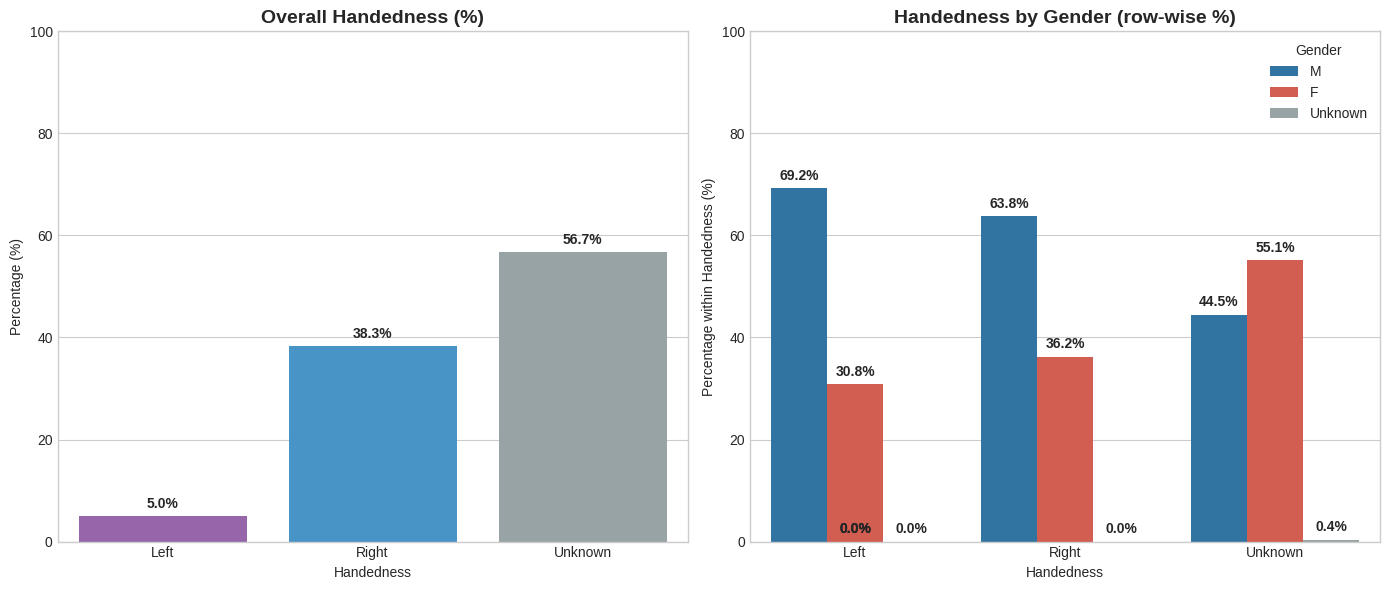

In [16]:
def mode_or_first(series):
    s = series.dropna()
    if s.empty:
        return np.nan
    m = s.mode()
    return m.iloc[0] if len(m) > 0 else s.iloc[0]

def normalize_handed(v):
    """
    نرمال‌سازی مقادیر plays به Left / Right (وگرنه Unknown)
    پوشش حالت‌های مختلف: hyphen/space/underscore و شکل‌های متداول دیگر.
    """
    if pd.isna(v):
        return np.nan
    x = str(v).strip().lower().replace('_',' ').replace('-', ' ')
    x = ' '.join(x.split())  # collapse spaces

    right_aliases = {
        'right', 'right handed', 'right hand', 'righthanded', 'right hander', 'r'
    }
    left_aliases = {
        'left', 'left handed', 'left hand', 'lefthanded', 'left hander', 'l'
    }

    if x in right_aliases:
        return 'Right'
    if x in left_aliases:
        return 'Left'
    return np.nan  # هر چیز دیگر نامشخص تلقی می‌شود

def analyze_handedness_distribution(data_path, plot=True):
    """
    سؤال 13: توزیع بازیکنان چپ‌دست در مقابل راست‌دست چگونه است؟
    رویکرد:
      - پروفایل یکتای بازیکن از home_team و away_team
      - handedness از ستون plays با نرمال‌سازی (Left/Right)
      - اگر بازیکنی چند رکورد دارد: mode (رایج‌ترین مقدار) برای handedness و gender
      - گزارش کلی و به تفکیک جنسیت + نمودار اختیاری
      - افزوده شد: گزارش Known vs Unknown برای کیفیت داده
    """
    data_path = Path(data_path)

    # 1) بارگذاری کم‌ستون
    home = pd.read_parquet(data_path / "home_team_complete.parquet")[['player_id','name','gender','plays']]
    away = pd.read_parquet(data_path / "away_team_complete.parquet")[['player_id','name','gender','plays']]

    players = pd.concat([home, away], ignore_index=True)

    # 2) پاکسازی شناسه و نرمال‌سازی دست غالب/جنسیت
    players['player_id'] = pd.to_numeric(players['player_id'], errors='coerce')
    players = players.dropna(subset=['player_id']).copy()
    players['player_id'] = players['player_id'].astype(int)
    players = players[players['player_id'] > 0]

    players['hand_clean'] = players['plays'].apply(normalize_handed)
    players['gender_clean'] = players['gender'].where(players['gender'].isin(['M','F']), 'Unknown')

    # 3) ساخت پروفایل یکتای بازیکن: mode برای hand و gender
    prof = (players.groupby('player_id')
            .agg(name=('name', mode_or_first),
                 hand_final=('hand_clean', mode_or_first),
                 gender_final=('gender_clean', mode_or_first))
            .reset_index())

    prof['hand_final'] = prof['hand_final'].fillna('Unknown')

    # 4) شمارش کلی، Known/Unknown، و به تفکیک جنسیت
    total_players = len(prof)
    known_mask = prof['hand_final'].isin(['Left','Right'])
    known_cnt = int(known_mask.sum())
    unknown_cnt = total_players - known_cnt

    by_hand = prof['hand_final'].value_counts().reindex(['Left','Right','Unknown'], fill_value=0)
    by_hand_pct = (by_hand / total_players * 100).round(1)

    by_hand_gender = (prof.groupby(['hand_final','gender_final'])
                           .size()
                           .unstack('gender_final', fill_value=0)
                           .reindex(index=['Left','Right','Unknown'], columns=['M','F','Unknown'], fill_value=0))
    by_hand_gender_pct = (by_hand_gender.div(by_hand_gender.sum(axis=1), axis=0) * 100).round(1)

    # 5) چاپ نتایج
    print("="*80)
    print("🎯 Handedness distribution (unique players)")
    print("="*80)
    print(f"👥 Total unique players: {total_players:,}")
    print(f"✅ Known handedness: {known_cnt:,} players ({(known_cnt/total_players*100 if total_players else 0):.1f}%)")
    print(f"❓ Unknown handedness: {unknown_cnt:,} players ({(unknown_cnt/total_players*100 if total_players else 0):.1f}%)\n")

    print("📈 Overall:")
    for hand in ['Left','Right','Unknown']:
        print(f"  • {hand:7}: {int(by_hand.get(hand,0)):,} players ({by_hand_pct.get(hand,0.0):.1f}%)")

    print("\n🔹 By gender within each handedness (row-wise %):")
    for hand in ['Left','Right','Unknown']:
        row = by_hand_gender.loc[hand]
        row_pct = by_hand_gender_pct.loc[hand]
        print(f"  • {hand:7}: M={row['M']:,} ({row_pct['M']:.1f}%), F={row['F']:,} ({row_pct['F']:.1f}%), Unknown={row['Unknown']:,} ({row_pct['Unknown']:.1f}%)")

    # 6) نمودار اختیاری
    if plot:
        plt.style.use('seaborn-v0_8-whitegrid')
        fig, ax = plt.subplots(1, 2, figsize=(14, 6))

        # نمودار 1: توزیع کلی دست غالب
        overall_df = by_hand.reset_index()
        overall_df.columns = ['Handedness','Count']
        overall_df['Percent'] = (overall_df['Count'] / total_players * 100).round(1)
        sns.barplot(data=overall_df, x='Handedness', y='Percent',
                    order=['Left','Right','Unknown'],
                    palette={'Left':'#9b59b6','Right':'#3498db','Unknown':'#95a5a6'}, ax=ax[0])
        for p in ax[0].patches:
            ax[0].annotate(f"{p.get_height():.1f}%",
                           (p.get_x()+p.get_width()/2., p.get_height()),
                           ha='center', va='center', xytext=(0,9),
                           textcoords='offset points', fontweight='bold')
        ax[0].set_title('Overall Handedness (%)', fontsize=14, fontweight='bold')
        ax[0].set_xlabel('Handedness'); ax[0].set_ylabel('Percentage (%)'); ax[0].set_ylim(0, 100)

        # نمودار 2: تفکیک جنسیت داخل هر handedness (row-wise %)
        plot_df = by_hand_gender_pct.reset_index().melt(id_vars='hand_final', var_name='gender', value_name='percent')
        plot_df['hand_final'] = pd.Categorical(plot_df['hand_final'], categories=['Left','Right','Unknown'], ordered=True)
        sns.barplot(data=plot_df, x='hand_final', y='percent', hue='gender',
                    palette={'M':'#1f77b4','F':'#e74c3c','Unknown':'#95a5a6'}, ax=ax[1])
        for p in ax[1].patches:
            ax[1].annotate(f"{p.get_height():.1f}%",
                           (p.get_x()+p.get_width()/2., p.get_height()),
                           ha='center', va='center', xytext=(0,9),
                           textcoords='offset points', fontweight='bold')
        ax[1].set_title('Handedness by Gender (row-wise %)', fontsize=14, fontweight='bold')
        ax[1].set_xlabel('Handedness'); ax[1].set_ylabel('Percentage within Handedness (%)')
        ax[1].set_ylim(0, 100)
        ax[1].legend(title='Gender')

        plt.tight_layout()
        plt.show()

    # خروجی ساختاریافته
    return {
        'total_unique_players': int(total_players),
        'overall_counts': by_hand.to_dict(),
        'overall_percent': by_hand_pct.to_dict(),
        'by_hand_gender_counts': by_hand_gender.to_dict(),
        'by_hand_gender_percent': by_hand_gender_pct.to_dict(),
        'players_profile': prof[['player_id','name','gender_final','hand_final']]
    }

# نمونه اجرا:
data_path = "/home/mohammadreza77615/Desktop/Tennis Schema/Final_parquet"
res = analyze_handedness_distribution(data_path, plot=True)

##### توضیحات خروجی :
- SPWR (Serve Point Win Rate - درصد پیروزی در امتیازات سرویس
- AceRate (درصد ایس)
- DFRate (Double Fault Rate - درصد خطای دبل)
- برای هر جنسیت، اندازه نمونه (n) و میانگین ± انحراف معیار ویژگی‌های سرویس (SPWR، AceRate، DFRate) را چاپ می‌کند.
همچنین یک “Approx. separability score” (میانگین |Δμ|/σ تجمیع‌شده بین چپ‌دست‌ها و راست‌دست‌ها) می‌دهد. هرچه این عدد بزرگ‌تر باشد، الگوهای دو گروه تمایزپذیرتر و «دارای اعتبار» بیشتر هستند.




##### مابراساس الگوی سرویس هابه تفکیک جنسیتی به نتیجه زیر رسیدیم :
مدل آماری، علی‌رغم ضعیف بودن الگوها، موفق شده است handedness تعداد قابل توجهی از بازیکنان نامشخص (مجموعاً ۲۶۶ نفر) را با موفقیت استنتاج کند.
با این حال، تعداد زیاد مواردی که مدل در مورد آنها اطمینان کافی نداشته (مجموعاً ۱۵۱ نفر)، تأیید می‌کند که الگوی سرویس
به تنهایی برای طبقه‌بندی قابل اعتماد همه بازیکنان کافی نیست.
این رویکرد امیدوارکننده است اما برای قوی‌تر شدن به ویژگی‌های (features) بیشتری نیاز دارد.

##### نکته :
مدل از نظر تئوری درست عمل کرده است، اما به دلیل محدودیت‌های داده دیتافریم pbp، نتوانسته تمام ۱۴۹۸ بازیکن نامشخص را بررسی کند.


### سوال 14 : رایج‌ترین نوع سطح زمین که در تورنمنت‌ها استفاده می‌شود چیست؟

🏟️ تحلیل رایج‌ترین نوع سطح زمین (نسخه نهایی و بهینه)

📥 مرحله ۱: بارگذاری و پاکسازی اولیه...
   ✓ 16,873 مسابقه یکتا بارگذاری شد.

🧹 مرحله ۲: نرمال‌سازی نوع زمین...

📊 مرحله ۳: شمارش و تحلیل توزیع...

🎯 نتیجه نهایی: توزیع انواع سطح زمین
🏆 **رایج‌ترین نوع سطح زمین (از بین موارد مشخص): Hard**
   این نوع زمین 62.3% از کل مسابقات با زمین مشخص را تشکیل می‌دهد.
--------------------------------------------------
📈 **آمار انواع زمین (بر اساس موارد مشخص):**
                        Count  Percentage_of_Known
ground_type_normalized                            
Hard                    10281                 62.3
Clay                     5837                 35.4
Grass                     267                  1.6
Carpet                    126                  0.8

🔍 **کیفیت داده‌ها:**
   • تعداد کل مسابقات: 16,873
   • مسابقات با زمین مشخص: 16,511 (97.9%)
   • مسابقات با زمین نامشخص: 362 (2.1%)


🎨 مرحله ۵: ترسیم نمودار توزیع...


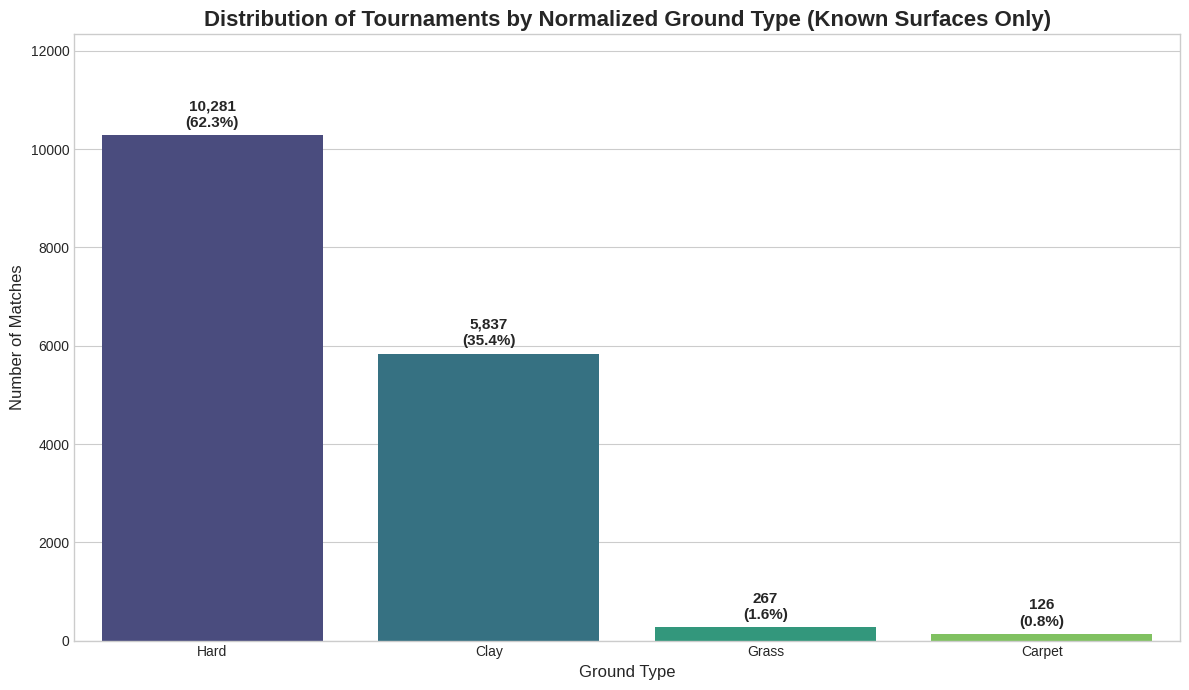

In [25]:
def analyze_most_common_ground_type_combined(data_path):
    """
    تحلیل نهایی رایج‌ترین نوع زمین با یکتاسازی مسابقات و نرمال‌سازی نوع زمین.
    """
    print("=" * 80)
    print("🏟️ تحلیل رایج‌ترین نوع سطح زمین (نسخه نهایی و بهینه)")
    print("=" * 80)

    # --- توابع کمکی ---
    def latest_per_match(df, key='match_id'):
        if 'source_date' in df.columns:
            return df.sort_values([key, 'source_date']).drop_duplicates(subset=[key], keep='last')
        return df.drop_duplicates(subset=[key], keep='last')
    
    # ✅ تابع نرمال‌سازی از کد ۲
    def norm_surface(x):
        if not isinstance(x, str): return 'Unknown'
        s = x.strip().lower()
        if "hard" in s: return "Hard"
        if "clay" in s: return "Clay"
        if "grass" in s: return "Grass"
        if "carpet" in s: return "Carpet"
        return 'Unknown'

    # --- مرحله ۱: بارگذاری و پاکسازی اولیه ---
    print("\n📥 مرحله ۱: بارگذاری و پاکسازی اولیه...")
    try:
        tournament_df = pd.read_parquet(Path(data_path) / "tournament_complete.parquet")
    except FileNotFoundError as e:
        print(f"   ❌ خطا: {e}")
        return
    
    # استفاده از آخرین اسنپ‌شات برای هر مسابقه
    unique_matches_tournament = latest_per_match(tournament_df)
    print(f"   ✓ {len(unique_matches_tournament):,} مسابقه یکتا بارگذاری شد.")
    
    # --- مرحله ۲: نرمال‌سازی نوع زمین ---
    print("\n🧹 مرحله ۲: نرمال‌سازی نوع زمین...")
    
    # اعمال تابع نرمال‌سازی
    unique_matches_tournament['ground_type_normalized'] = unique_matches_tournament['ground_type'].apply(norm_surface)
    
    # --- مرحله ۳: شمارش و تحلیل توزیع ---
    print("\n📊 مرحله ۳: شمارش و تحلیل توزیع...")
    
    total_matches = len(unique_matches_tournament)
    ground_type_counts = unique_matches_tournament['ground_type_normalized'].value_counts()
    
    # جدا کردن داده‌های نامشخص برای گزارش‌دهی
    known_counts = ground_type_counts.drop('Unknown', errors='ignore')
    unknown_count = ground_type_counts.get('Unknown', 0)
    total_known = known_counts.sum()
    
    # محاسبه درصد بر اساس تعداد مسابقات با زمین مشخص
    known_percentage = (known_counts / total_known * 100) if total_known > 0 else pd.Series()
    
    results_df = pd.DataFrame({
        'Count': known_counts,
        'Percentage_of_Known': known_percentage
    }).sort_values(by='Count', ascending=False)
    
    # --- مرحله ۴: نمایش نتایج ---
    print("\n" + "=" * 80)
    print("🎯 نتیجه نهایی: توزیع انواع سطح زمین")
    print("=" * 80)
    
    if results_df.empty:
        print("❌ هیچ مسابقه‌ای با نوع زمین مشخص یافت نشد.")
        return None

    most_common_ground = results_df.index[0]
    print(f"🏆 **رایج‌ترین نوع سطح زمین (از بین موارد مشخص): {most_common_ground}**")
    print(f"   این نوع زمین {results_df.iloc[0]['Percentage_of_Known']:.1f}% از کل مسابقات با زمین مشخص را تشکیل می‌دهد.")
    print("-" * 50)
    
    print("📈 **آمار انواع زمین (بر اساس موارد مشخص):**")
    print(results_df.round(1).to_string())
    
    print("\n🔍 **کیفیت داده‌ها:**")
    print(f"   • تعداد کل مسابقات: {total_matches:,}")
    print(f"   • مسابقات با زمین مشخص: {total_known:,} ({total_known/total_matches:.1%})")
    print(f"   • مسابقات با زمین نامشخص: {unknown_count:,} ({unknown_count/total_matches:.1%})")
    
    print("\n" + "=" * 80)

    # --- مرحله ۵: ترسیم نمودار ---
    print("\n🎨 مرحله ۵: ترسیم نمودار توزیع...")
    
    plt.style.use('seaborn-v0_8-whitegrid')
    fig, ax = plt.subplots(figsize=(12, 7))
    
    palette = sns.color_palette("viridis", n_colors=len(results_df))
    
    bars = sns.barplot(x=results_df.index, y=results_df['Count'], ax=ax, palette=palette)
    
    for i, p in enumerate(ax.patches):
        count = int(p.get_height())
        percentage = results_df['Percentage_of_Known'].iloc[i]
        ax.annotate(f"{count:,}\n({percentage:.1f}%)", 
                    (p.get_x() + p.get_width() / 2., p.get_height()), 
                    ha='center', va='center', xytext=(0, 15), 
                    textcoords='offset points', fontweight='bold', fontsize=11)

    ax.set_title('Distribution of Tournaments by Normalized Ground Type (Known Surfaces Only)', fontsize=16, fontweight='bold')
    ax.set_xlabel('Ground Type', fontsize=12)
    ax.set_ylabel('Number of Matches', fontsize=12)
    ax.set_ylim(0, results_df['Count'].max() * 1.2)
    
    plt.tight_layout()
    plt.show()

    return results_df

# --- اجرای تابع تحلیل ---
data_path = Path("/home/mohammadreza77615/Desktop/Tennis Schema/Final_parquet")
ground_type_analysis_df_combined = analyze_most_common_ground_type_combined(data_path)

### سوال 15 : چند کشور متمایز در این مجموعه داده نماینده دارند؟

🌍 تحلیل تعداد کشورهای متمایز (بر اساس پروفایل یکتای بازیکنان)

📥 مرحله ۱: بارگذاری داده‌های بازیکنان...

👤 مرحله ۲: ایجاد پروفایل یکتای بازیکنان...
   ✓ 2,644 بازیکن یکتا شناسایی شد.

📊 مرحله ۳: شمارش کشورهای متمایز...

🎯 نتیجه نهایی: تعداد کشورهای متمایز
🌍 **تعداد کل کشورهای متمایز با حداقل یک بازیکن نماینده: 100 کشور**
--------------------------------------------------
   • تعداد کل بازیکنان با کشور مشخص: 2,644 نفر


🏆 20 کشور برتر از نظر تعداد بازیکن:
country
USA               225
Italy             205
France            202
Russia            137
Japan             124
Germany           121
Spain              98
Argentina          98
Australia          92
United Kingdom     85
Czech Republic     71
India              63
China              63
Romania            62
Brazil             58
Switzerland        55
Netherlands        49
Ukraine            41
Serbia             39
Poland             36

🎨 ترسیم نمودار...


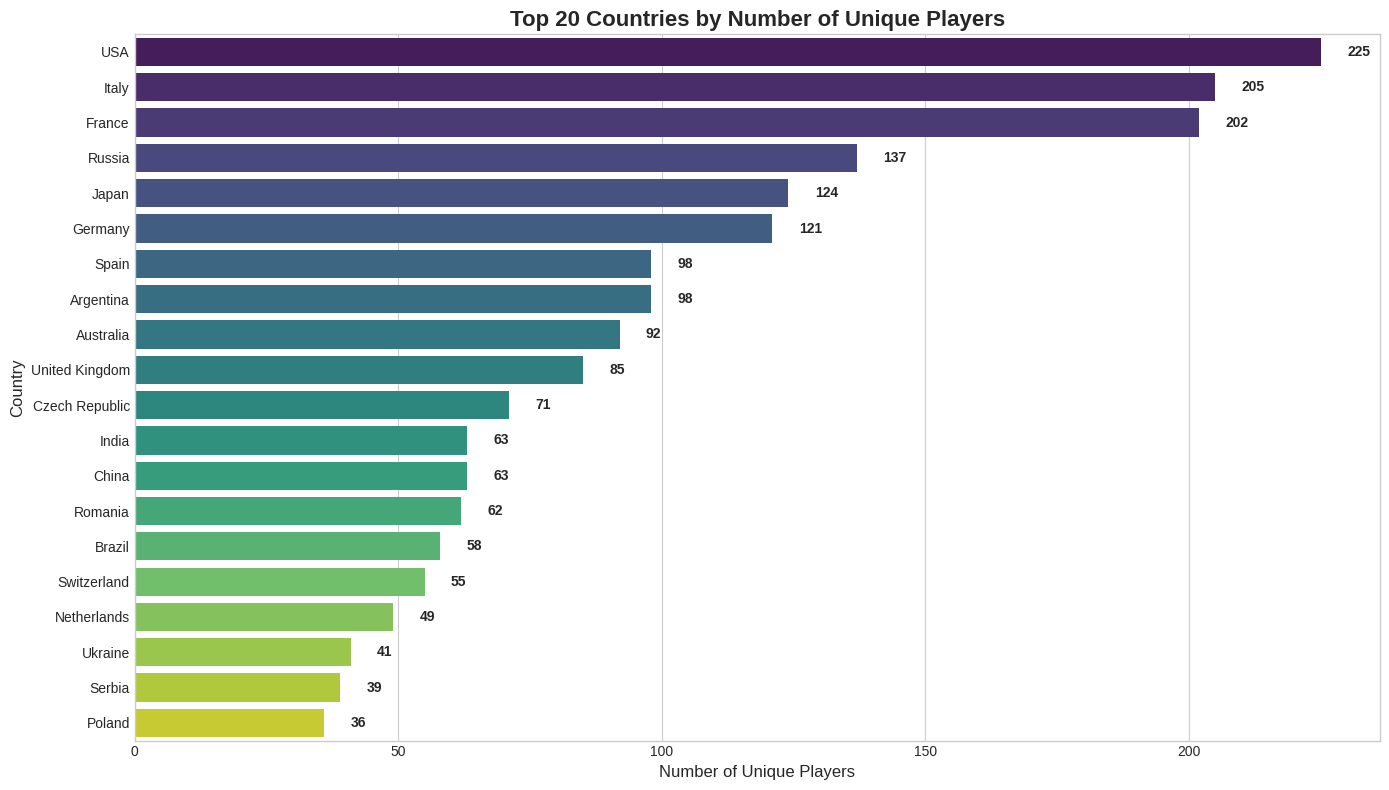

In [16]:

def mode_or_first(series):
    """
    برای هر گروه، رایج‌ترین مقدار (mode) را برمی‌گرداند.
    در صورت نبود mode یا تساوی، اولین مقدار غیر تهی را انتخاب می‌کند.
    """
    s = series.dropna()
    if s.empty:
        return np.nan
    m = s.mode()
    return m.iloc[0] if len(m) > 0 else s.iloc[0]

def analyze_distinct_countries(data_path, plot=True):
    """
    سوال 15: چند کشور متمایز در این مجموعه داده نماینده دارند؟
    رویکرد:
      - ایجاد پروفایل یکتای بازیکن از home_team و away_team.
      - برای هر بازیکن، کشور او بر اساس رایج‌ترین مقدار (mode) در تمام رکوردهایش تعیین می‌شود.
      - شمارش کشورهای یکتا از روی این پروفایل‌های تمیز شده.
      - گزارش کلی + 15 کشور برتر از نظر تعداد بازیکن.
    """
    print("=" * 80)
    print("🌍 تحلیل تعداد کشورهای متمایز (بر اساس پروفایل یکتای بازیکنان)")
    print("=" * 80)

    data_path = Path(data_path)

    # --- مرحله ۱: بارگذاری داده‌های بازیکنان ---
    print("\n📥 مرحله ۱: بارگذاری داده‌های بازیکنان...")
    try:
        home_team = pd.read_parquet(data_path / "home_team_complete.parquet")[['player_id', 'country']]
        away_team = pd.read_parquet(data_path / "away_team_complete.parquet")[['player_id', 'country']]
    except FileNotFoundError as e:
        print(f"   ❌ خطا: {e}")
        return

    # --- مرحله ۲: ایجاد پروفایل یکتای بازیکنان و پاکسازی ---
    print("\n👤 مرحله ۲: ایجاد پروفایل یکتای بازیکنان...")

    players = pd.concat([home_team, away_team], ignore_index=True)

    # پاکسازی شناسه بازیکن
    players['player_id'] = pd.to_numeric(players['player_id'], errors='coerce')
    players.dropna(subset=['player_id'], inplace=True)
    players['player_id'] = players['player_id'].astype(int)
    players = players[players['player_id'] > 0].copy()

    # پاکسازی نام کشور و پر کردن مقادیر خالی
    players['country'] = players['country'].str.strip().fillna('Unknown')

    # برای هر بازیکن، رایج‌ترین کشور ثبت‌شده برای او را به عنوان کشور نهایی در نظر می‌گیریم
    unique_players = (players.groupby('player_id')
                      .agg(country=('country', mode_or_first))
                      .reset_index())

    total_unique_players = len(unique_players)
    print(f"   ✓ {total_unique_players:,} بازیکن یکتا شناسایی شد.")

    # --- مرحله ۳: شمارش کشورهای متمایز ---
    print("\n📊 مرحله ۳: شمارش کشورهای متمایز...")

    country_counts = unique_players['country'].value_counts()

    # اصلاح شده: استفاده از .get() و .drop()
    unknown_country_count = int(country_counts.get('Unknown', 0))
    if 'Unknown' in country_counts.index:
        country_counts = country_counts.drop('Unknown')
    distinct_countries_count = len(country_counts)

    # --- مرحله ۴: نمایش نتایج ---
    print("\n" + "=" * 80)
    print("🎯 نتیجه نهایی: تعداد کشورهای متمایز")
    print("=" * 80)

    print(f"🌍 **تعداد کل کشورهای متمایز با حداقل یک بازیکن نماینده: {distinct_countries_count} کشور**")
    print("-" * 50)
    print(f"   • تعداد کل بازیکنان با کشور مشخص: {total_unique_players - unknown_country_count:,} نفر")
    if unknown_country_count > 0:
        print(f"   • تعداد بازیکنان با کشور نامشخص: {unknown_country_count:,} نفر")

    print("\n" + "=" * 80)

    # --- مرحله ۵: نمایش 20 کشور برتر و ترسیم نمودار ---
    if plot and not country_counts.empty:
        print("\n🏆 20 کشور برتر از نظر تعداد بازیکن:")
        top_20_countries = country_counts.head(20)
        print(top_20_countries.to_string())

        print("\n🎨 ترسیم نمودار...")
        plt.style.use('seaborn-v0_8-whitegrid')
        fig, ax = plt.subplots(figsize=(14, 8))

        # ✅ اصلاح کلیدی: rename کردن صحیح با استفاده از 'count' به جای 'country'
        plot_data = top_20_countries.reset_index()
        plot_data.columns = ['Country', 'Player Count']  # روش دیگر برای rename
        
        
        palette = sns.color_palette("viridis", n_colors=len(plot_data))

        sns.barplot(
            x='Player Count',
            y='Country',
            data=plot_data,
            ax=ax,
            palette=palette,
            orient='h'
        )

        ax.set_title('Top 20 Countries by Number of Unique Players', fontsize=16, fontweight='bold')
        ax.set_xlabel('Number of Unique Players', fontsize=12)
        ax.set_ylabel('Country', fontsize=12)

        for p in ax.patches:
            width = p.get_width()
            ax.text(width + 5,
                    p.get_y() + p.get_height() / 2,
                    f'{int(width):,}',
                    va='center',
                    fontweight='bold')

        plt.tight_layout()
        plt.show()

    return {
        'total_distinct_countries': int(distinct_countries_count),
        'players_with_unknown_country': int(unknown_country_count),
        'country_counts': country_counts
    }

# --- اجرای تابع تحلیل ---
data_path = Path("/home/mohammadreza77615/Desktop/Tennis Schema/Final_parquet")
country_analysis_results = analyze_distinct_countries(data_path)

### سوال 16 : کدام بازیکن بالاترین درصد پیروزی را در برابر حریفان رنکینگِ Top-10 دارد؟

In [27]:
def analyze_performance_vs_top10_fixed(data_path, min_matches=3):
    """
    تحلیل عملکرد بازیکنان در برابر حریفان Top 10 - نسخه اصلاح شده
    (افزوده شد: فیلتر اعتبار ست‌ها؛ هر ست بین 15 تا 60 دقیقه و 6 تا 16 گیم)
    """
    print("="*80)
    print("🏆 Analysis: Player with Highest Win Rate vs. Top 10 Opponents")
    print(f"(Minimum {min_matches} matches required for ranking)")
    print("="*80)

    # --- مرحله 1: بارگذاری داده‌ها ---
    print("\n🔄 Step 1: Loading Data...")
    try:
        home_team = pd.read_parquet(Path(data_path) / "home_team_complete.parquet")
        away_team = pd.read_parquet(Path(data_path) / "away_team_complete.parquet")
        event = pd.read_parquet(Path(data_path) / "event_complete.parquet")
        time_df = pd.read_parquet(Path(data_path) / "time_complete.parquet")
        home_score = pd.read_parquet(Path(data_path) / "home_team_score_complete.parquet")
        away_score = pd.read_parquet(Path(data_path) / "away_team_score_complete.parquet")
    except FileNotFoundError as e:
        print(f"   ❌ Error: {e}")
        return

    print(f"   ✓ Loaded - event: {len(event):,}, home_team: {len(home_team):,}, away_team: {len(away_team):,}")

    # --- مرحله 2: ترکیب جداول ---
    print("\n🔗 Step 2: Merging DataFrames...")
    
    matches_df = event.merge(
        home_team[['match_id', 'player_id', 'name', 'current_rank']],
        on='match_id', how='left'
    ).rename(columns={'player_id': 'home_id', 'name': 'home_name', 'current_rank': 'home_rank'})
    
    matches_df = matches_df.merge(
        away_team[['match_id', 'player_id', 'name', 'current_rank']],
        on='match_id', how='left'
    ).rename(columns={'player_id': 'away_id', 'name': 'away_name', 'current_rank': 'away_rank'})
    
    matches_df = matches_df.merge(time_df, on='match_id', how='left')
    matches_df = matches_df.merge(home_score, on='match_id', how='left', suffixes=('', '_hscore'))
    matches_df = matches_df.merge(away_score, on='match_id', how='left', suffixes=('', '_ascore'))
    
    print(f"   ✓ Total matches after merge: {len(matches_df):,}")

    # --- مرحله 3: پاکسازی داده‌ها ---
    print("\n🧹 Step 3: Data Cleaning...")
    
    # حذف تکراری‌ها
    initial_count = len(matches_df)
    matches_df = matches_df.drop_duplicates(subset=['match_id'], keep='first')
    print(f"   • Duplicates removed: {initial_count - len(matches_df):,} (Remaining: {len(matches_df):,})")

    # فیلتر زمان کل مسابقه
    if 'period_1' in matches_df.columns and 'period_2' in matches_df.columns:
        initial_count = len(matches_df)
        matches_df['total_seconds'] = matches_df[['period_1', 'period_2', 'period_3']].sum(axis=1, skipna=True)
        
        MIN_MATCH_SECONDS = 30 * 60  # 30 دقیقه
        MAX_MATCH_SECONDS = 3 * 60 * 60  # 3 ساعت 

        time_filter = (
            matches_df['total_seconds'].isna() |
            ((matches_df['total_seconds'] >= MIN_MATCH_SECONDS) & 
             (matches_df['total_seconds'] <= MAX_MATCH_SECONDS))
        )
        matches_df = matches_df[time_filter].copy()
        print(f"   • Time filter applied: {initial_count - len(matches_df):,} removed (Remaining: {len(matches_df):,})")
    else:
        print("   • Time columns not found, skipping time filter")

    # ✅ فیلتر اعتبار ست‌ها (هر ست: 15–60 دقیقه و 6–16 گیم) و الزام حداقل 2 ست معتبر
    print("   • Applying per-set validity filter (15–60 min and 6–16 games per set, need ≥2 valid sets)...")
    initial_count = len(matches_df)

    def set_valid(row, t_col, h_col, a_col):
        t = row.get(t_col); h = row.get(h_col); a = row.get(a_col)
        if pd.isna(t) or pd.isna(h) or pd.isna(a):
            return False
        minutes = t / 60.0
        games = h + a
        return (15 <= minutes <= 60) and (6 <= games <= 16)

    # نام ستون‌ها مطابق merge فعلی:
    # زمان هر ست: period_1, period_2, period_3 (از time)
    # گیم‌های هر ست: period_1_hscore/period_2_hscore/period_3_hscore (home) و period_1_ascore/... (away)
    matches_df['s1_valid'] = matches_df.apply(lambda r: set_valid(r, 'period_1', 'period_1_hscore', 'period_1_ascore'), axis=1)
    matches_df['s2_valid'] = matches_df.apply(lambda r: set_valid(r, 'period_2', 'period_2_hscore', 'period_2_ascore'), axis=1)
    matches_df['s3_valid'] = matches_df.apply(lambda r: set_valid(r, 'period_3', 'period_3_hscore', 'period_3_ascore'), axis=1)

    matches_df['valid_sets_count'] = matches_df[['s1_valid','s2_valid','s3_valid']].sum(axis=1)
    matches_df = matches_df[matches_df['valid_sets_count'] >= 2].copy()
    print(f"   • Set-level filter applied: {initial_count - len(matches_df):,} removed (Remaining: {len(matches_df):,})")

    # فیلتر امتیازات 
    score_columns_home = ['period_1', 'period_2']              # از home_score در کد اصلی
    score_columns_away = ['period_1_ascore', 'period_2_ascore']  # از away_score
    
    initial_count = len(matches_df)
    if all(col in matches_df.columns for col in score_columns_home + score_columns_away):
        matches_df = matches_df.dropna(subset=score_columns_home + score_columns_away)
        print(f"   • Score filter applied: {initial_count - len(matches_df):,} removed (Remaining: {len(matches_df):,})")
    else:
        print("   • Some score columns missing, using partial filter")
        if 'winner_code' in matches_df.columns:
            matches_df = matches_df[matches_df['winner_code'].isin([1.0, 2.0])]
            print(f"   • Winner code filter applied (partial). Remaining: {len(matches_df):,}")

    # فیلتر رنک‌ها 
    initial_count = len(matches_df)
    matches_df = matches_df.dropna(subset=['home_rank', 'away_rank'])
    matches_df = matches_df[(matches_df['home_rank'] > 0) & (matches_df['away_rank'] > 0)]
    print(f"   • Rank filter applied: {initial_count - len(matches_df):,} removed (Remaining: {len(matches_df):,})")
    
    print(f"   ✓ Final cleaned dataset: {len(matches_df):,} matches")

    # --- مرحله 4: شناسایی مسابقات vs Top 10 ---
    print("\n🎯 Step 4: Identifying Matches Against Top 10...")
    
    home_view = matches_df.copy()
    home_view['player_id'] = home_view['home_id']
    home_view['player_name'] = home_view['home_name']
    home_view['opponent_rank'] = home_view['away_rank']
    home_view['is_winner'] = (home_view['winner_code'] == 1)

    away_view = matches_df.copy()
    away_view['player_id'] = away_view['away_id']
    away_view['player_name'] = away_view['away_name']
    away_view['opponent_rank'] = matches_df['home_rank']  # نگه‌داشت منطق اصلاح شده
    away_view['is_winner'] = (away_view['winner_code'] == 2)
    
    player_centric_df = pd.concat([home_view, away_view], ignore_index=True)
    
    initial_count = len(player_centric_df)
    vs_top10_df = player_centric_df[player_centric_df['opponent_rank'] <= 10].copy()
    print(f"   • Total player-match records: {initial_count:,}")
    print(f"   • Matches vs Top 10: {len(vs_top10_df):,}")
    
    if len(vs_top10_df) > 0:
        print("\n   📋 Sample matches vs Top 10:")
        sample = vs_top10_df[['player_name', 'opponent_rank', 'is_winner']].head(5)
        print(sample.to_string(index=False))

    # --- مرحله 5: محاسبه آمار ---
    print("\n📈 Step 5: Calculating Statistics...")
    
    if len(vs_top10_df) == 0:
        print("   ❌ No matches against Top 10 found!")
        return None
    
    stats_vs_top10 = vs_top10_df.groupby(['player_id', 'player_name']).agg(
        wins_vs_top10=('is_winner', 'sum'),
        total_matches_vs_top10=('match_id', 'count')
    ).reset_index()
    
    stats_vs_top10['win_rate_vs_top10'] = (
        stats_vs_top10['wins_vs_top10'] / stats_vs_top10['total_matches_vs_top10'] * 100
    )

    # --- مرحله 6: رتبه‌بندی و نمایش ---
    print("\n🏆 Step 6: Final Ranking...")
    
    qualified_players = stats_vs_top10[
        stats_vs_top10['total_matches_vs_top10'] >= min_matches
    ].copy()
    
    print(f"   • Players with {min_matches}+ matches: {len(qualified_players):,}")
    
    if qualified_players.empty:
        print(f"\n⚠️ No players with minimum {min_matches} matches")
        print("\nShowing all players regardless of match count:")
        all_players = stats_vs_top10.sort_values('win_rate_vs_top10', ascending=False).head(10)
        all_players['Rank'] = range(1, len(all_players) + 1)
        print(all_players[['Rank', 'player_name', 'win_rate_vs_top10', 'wins_vs_top10', 'total_matches_vs_top10']].to_string(index=False))
        return stats_vs_top10
    
    final_ranking = qualified_players.sort_values(
        by=['win_rate_vs_top10', 'wins_vs_top10'],
        ascending=[False, False]
    ).reset_index(drop=True)
    
    print("\n" + "="*80)
    print(f"📊 Top 20 Players vs Top 10 (min. {min_matches} matches)")
    print("="*80)
    
    final_ranking['Rank'] = range(1, len(final_ranking) + 1)
    report_df = final_ranking[['Rank', 'player_name', 'win_rate_vs_top10', 'wins_vs_top10', 'total_matches_vs_top10']].head(20)
    report_df.columns = ['Rank', 'Player', 'Win Rate (%)', 'Wins', 'Total']
    print(report_df.to_string(index=False, formatters={'Win Rate (%)': '{:.1f}%'.format}))
    
    if not final_ranking.empty:
        top_player = final_ranking.iloc[0]
        print("\n" + "-"*50)
        print("🥇 Champion:")
        print(f"   • Name: {top_player['player_name']}")
        print(f"   • Win Rate vs Top 10: {top_player['win_rate_vs_top10']:.1f}%")
        print(f"   • Record: {int(top_player['wins_vs_top10'])} wins from {int(top_player['total_matches_vs_top10'])} matches")
        print("-"*50)
    
    return final_ranking

# اجرا
data_path = Path("/home/mohammadreza77615/Desktop/Tennis Schema/Final_parquet")
result = analyze_performance_vs_top10_fixed(data_path, min_matches=1)

🏆 Analysis: Player with Highest Win Rate vs. Top 10 Opponents
(Minimum 1 matches required for ranking)

🔄 Step 1: Loading Data...
   ✓ Loaded - event: 35,338, home_team: 25,883, away_team: 24,472

🔗 Step 2: Merging DataFrames...
   ✓ Total matches after merge: 1,916,032

🧹 Step 3: Data Cleaning...
   • Duplicates removed: 1,899,159 (Remaining: 16,873)
   • Time filter applied: 6,981 removed (Remaining: 9,892)
   • Applying per-set validity filter (15–60 min and 6–16 games per set, need ≥2 valid sets)...
   • Set-level filter applied: 2,095 removed (Remaining: 7,797)
   • Score filter applied: 0 removed (Remaining: 7,797)
   • Rank filter applied: 1,817 removed (Remaining: 5,980)
   ✓ Final cleaned dataset: 5,980 matches

🎯 Step 4: Identifying Matches Against Top 10...
   • Total player-match records: 11,960
   • Matches vs Top 10: 174

   📋 Sample matches vs Top 10:
   player_name  opponent_rank  is_winner
      Fomin S.            8.0      False
      Orlov V.           10.0      Fals

### سوال 17 : میانگین تعداد بریک سرویس (breaks of serve) در هر مسابقه چقدر است؟

🎯 Average breaks of serve per match (valid matches only)
  • Removed (no winner_code): 607
  • Removed (<2 valid sets): 7,728
  ✓ Valid matches used: 8,538

📈 Results:
  • Overall mean breaks/match:   6.86
  • Overall median breaks/match: 6.00
  • Men   → n=4,161,   mean=5.99, median=5.00
  • Women → n=3,340, mean=8.02, median=7.00


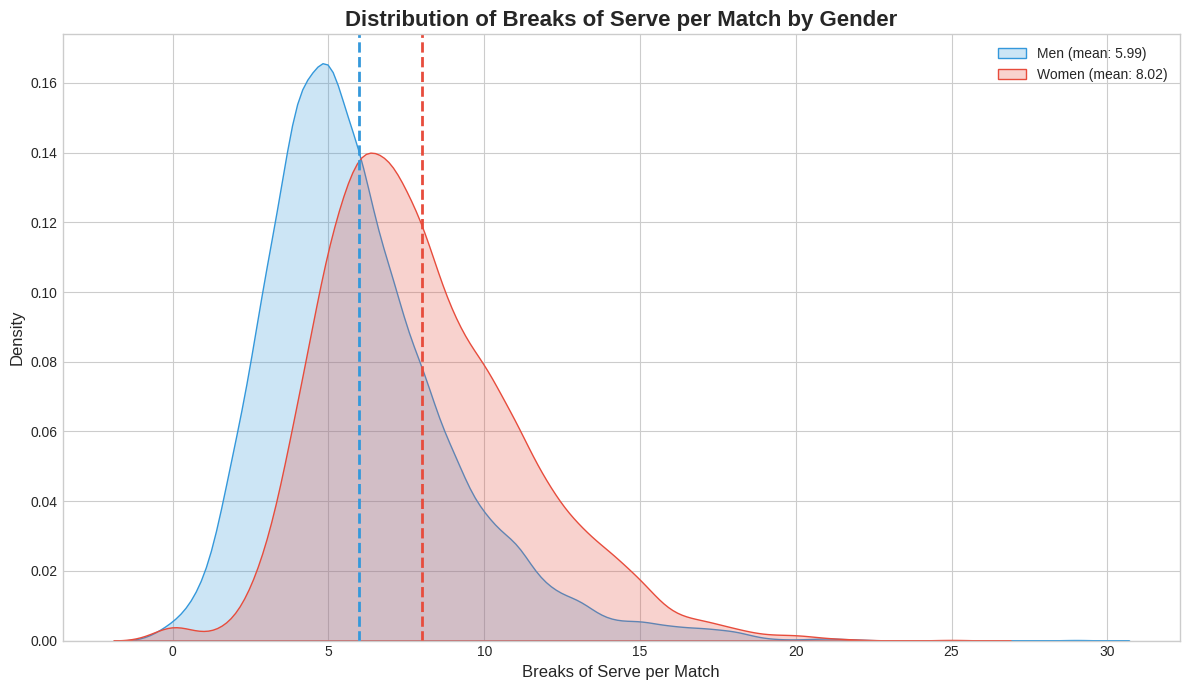

In [5]:
# --- Snapshot helpers ---
def latest_per_match(df, key='match_id'):
    """Pick last snapshot per match (by largest source_date) for metadata-like tables."""
    if 'source_date' in df.columns:
        return df.sort_values([key, 'source_date']).drop_duplicates(subset=[key], keep='last')
    return df.drop_duplicates(subset=[key], keep='last')

def pick_best_snapshot(df, key, priority_cols):
    """Pick best snapshot per match: most non-null across priority_cols; tie → latest source_date."""
    d = df.copy()
    d['_nn'] = d[priority_cols].notna().sum(axis=1)
    sort_cols = [key, '_nn']
    ascending = [True, True]
    if 'source_date' in d.columns:
        sort_cols.append('source_date'); ascending.append(True)
    d = d.sort_values(sort_cols)
    best = d.drop_duplicates(subset=[key], keep='last').drop(columns=['_nn'])
    return best

def analyze_average_breaks_per_match(data_path, plot=True):
    """
    میانگین تعداد بریک سرویس (breaks of serve) در هر مسابقه معتبر:
      - مسابقه معتبر: winner_code مشخص + حداقل 2 ست معتبر
      - ست معتبر: 15–60 دقیقه و 6–16 گیم
      - زمان مسابقه از time و گیم‌ها از home/away_score
      - بریک‌ها از جدول power: شمارش break_occurred=True به‌ازای هر مسابقه (پس از ددویپلیکیت بر اساس (match_id,set_num,game_num))
      - گزارش کلی و به تفکیک جنسیت
    """
    data_path = Path(data_path)

    # 1) Load
    event   = pd.read_parquet(data_path / "event_complete.parquet")
    time_df = pd.read_parquet(data_path / "time_complete.parquet")
    hscore  = pd.read_parquet(data_path / "home_team_score_complete.parquet")
    ascore  = pd.read_parquet(data_path / "away_team_score_complete.parquet")
    power   = pd.read_parquet(data_path / "power_complete.parquet")
    home_tm = pd.read_parquet(data_path / "home_team_complete.parquet")

    # 2) Snapshots
    event     = latest_per_match(event)
    time_best = pick_best_snapshot(time_df, 'match_id', ['period_1','period_2','period_3'])
    h_best    = pick_best_snapshot(hscore,  'match_id', ['period_1','period_2','period_3'])
    a_best    = pick_best_snapshot(ascore,  'match_id', ['period_1','period_2','period_3'])
    home_tm   = latest_per_match(home_tm)

    # Power: ددویپلیکیت بر اساس (match_id,set_num,game_num) و نگه‌داشتن آخرین snapshot
    if 'source_date' in power.columns:
        power_dedup = (power.sort_values(['match_id','set_num','game_num','source_date'])
                            .drop_duplicates(subset=['match_id','set_num','game_num'], keep='last'))
    else:
        power_dedup = power.drop_duplicates(subset=['match_id','set_num','game_num'], keep='last')

    # 3) Valid match filter (winner_code + ≥2 valid sets)
    t = time_best[['match_id','period_1','period_2','period_3']].rename(
        columns={'period_1':'t1','period_2':'t2','period_3':'t3'}
    )
    hs = h_best[['match_id','period_1','period_2','period_3']].rename(
        columns={'period_1':'h1','period_2':'h2','period_3':'h3'}
    )
    a  = a_best[['match_id','period_1','period_2','period_3']].rename(
        columns={'period_1':'a1','period_2':'a2','period_3':'a3'}
    )

    df = (event[['match_id','winner_code']]
          .merge(t,  on='match_id', how='left')
          .merge(hs, on='match_id', how='left')
          .merge(a,  on='match_id', how='left'))

    for c in ['t1','t2','t3','h1','h2','h3','a1','a2','a3']:
        df[c] = pd.to_numeric(df[c], errors='coerce')

    def set_valid(tsec, hg, ag):
        if pd.isna(tsec) or pd.isna(hg) or pd.isna(ag): 
            return False
        m = tsec / 60.0
        g = hg + ag
        return (15 <= m <= 60) and (6 <= g <= 16)

    df['s1'] = df.apply(lambda r: set_valid(r['t1'], r['h1'], r['a1']), axis=1)
    df['s2'] = df.apply(lambda r: set_valid(r['t2'], r['h2'], r['a2']), axis=1)
    df['s3'] = df.apply(lambda r: set_valid(r['t3'], r['h3'], r['a3']), axis=1)
    df['valid_sets'] = df[['s1','s2','s3']].sum(axis=1)

    before = len(df)
    df = df[df['winner_code'].isin([1.0, 2.0])]
    after_w = len(df)
    df = df[df['valid_sets'] >= 2].copy()
    after_v = len(df)

    print("="*80)
    print("🎯 Average breaks of serve per match (valid matches only)")
    print("="*80)
    print(f"  • Removed (no winner_code): {before - after_w:,}")
    print(f"  • Removed (<2 valid sets): {after_w - after_v:,}")
    print(f"  ✓ Valid matches used: {len(df):,}")

    if df.empty:
        print("\n⚠️ No valid matches found under the rules.")
        return None

    # 4) Breaks per match from power
    # ensure boolean
    if power_dedup['break_occurred'].dtype != bool:
        power_dedup['break_occurred'] = power_dedup['break_occurred'].astype(bool)

    breaks_per_match = (power_dedup.groupby('match_id')['break_occurred']
                        .sum()
                        .reset_index(name='breaks'))

    # Keep only valid matches; missing breaks → 0
    out = df[['match_id']].merge(breaks_per_match, on='match_id', how='left')
    out['breaks'] = out['breaks'].fillna(0).astype(int)

    # 5) Overall stats and by gender
    overall_mean = out['breaks'].mean()
    overall_median = out['breaks'].median()

    # Gender from home_team (as in previous answers)
    out_g = out.merge(home_tm[['match_id','gender']], on='match_id', how='left')
    men = out_g[out_g['gender'] == 'M']['breaks']
    women = out_g[out_g['gender'] == 'F']['breaks']

    print("\n📈 Results:")
    print(f"  • Overall mean breaks/match:   {overall_mean:.2f}")
    print(f"  • Overall median breaks/match: {overall_median:.2f}")
    print(f"  • Men   → n={len(men):,},   mean={men.mean():.2f}, median={men.median():.2f}")
    print(f"  • Women → n={len(women):,}, mean={women.mean():.2f}, median={women.median():.2f}")

    # 6) Optional plot
    if plot:
        plt.style.use('seaborn-v0_8-whitegrid')
        fig, ax = plt.subplots(figsize=(12,7))
        if len(men) > 0:
            sns.kdeplot(data=men, fill=True, color='#3498db', label=f"Men (mean: {men.mean():.2f})", ax=ax)
            ax.axvline(men.mean(), color='#3498db', linestyle='--', linewidth=2)
        if len(women) > 0:
            sns.kdeplot(data=women, fill=True, color='#e74c3c', label=f"Women (mean: {women.mean():.2f})", ax=ax)
            ax.axvline(women.mean(), color='#e74c3c', linestyle='--', linewidth=2)
        ax.set_title('Distribution of Breaks of Serve per Match by Gender', fontsize=16, fontweight='bold')
        ax.set_xlabel('Breaks of Serve per Match', fontsize=12)
        ax.set_ylabel('Density', fontsize=12)
        ax.legend()
        plt.tight_layout()
        plt.show()

    return {
        'matches_used': int(len(out)),
        'overall_mean_breaks': float(overall_mean),
        'overall_median_breaks': float(overall_median),
        'by_gender': {
            'men':   {'n': int(len(men)),   'mean': float(men.mean()) if len(men) else np.nan, 'median': float(men.median()) if len(men) else np.nan},
            'women': {'n': int(len(women)), 'mean': float(women.mean()) if len(women) else np.nan, 'median': float(women.median()) if len(women) else np.nan},
        },
        'per_match': out[['match_id','breaks']]
    }

# نمونه اجرا:
data_path = "/home/mohammadreza77615/Desktop/Tennis Schema/Final_parquet"
res = analyze_average_breaks_per_match(data_path, plot=True)

# تحلیل و بررسی بیشتر :

### سوال 1 : پادشاهان بازگشت (Comeback Kings/Queens): چند درصد مسابقات با بازگشت همراه بوده‌اند و کدام بازیکنان در این زمینه بهترین هستند؟


🏆 ═══════════════════════════════ TENNIS COMEBACK ANALYSIS REPORT ════════════════════════════════ 🏆

🥇 COMEBACK CHAMPION
──────────────────────────────────────────────────

    ╔════════════════════════════════════════════════════════════╗
    ║  👑 Salle F.                                               ║
    ╠════════════════════════════════════════════════════════════╣
    ║  🔄 Successful Comebacks: 7                                ║
    ║  📊 Total Opportunities: 11                                ║
    ║  📈 Success Rate: 63.6%                                    ║
    ║  🏅 Efficiency Rating: 4.5                                 ║
    ╚════════════════════════════════════════════════════════════╝
    

📋 TOP 15 COMEBACK SPECIALISTS
────────────────────────────────────────────────────────────────────────────────────────────────────
╒════════╤═══════════════════╤════════╤═══════════╤════════╤═════════╕
│ Rank   │ Player Name       │  Wins  │  Chances  │ Rate   │  Score  │
╞════════╪═════

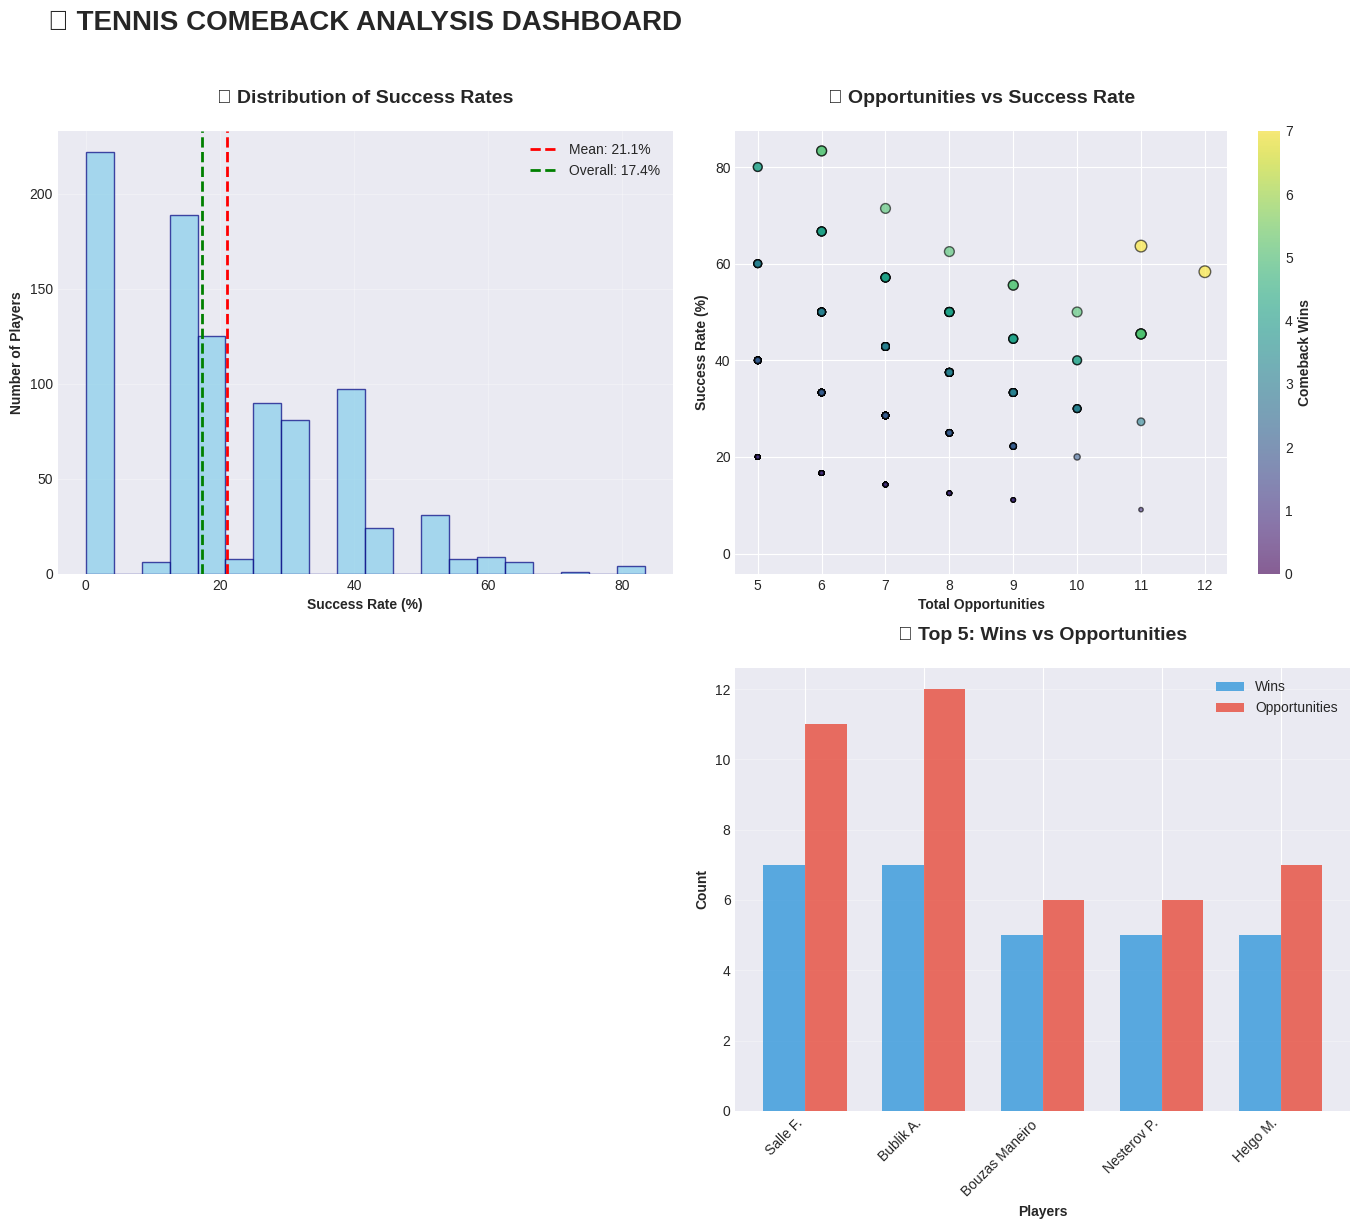

In [18]:
# --- توابع کمکی (Best Practices) ---
def latest_per_match(df, key='match_id'):
    if 'source_date' in df.columns:
        return df.sort_values([key, 'source_date']).drop_duplicates(subset=[key], keep='last')
    return df.drop_duplicates(subset=[key], keep='last')

def pick_best_snapshot(df, key, priority_cols):
    d = df.copy()
    d['_nn'] = d[priority_cols].notna().sum(axis=1)
    sort_cols = [key, '_nn']; ascending = [True, True]
    if 'source_date' in d.columns:
        sort_cols.append('source_date'); ascending.append(True)
    best = d.sort_values(sort_cols).drop_duplicates(subset=[key], keep='last').drop(columns=['_nn'])
    return best

def infer_singles_soft(df):
    if 'competition_type' in df.columns:
        comp = df['competition_type']
        is_singles_explicit = (comp == 1.0)
        is_doubles_explicit = (comp == 2.0)
    else:
        is_singles_explicit = pd.Series(False, index=df.index)
        is_doubles_explicit = pd.Series(False, index=df.index)
    
    tournament_name = df.get('tournament_name', pd.Series('', index=df.index)).astype(str).str.lower()
    season_name = df.get('season_name', pd.Series('', index=df.index)).astype(str).str.lower()
    combined_text = tournament_name + ' ' + season_name
    
    contains_doubles = combined_text.str.contains('double|dbl|doubles', na=False, regex=True)
    contains_singles = combined_text.str.contains('single|singles', na=False, regex=True)
    
    is_singles = (
        is_singles_explicit |
        (contains_singles & ~contains_doubles) |
        (~is_doubles_explicit & ~contains_doubles & ~contains_singles)
    )
    return is_singles

def create_professional_visualizations(final_ranking, comeback_percentage, min_comeback_opportunities):
    """
    ایجاد نمودارهای حرفه‌ای برای نمایش نتایج
    """
    # تنظیمات استایل
    plt.style.use('seaborn-v0_8-darkgrid')
    sns.set_palette("husl")
    
    # ایجاد figure با subplots
    fig = plt.figure(figsize=(20, 12))
    fig.suptitle('🎾 TENNIS COMEBACK ANALYSIS DASHBOARD', fontsize=20, fontweight='bold', y=1.02)
    
    # رنگ‌های سفارشی
    colors = plt.cm.Set3(np.linspace(0, 1, 10))
    
    
    # --- نمودار 2: توزیع درصد موفقیت ---
    ax2 = plt.subplot(2, 3, 2)
    ax2.hist(final_ranking['comeback_rate'], bins=20, color='skyblue', edgecolor='navy', alpha=0.7)
    ax2.axvline(final_ranking['comeback_rate'].mean(), color='red', linestyle='--', 
                linewidth=2, label=f'Mean: {final_ranking["comeback_rate"].mean():.1f}%')
    ax2.axvline(comeback_percentage, color='green', linestyle='--', 
                linewidth=2, label=f'Overall: {comeback_percentage:.1f}%')
    ax2.set_xlabel('Success Rate (%)', fontweight='bold')
    ax2.set_ylabel('Number of Players', fontweight='bold')
    ax2.set_title('📊 Distribution of Success Rates', fontsize=14, fontweight='bold', pad=20)
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    # --- نمودار 3: رابطه بین فرصت‌ها و درصد موفقیت ---
    ax3 = plt.subplot(2, 3, 3)
    scatter = ax3.scatter(final_ranking['comeback_opportunities'], 
                         final_ranking['comeback_rate'],
                         s=final_ranking['comeback_wins']*10,
                         c=final_ranking['comeback_wins'],
                         cmap='viridis', alpha=0.6, edgecolors='black', linewidth=1)
    ax3.set_xlabel('Total Opportunities', fontweight='bold')
    ax3.set_ylabel('Success Rate (%)', fontweight='bold')
    ax3.set_title('🎯 Opportunities vs Success Rate', fontsize=14, fontweight='bold', pad=20)
    
    # Colorbar
    cbar = plt.colorbar(scatter, ax=ax3)
    cbar.set_label('Comeback Wins', fontweight='bold')
    
    
    # --- نمودار 6: Top 5 مقایسه جامع ---
    ax6 = plt.subplot(2, 3, 6)
    top_5 = final_ranking.head(5)
    
    x = np.arange(len(top_5))
    width = 0.35
    
    bars1 = ax6.bar(x - width/2, top_5['comeback_wins'], width, 
                    label='Wins', color='#3498db', alpha=0.8)
    bars2 = ax6.bar(x + width/2, top_5['comeback_opportunities'], width,
                    label='Opportunities', color='#e74c3c', alpha=0.8)
    
    ax6.set_xlabel('Players', fontweight='bold')
    ax6.set_ylabel('Count', fontweight='bold')
    ax6.set_title('🏅 Top 5: Wins vs Opportunities', fontsize=14, fontweight='bold', pad=20)
    ax6.set_xticks(x)
    ax6.set_xticklabels([name[:15] for name in top_5['player_name'].values], rotation=45, ha='right')
    ax6.legend()
    ax6.grid(True, alpha=0.3, axis='y')
    
    plt.tight_layout()
    plt.show()

def display_professional_results(final_ranking, comeback_percentage, min_comeback_opportunities):
    """
    نمایش حرفه‌ای نتایج با جداول زیبا و آمار تفصیلی
    """
    
    print("\n" + "=" * 100)
    print("🏆 " + " TENNIS COMEBACK ANALYSIS REPORT ".center(96, "═") + " 🏆")
    print("=" * 100)
    
    # --- بخش 2: قهرمان بازگشت ---
    top_player = final_ranking.iloc[0]
    print("\n🥇 COMEBACK CHAMPION")
    print("─" * 50)
    
    champion_card = f"""
    ╔{'═' * 60}╗
    ║  👑 {top_player['player_name']:<54} ║
    ╠{'═' * 60}╣
    ║  🔄 Successful Comebacks: {int(top_player['comeback_wins']):<32} ║
    ║  📊 Total Opportunities: {int(top_player['comeback_opportunities']):<33} ║
    ║  📈 Success Rate: {top_player['comeback_rate']:.1f}%{' ' * (59 - 19 - len(f"{top_player['comeback_rate']:.1f}"))}║
    ║  🏅 Efficiency Rating: {(top_player['comeback_rate']/100 * top_player['comeback_wins']):.1f}{' ' * (60 - 24 - len(f"{(top_player['comeback_rate']/100 * top_player['comeback_wins']):.1f}"))}║
    ╚{'═' * 60}╝
    """
    print(champion_card)
    
    # --- بخش 3: جدول 15 بازیکن برتر ---
    print("\n📋 TOP 15 COMEBACK SPECIALISTS")
    print("─" * 100)
    
    top_15 = final_ranking.head(15).copy()
    
    # رنگ‌بندی رتبه‌ها
    def rank_emoji(rank):
        if rank == 1: return "🥇"
        elif rank == 2: return "🥈"
        elif rank == 3: return "🥉"
        else: return f"{rank:2d}"
    
    top_15.insert(0, 'Rank', range(1, len(top_15) + 1))
    top_15['Rank'] = top_15['Rank'].apply(rank_emoji)
    top_15['Success Rate'] = top_15['comeback_rate'].apply(lambda x: f"{x:.1f}%")
    top_15['Efficiency'] = (top_15['comeback_rate']/100 * top_15['comeback_wins']).apply(lambda x: f"{x:.1f}")
    
    table_data = top_15[['Rank', 'player_name', 'comeback_wins', 'comeback_opportunities', 
                         'Success Rate', 'Efficiency']].values.tolist()
    
    headers = ['Rank', 'Player Name', 'Wins', 'Chances', 'Rate', 'Score']
    print(tabulate(table_data, headers=headers, tablefmt='fancy_grid', 
                   numalign='center', stralign='left'))
    
    # --- بخش 4: تحلیل آماری ---
    print("\n📈 STATISTICAL INSIGHTS")
    print("─" * 50)
    
    mean_rate = final_ranking['comeback_rate'].mean()
    std_rate = final_ranking['comeback_rate'].std()
    median_rate = final_ranking['comeback_rate'].median()
    
    insights = f"""
    • Average Comeback Rate: {mean_rate:.1f}% (±{std_rate:.1f}%)
    • Median Comeback Rate: {median_rate:.1f}%
    • Top Performer vs Average: {(top_player['comeback_rate'] - mean_rate):.1f}% better
    • Elite Players (>40% rate): {len(final_ranking[final_ranking['comeback_rate'] > 40])} players
    • Consistent Performers (10+ wins): {len(final_ranking[final_ranking['comeback_wins'] >= 10])} players
    """
    print(insights)
    
    # --- بخش 5: توصیه‌های تحلیلی ---
    print("\n💡 KEY FINDINGS")
    print("─" * 50)
    
    # شناسایی بازیکنان خاص
    high_volume = final_ranking.nlargest(3, 'comeback_opportunities')
    high_rate = final_ranking.nlargest(3, 'comeback_rate')
    
    print("🔸 Volume Leaders (Most Opportunities):")
    for idx, player in high_volume.iterrows():
        print(f"   • {player['player_name']}: {int(player['comeback_opportunities'])} chances")
    
    print("\n🔸 Efficiency Leaders (Best Success Rate):")
    for idx, player in high_rate.iterrows():
        print(f"   • {player['player_name']}: {player['comeback_rate']:.1f}%")
    
    print("\n" + "=" * 100)
    print("📝 Report generated successfully | Analysis complete")
    print("=" * 100)

def analyze_comebacks_relaxed(data_path, min_comeback_opportunities=2):
    """
    سوال ۱ جدید: پادشاهان بازگشت (Comeback Kings/Queens) -
    """

    # --- مرحله ۱: بارگذاری داده‌ها و انتخاب بهترین اسنپ‌شات‌ها ---
    p = Path(data_path)
    event = latest_per_match(pd.read_parquet(p / "event_complete.parquet"))
    tournament = latest_per_match(pd.read_parquet(p / "tournament_complete.parquet"))
    season = latest_per_match(pd.read_parquet(p / "season_complete.parquet"))
    home_team = latest_per_match(pd.read_parquet(p / "home_team_complete.parquet"))
    away_team = latest_per_match(pd.read_parquet(p / "away_team_complete.parquet"))
    
    # برای این تحلیل، فقط امتیاز ست اول مهم است
    home_score = pick_best_snapshot(pd.read_parquet(p / "home_team_score_complete.parquet"), 'match_id', ['period_1'])
    away_score = pick_best_snapshot(pd.read_parquet(p / "away_team_score_complete.parquet"), 'match_id', ['period_1'])

    # --- مرحله ۲: ایجاد دیتافریم جامع و فیلترهای اولیه ---
    matches_df = event.merge(tournament, on="match_id", how="left", suffixes=("", "_tour"))
    matches_df = matches_df.merge(season.rename(columns={'name': 'season_name'}), on="match_id", how="left")
    
    initial_count = len(matches_df)
    singles_mask = infer_singles_soft(matches_df)
    matches_df = matches_df[singles_mask].copy()

    # --- مرحله ۳: فیلتر مسابقات معتبر  ---
    matches_df = matches_df.merge(home_score[['match_id', 'period_1']], on="match_id", how="left").rename(columns={'period_1': 'period_1_hscore'})
    matches_df = matches_df.merge(away_score[['match_id', 'period_1']], on="match_id", how="left").rename(columns={'period_1': 'period_1_ascore'})
    
    # شرط: برنده مشخص باشد و امتیاز ست اول موجود باشد
    initial_count = len(matches_df)
    valid_matches_df = matches_df[
        matches_df['winner_code'].isin([1.0, 2.0]) &
        matches_df['period_1_hscore'].notna() &
        matches_df['period_1_ascore'].notna() &
        (matches_df['period_1_hscore'] != matches_df['period_1_ascore']) # حذف walkover یا امتیازات ناقص
    ].copy()
    
    valid_matches_df = valid_matches_df.merge(home_team, on="match_id", how="left", suffixes=("", "_home"))
    valid_matches_df = valid_matches_df.merge(away_team, on="match_id", how="left", suffixes=("", "_away"))
    valid_matches_df.dropna(subset=['player_id', 'player_id_away'], inplace=True)

    # --- مراحل ۴، ۵ و ۶ ---
    valid_matches_df['home_lost_first_set'] = valid_matches_df['period_1_hscore'] < valid_matches_df['period_1_ascore']
    valid_matches_df['away_lost_first_set'] = valid_matches_df['period_1_hscore'] > valid_matches_df['period_1_ascore']
    valid_matches_df['is_comeback'] = ((valid_matches_df['winner_code'] == 1) & valid_matches_df['home_lost_first_set']) | ((valid_matches_df['winner_code'] == 2) & valid_matches_df['away_lost_first_set'])
    comeback_percentage = valid_matches_df['is_comeback'].mean() * 100
    
    home_view = valid_matches_df[['player_id', 'name', 'home_lost_first_set', 'winner_code']].rename(columns={'player_id': 'player_id', 'name': 'player_name', 'home_lost_first_set': 'lost_first_set'})
    home_view['won_match'] = home_view['winner_code'] == 1
    
    away_view = valid_matches_df[['player_id_away', 'name_away', 'away_lost_first_set', 'winner_code']].rename(columns={'player_id_away': 'player_id', 'name_away': 'player_name', 'away_lost_first_set': 'lost_first_set'})
    away_view['won_match'] = away_view['winner_code'] == 2
    
    player_centric_df = pd.concat([home_view, away_view], ignore_index=True).dropna(subset=['player_id'])
    player_stats = player_centric_df.groupby(['player_id', 'player_name']).agg(
        comeback_opportunities=('lost_first_set', 'sum'),
        comeback_wins=('won_match', lambda x: (player_centric_df.loc[x.index, 'lost_first_set'] & x).sum())
    ).reset_index()

    qualified_players = player_stats[player_stats['comeback_opportunities'] >= min_comeback_opportunities].copy()
    qualified_players['comeback_rate'] = (qualified_players['comeback_wins'] / qualified_players['comeback_opportunities'] * 100)
    final_ranking = qualified_players.sort_values(by=['comeback_wins', 'comeback_rate'], ascending=False)
    
    # نمایش حرفه‌ای نتایج
    display_professional_results(final_ranking, comeback_percentage, min_comeback_opportunities)
    
    # ایجاد نمودارها
    if not final_ranking.empty and len(final_ranking) >= 3:
        create_professional_visualizations(final_ranking, comeback_percentage, min_comeback_opportunities)
    
    return final_ranking

# اجرای تحلیل
data_path = Path("/home/mohammadreza77615/Desktop/Tennis Schema/Final_parquet")
comeback_kings_relaxed = analyze_comebacks_relaxed(data_path, min_comeback_opportunities=5)

تحلیل : 
- جدول نشان میدهد هر بازیکن در برابر شانس هایی که برای بازگشت به بازی داشته در چندتای ان ها موفق شده
- میانه صفر نشان میدهد که برای بیش از نیمی از بازیکنان این دیتاست باخت در ست اول به معنای باخت در کل بازی است! و این نتیجه با ورزش دشوار تنیس همخوانی دارد
- فقط در حدود 15 درصد از بازیکنان قوی تر با نرخ بازگشت درون جدول موفق به انجام این کار میشوند پس بازگشت یک استثنا است نه یک قاعده
- Volume Leaders کسانی هستند که بیشترین برگشت را داشته اند و Efficiency Leaders کسانی هستند که در حداقل 5 شانسشان بیشترین بازگشت را داشته اند.

### سوال 2 :  رکوردشکنان (Winning Streaks): بیشترین برد متوالی در این بازه زمانی متعلق به کدام بازیکنان (مرد و زن) بوده است؟


🏆 ══════════════════════════════ WINNING STREAK ANALYSIS REPORT ══════════════════════════════ 🏆

🥇 MEN'S STREAK LEADER
──────────────────────────────────────────────────
   • Player: Popko D.
   • Longest Streak: 21 consecutive wins

🥇 WOMEN'S STREAK LEADER
──────────────────────────────────────────────────
   • Player: Ćirić-Bagarić L.
   • Longest Streak: 15 consecutive wins


📋 TOP 10 MEN'S WINNING STREAKS
──────────────────────────────────────────────────────────────────────
+------+------+--------------------+--------+
|      | Rank | Player             | Streak |
+------+------+--------------------+--------+
| 175  | #1   | Popko D.           | 21     |
| 1684 | #2   | Faria J.           | 18     |
| 13   | #3   | Kukushkin M.       | 14     |
| 908  | #4   | Gengel M.          | 14     |
| 1133 | #5   | Chidekh C.         | 13     |
| 1183 | #6   | Henning P.         | 13     |
| 367  | #7   | Dellien Velasco M. | 12     |
| 499  | #8   | Ursu V.            | 11     |
| 1118 |

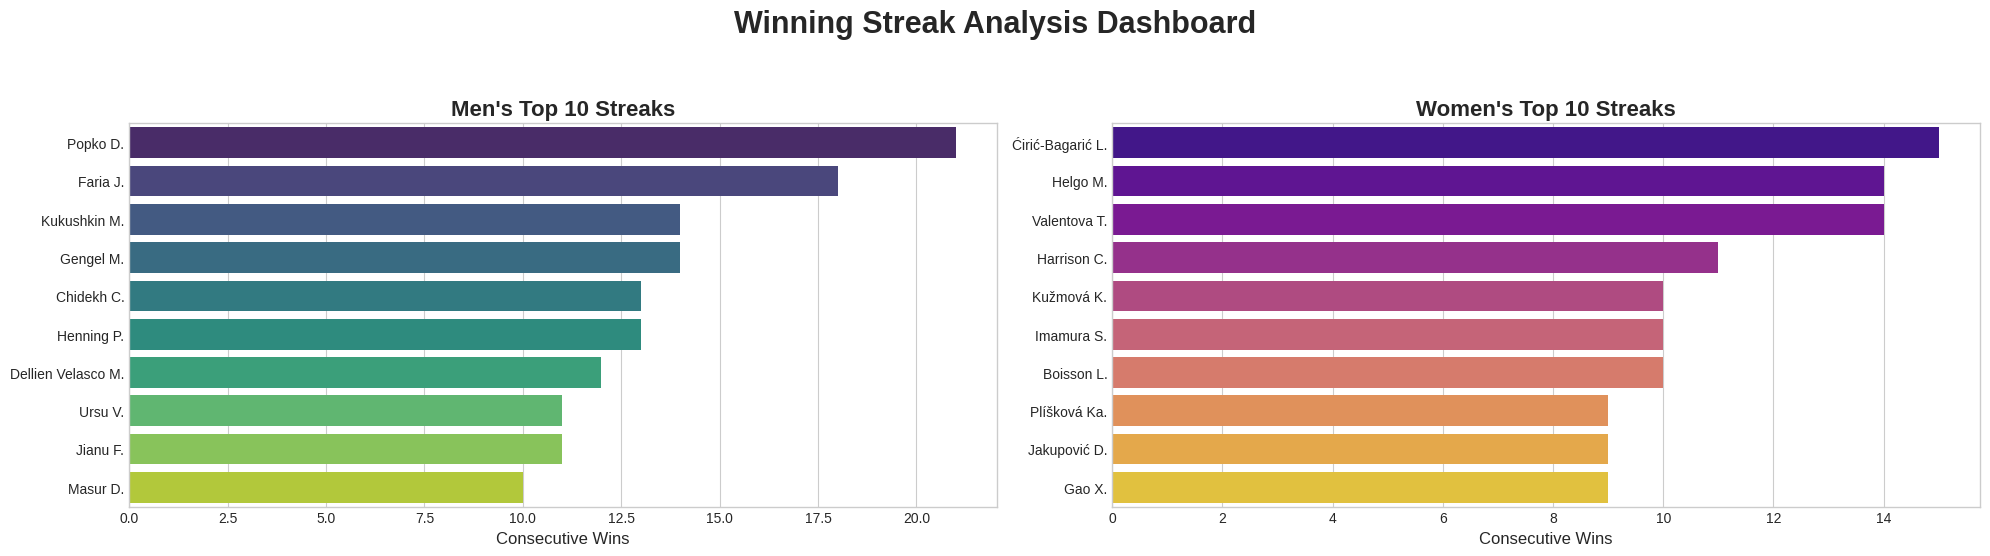

In [23]:
# --- توابع کمکی (Best Practices) ---
def latest_per_match(df, key='match_id'):
    if 'source_date' in df.columns:
        return df.sort_values([key, 'source_date']).drop_duplicates(subset=[key], keep='last')
    return df.drop_duplicates(subset=[key], keep='last')

def infer_singles_soft(df):
    if 'competition_type' in df.columns:
        comp = df['competition_type']
        is_singles_explicit = (comp == 1.0); is_doubles_explicit = (comp == 2.0)
    else:
        is_singles_explicit = pd.Series(False, index=df.index); is_doubles_explicit = pd.Series(False, index=df.index)
    
    tournament_name = df.get('tournament_name', pd.Series('', index=df.index)).astype(str).str.lower()
    season_name = df.get('season_name', pd.Series('', index=df.index)).astype(str).str.lower()
    combined_text = tournament_name + ' ' + season_name
    
    contains_doubles = combined_text.str.contains('double|dbl|doubles', na=False, regex=True)
    contains_singles = combined_text.str.contains('single|singles', na=False, regex=True)
    
    is_singles = (is_singles_explicit | (contains_singles & ~contains_doubles) | (~is_doubles_explicit & ~contains_doubles & ~contains_singles))
    return is_singles

# --- توابع نمایش نتایج ---
def display_streaks_report(men_streaks, women_streaks):
    print("\n" + "=" * 100)
    print("🏆 " + " WINNING STREAK ANALYSIS REPORT ".center(92, "═") + " 🏆")
    print("=" * 100)

    if not men_streaks.empty:
        top_man = men_streaks.iloc[0]
        print("\n🥇 MEN'S STREAK LEADER")
        print("─" * 50)
        print(f"   • Player: {top_man['name']}")
        print(f"   • Longest Streak: {int(top_man['max_streak'])} consecutive wins")

    if not women_streaks.empty:
        top_woman = women_streaks.iloc[0]
        print("\n🥇 WOMEN'S STREAK LEADER")
        print("─" * 50)
        print(f"   • Player: {top_woman['name']}")
        print(f"   • Longest Streak: {int(top_woman['max_streak'])} consecutive wins")

    print("\n\n📋 TOP 10 MEN'S WINNING STREAKS")
    print("─" * 70)
    if not men_streaks.empty:
        men_streaks['Rank'] = [f"#{i}" for i in range(1, len(men_streaks) + 1)]
        print(tabulate(men_streaks[['Rank', 'name', 'max_streak']], headers=['Rank', 'Player', 'Streak'], tablefmt='pretty', stralign='left'))
    else:
        print("   No sufficient data for men.")

    print("\n\n📋 TOP 10 WOMEN'S WINNING STREAKS")
    print("─" * 70)
    if not women_streaks.empty:
        women_streaks['Rank'] = [f"#{i}" for i in range(1, len(women_streaks) + 1)]
        print(tabulate(women_streaks[['Rank', 'name', 'max_streak']], headers=['Rank', 'Player', 'Streak'], tablefmt='pretty', stralign='left'))
    else:
        print("   No sufficient data for women.")
    print("\n" + "=" * 100)

def create_streaks_dashboard(men_streaks, women_streaks):
    plt.style.use('seaborn-v0_8-whitegrid')
    fig = plt.figure(figsize=(20, 10))
    fig.suptitle('Winning Streak Analysis Dashboard', fontsize=22, fontweight='bold')
    
    gs = fig.add_gridspec(2, 2)
    ax1 = fig.add_subplot(gs[0, 0])
    ax2 = fig.add_subplot(gs[0, 1])

    # نمودار مردان
    top_men = men_streaks.head(10)
    sns.barplot(x='max_streak', y='name', data=top_men, ax=ax1, palette='viridis', orient='h')
    ax1.set_title("Men's Top 10 Streaks", fontsize=16, fontweight='bold')
    ax1.set_xlabel('Consecutive Wins', fontsize=12)
    ax1.set_ylabel('')

    # نمودار زنان
    top_women = women_streaks.head(10)
    sns.barplot(x='max_streak', y='name', data=top_women, ax=ax2, palette='plasma', orient='h')
    ax2.set_title("Women's Top 10 Streaks", fontsize=16, fontweight='bold')
    ax2.set_xlabel('Consecutive Wins', fontsize=12)
    ax2.set_ylabel('')

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

def analyze_winning_streaks_relaxed(data_path):
    """
    سوال ۲ جدید: رکوردشکنان (Winning Streaks) - 
    """

    # --- مرحله ۱: بارگذاری داده‌ها ---
    p = Path(data_path)
    event = latest_per_match(pd.read_parquet(p / "event_complete.parquet"))
    tournament = latest_per_match(pd.read_parquet(p / "tournament_complete.parquet"))
    season = latest_per_match(pd.read_parquet(p / "season_complete.parquet"))
    home_team = latest_per_match(pd.read_parquet(p / "home_team_complete.parquet"))
    away_team = latest_per_match(pd.read_parquet(p / "away_team_complete.parquet"))

    # --- مرحله ۲: ایجاد دیتافریم جامع و فیلترهای اولیه ---
    matches_df = event.merge(tournament, on="match_id", how="left", suffixes=("", "_tour"))
    matches_df = matches_df.merge(season.rename(columns={'name': 'season_name'}), on="match_id", how="left")
    
    initial_count = len(matches_df)
    singles_mask = infer_singles_soft(matches_df)
    matches_df = matches_df[singles_mask].copy()
    
    # --- مرحله ۳: فیلتر مسابقات معتبر  ---
    initial_count = len(matches_df)
    valid_matches_df = matches_df[matches_df['winner_code'].isin([1.0, 2.0])].copy()
    
    valid_matches_df = valid_matches_df.merge(home_team, on="match_id", how="left", suffixes=("", "_home"))
    valid_matches_df = valid_matches_df.merge(away_team, on="match_id", how="left", suffixes=("", "_away"))
    valid_matches_df.dropna(subset=['player_id', 'player_id_away', 'start_datetime'], inplace=True)

    
    # --- مرحله ۴: ایجاد لیست نتایج (برد/باخت) برای هر بازیکن ---
    home_results = valid_matches_df[['start_datetime', 'player_id', 'name', 'gender', 'winner_code']].copy()
    home_results['result'] = np.where(home_results['winner_code'] == 1, 'W', 'L')
    
    away_results = valid_matches_df[['start_datetime', 'player_id_away', 'name_away', 'gender_away', 'winner_code']].copy()
    away_results.rename(columns={'player_id_away': 'player_id', 'name_away': 'name', 'gender_away': 'gender'}, inplace=True)
    away_results['result'] = np.where(away_results['winner_code'] == 2, 'W', 'L')
    
    player_results = pd.concat([home_results, away_results], ignore_index=True).dropna(subset=['player_id'])
    player_results.sort_values(by=['player_id', 'start_datetime'], inplace=True)
    
    # --- مرحله ۵: محاسبه بیشترین برد متوالی برای هر بازیکن ---
    player_results['is_win'] = (player_results['result'] == 'W').astype(int)
    # یک گروه جدید هر بار که نتیجه از برد به باخت (یا برعکس) تغییر می‌کند، شروع می‌شود
    player_results['streak_group'] = (player_results.groupby('player_id')['is_win'].diff().ne(0)).cumsum()
    
    streak_lengths = player_results[player_results['is_win'] == 1].groupby(['player_id', 'name', 'gender', 'streak_group']).size()
    player_max_streaks = streak_lengths.groupby(['player_id', 'name', 'gender']).max().reset_index(name='max_streak')

    # --- مرحله ۶: نمایش نتایج ---
    men_streaks = player_max_streaks[player_max_streaks['gender'] == 'M'].nlargest(10, 'max_streak')
    women_streaks = player_max_streaks[player_max_streaks['gender'] == 'F'].nlargest(10, 'max_streak')

    # ✅ نمایش نتایج با توابع بصری‌سازی حرفه‌ای
    display_streaks_report(men_streaks, women_streaks)
    create_streaks_dashboard(men_streaks, women_streaks)

    return {'men_streaks': men_streaks, 'women_streaks': women_streaks}

# --- اجرای تابع تحلیل ---
data_path = Path("/home/mohammadreza77615/Desktop/Tennis Schema/Final_parquet")
winning_streaks = analyze_winning_streaks_relaxed(data_path)

### سوال 3 : استادان یک سطح خاص: کدام کشورها در زمین‌های Hard، Clay و Grass بیشترین نرخ پیروزی را دارند؟


🏆 ══════════════════════════════════ SURFACE MASTERS REPORT ══════════════════════════════════ 🏆

🏟️ **HARD COURTS** (min 25 matches)
──────────────────────────────────────────────────────────────────────
╒════════╤══════════════╤════════════╤════════════════╕
│ Rank   │ Country      │ Win Rate   │ Record (W/T)   │
╞════════╪══════════════╪════════════╪════════════════╡
│ #1     │ Norway       │ 76.4%      │ 42 / 55        │
├────────┼──────────────┼────────────┼────────────────┤
│ #2     │ Georgia      │ 60.6%      │ 40 / 66        │
├────────┼──────────────┼────────────┼────────────────┤
│ #3     │ South Africa │ 59.6%      │ 28 / 47        │
├────────┼──────────────┼────────────┼────────────────┤
│ #4     │ Kazakhstan   │ 59.2%      │ 84 / 142       │
├────────┼──────────────┼────────────┼────────────────┤
│ #5     │ Finland      │ 58.7%      │ 27 / 46        │
╘════════╧══════════════╧════════════╧════════════════╛

🏟️ **CLAY COURTS** (min 25 matches)
─────────────────────────────

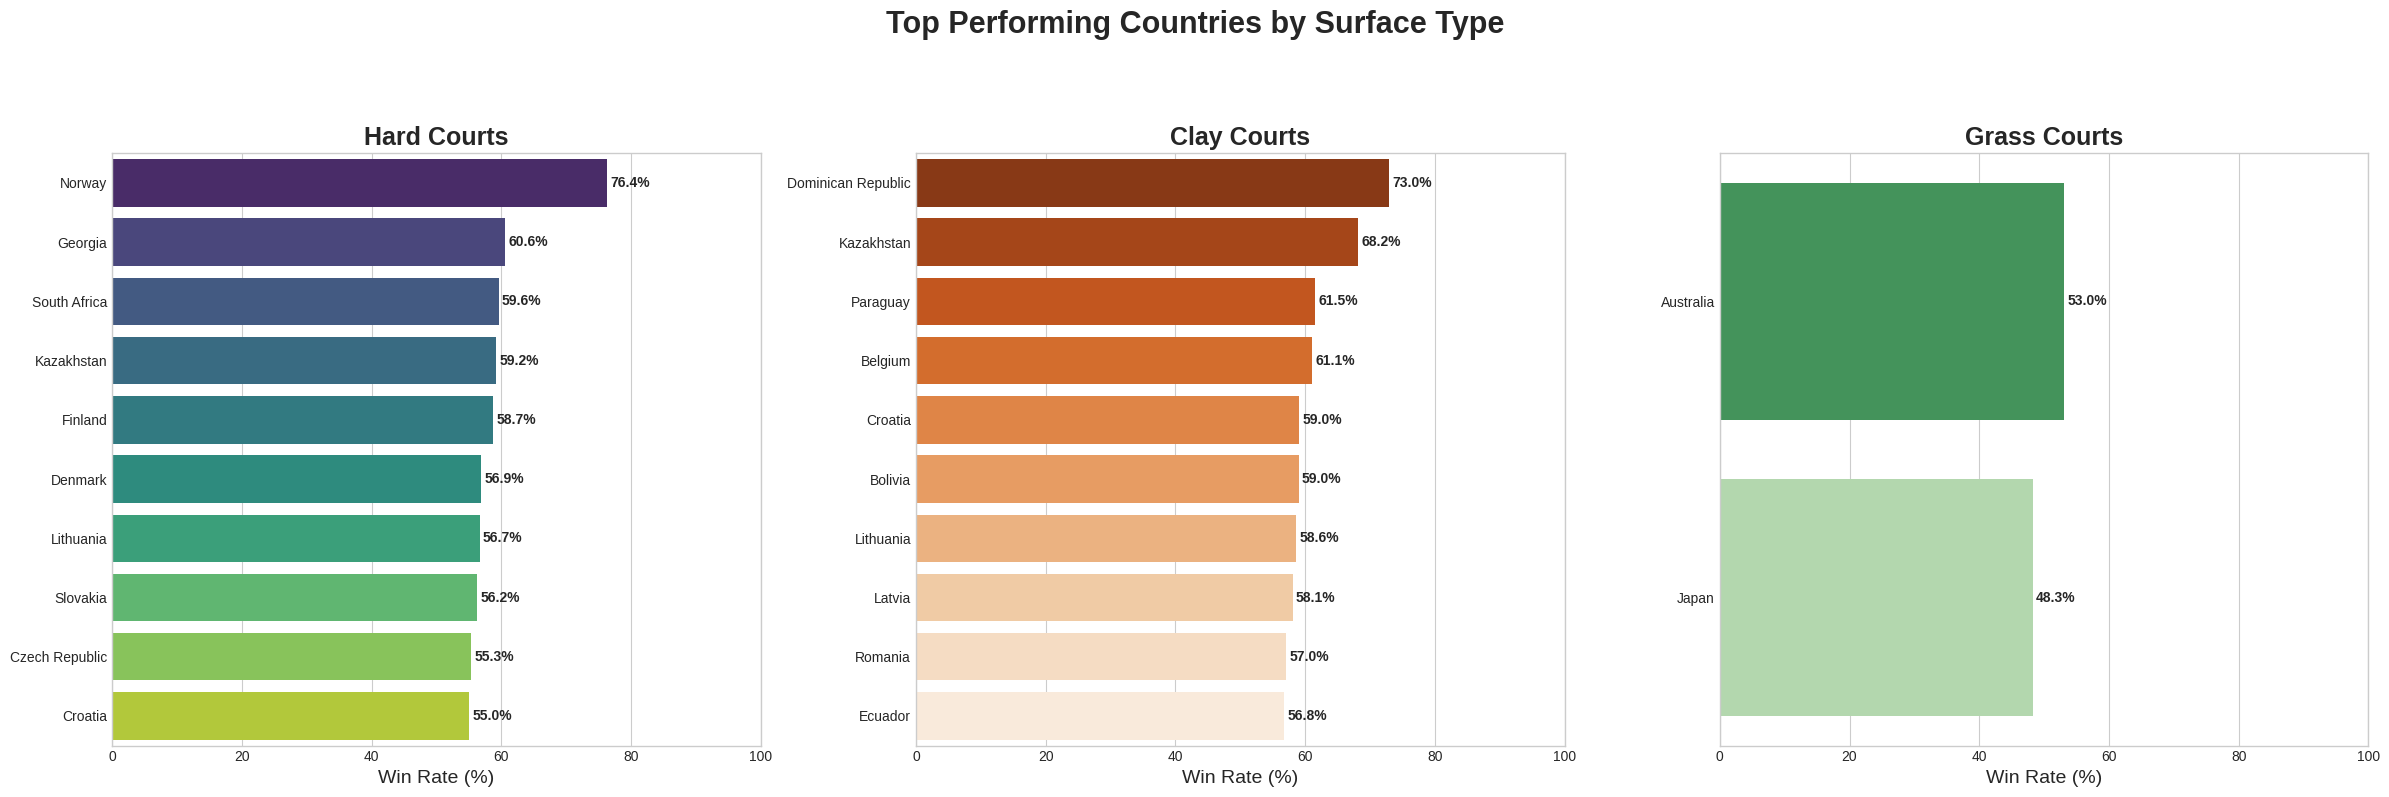

In [29]:
 # --- توابع کمکی (Best Practices) ---
def latest_per_match(df, key='match_id'):
    if 'source_date' in df.columns:
        return df.sort_values([key, 'source_date']).drop_duplicates(subset=[key], keep='last')
    return df.drop_duplicates(subset=[key], keep='last')

def infer_singles_soft(df):
    if 'competition_type' in df.columns:
        comp = df['competition_type']
        is_singles_explicit = (comp == 1.0); is_doubles_explicit = (comp == 2.0)
    else:
        is_singles_explicit = pd.Series(False, index=df.index); is_doubles_explicit = pd.Series(False, index=df.index)
    
    tournament_name = df.get('tournament_name', pd.Series('', index=df.index)).astype(str).str.lower()
    season_name = df.get('season_name', pd.Series('', index=df.index)).astype(str).str.lower()
    combined_text = tournament_name + ' ' + season_name
    
    contains_doubles = combined_text.str.contains('double|dbl|doubles', na=False, regex=True)
    contains_singles = combined_text.str.contains('single|singles', na=False, regex=True)
    
    is_singles = (is_singles_explicit | (contains_singles & ~contains_doubles) | (~is_doubles_explicit & ~contains_doubles & ~contains_singles))
    return is_singles

def normalize_surface(x):
    if not isinstance(x, str): return 'Unknown'
    s = x.strip().lower()
    if "hard" in s: return "Hard"
    if "clay" in s: return "Clay"
    if "grass" in s: return "Grass"
    if "carpet" in s: return "Carpet"
    return 'Unknown'

# --- توابع نمایش نتایج حرفه‌ای ---
def display_surface_results(top_countries_by_surface, min_matches):
    print("\n" + "=" * 100)
    print("🏆 " + " SURFACE MASTERS REPORT ".center(92, "═") + " 🏆")
    print("=" * 100)
    
    for surface, data in top_countries_by_surface.items():
        print(f"\n🏟️ **{surface.upper()} COURTS** (min {min_matches} matches)")
        print("─" * 70)
        
        if data.empty:
            print("   No countries met the minimum match criteria.")
            continue
            
        top_countries = data.head(5) # نمایش ۵ کشور برتر در جدول
        
        table_data = []
        for i, row in top_countries.iterrows():
            rank = f"#{i+1}"
            country = row['country']
            win_rate = f"{row['win_rate']:.1f}%"
            record = f"{int(row['total_wins'])} / {int(row['total_matches'])}"
            table_data.append([rank, country, win_rate, record])
            
        print(tabulate(table_data, headers=['Rank', 'Country', 'Win Rate', 'Record (W/T)'],
                       tablefmt='fancy_grid', stralign='left'))

def create_surface_dashboard(top_countries_by_surface):
    if not top_countries_by_surface:
        return

    num_surfaces = len(top_countries_by_surface)
    fig, axes = plt.subplots(1, num_surfaces, figsize=(8 * num_surfaces, 8), sharex=True)
    if num_surfaces == 1: axes = [axes]
    
    fig.suptitle("Top Performing Countries by Surface Type", fontsize=22, fontweight='bold', y=1.02)
    
    palettes = {'Hard': 'viridis', 'Clay': 'Oranges_r', 'Grass': 'Greens_r'}
    
    for ax, (surface, data) in zip(axes, top_countries_by_surface.items()):
        top_data = data.head(10) # نمایش ۱۰ کشور برتر در نمودار
        palette = sns.color_palette(palettes.get(surface, 'viridis'), n_colors=len(top_data))
        
        bars = sns.barplot(x='win_rate', y='country', data=top_data, ax=ax, palette=palette, orient='h')
        ax.set_title(f"{surface} Courts", fontsize=18, fontweight='bold')
        ax.set_xlabel("Win Rate (%)", fontsize=14)
        ax.set_ylabel("")
        ax.set_xlim(0, max(100, top_data['win_rate'].max() * 1.1))
        
        for p in ax.patches:
            width = p.get_width()
            ax.text(width + 0.5, p.get_y() + p.get_height() / 2, f'{width:.1f}%', va='center', fontweight='bold')
    
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

def analyze_country_performance_by_surface(data_path, min_matches_per_surface=20):
    p = Path(data_path)
    event = latest_per_match(pd.read_parquet(p / "event_complete.parquet"))
    tournament = latest_per_match(pd.read_parquet(p / "tournament_complete.parquet"))
    season = latest_per_match(pd.read_parquet(p / "season_complete.parquet"))
    home_team = latest_per_match(pd.read_parquet(p / "home_team_complete.parquet"))
    away_team = latest_per_match(pd.read_parquet(p / "away_team_complete.parquet"))
    home_score = pick_best_snapshot(pd.read_parquet(p / "home_team_score_complete.parquet"), 'match_id', ['period_1'])
    away_score = pick_best_snapshot(pd.read_parquet(p / "away_team_score_complete.parquet"), 'match_id', ['period_1'])

    matches_df = event.merge(tournament, on="match_id", how="left", suffixes=("", "_tour"))
    matches_df = matches_df.merge(season.rename(columns={'name': 'season_name'}), on="match_id", how="left")
    
    singles_mask = infer_singles_soft(matches_df)
    matches_df = matches_df[singles_mask].copy()

    # ✅ فیلتر آسان‌گیر: فقط بر اساس winner_code و امتیاز ست اول
    matches_df = matches_df.merge(home_score[['match_id', 'period_1']], on="match_id", how="left").rename(columns={'period_1': 'period_1_hscore'})
    matches_df = matches_df.merge(away_score[['match_id', 'period_1']], on="match_id", how="left").rename(columns={'period_1': 'period_1_ascore'})
    
    valid_matches_df = matches_df[
        matches_df['winner_code'].isin([1.0, 2.0]) &
        matches_df['period_1_hscore'].notna() &
        matches_df['period_1_ascore'].notna()
    ].copy()
    
    valid_matches_df = valid_matches_df.merge(home_team, on="match_id", how="left", suffixes=("", "_home"))
    valid_matches_df = valid_matches_df.merge(away_team, on="match_id", how="left", suffixes=("", "_away"))
    valid_matches_df.dropna(subset=['country', 'country_away'], inplace=True)

    valid_matches_df['surface'] = valid_matches_df['ground_type'].apply(normalize_surface)

    # ... (مراحل ۴ و ۵ بدون تغییر)
    home_view = valid_matches_df[['country', 'surface', 'winner_code']].copy()
    home_view['won'] = home_view['winner_code'] == 1
    
    away_view = valid_matches_df[['country_away', 'surface', 'winner_code']].copy()
    away_view.rename(columns={'country_away': 'country'}, inplace=True)
    away_view['won'] = away_view['winner_code'] == 2
    
    country_centric_df = pd.concat([home_view, away_view], ignore_index=True)
    country_centric_df = country_centric_df[country_centric_df['surface'] != 'Unknown']

    country_surface_stats = country_centric_df.groupby(['surface', 'country']).agg(
        total_matches=('won', 'count'),
        total_wins=('won', 'sum')
    ).reset_index()
    country_surface_stats['win_rate'] = (country_surface_stats['total_wins'] / country_surface_stats['total_matches']) * 100
    
    # --- مرحله ۶: پردازش و نمایش نتایج ---
    top_countries_by_surface = {}
    surfaces_to_analyze = ['Hard', 'Clay', 'Grass']
    for surface in surfaces_to_analyze:
        surface_df = country_surface_stats[country_surface_stats['surface'] == surface]
        qualified_df = surface_df[surface_df['total_matches'] >= min_matches_per_surface]
        top_countries_by_surface[surface] = qualified_df.nlargest(10, 'win_rate').reset_index(drop=True)

    # نمایش نتایج با توابع جدید
    display_surface_results(top_countries_by_surface, min_matches_per_surface)
    create_surface_dashboard(top_countries_by_surface)
    
    return country_surface_stats

# --- اجرای تابع تحلیل ---
data_path = Path("/home/mohammadreza77615/Desktop/Tennis Schema/Final_parquet")
surface_masters = analyze_country_performance_by_surface(data_path, min_matches_per_surface=25)

### سوال 4 : تاثیر زمان بر بازی: میانگین مدت زمان مسابقات روی کدام نوع زمین (Hard, Clay, Grass) بیشتر است و این تفاوت چقدر معنادار است؟

⏱️ تحلیل تاثیر زمان بر بازی (مدت زمان مسابقات بر اساس نوع زمین)

🏟️ تحلیل نوع زمین...

📊 توزیع مسابقات معتبر بر اساس نوع زمین:
   • Hard    :  5,543 (65.8%)
   • Clay    :  2,492 (29.6%)
   • Unknown :    154 (1.8%)
   • Grass   :    129 (1.5%)
   • Carpet  :    102 (1.2%)

   ✓ مسابقات روی زمین‌های اصلی: 8,164

🎯 نتیجه نهایی: تحلیل مدت زمان مسابقات بر اساس نوع زمین

📈 **آمار تفصیلی مدت زمان مسابقات:**
--------------------------------------------------------------------------------
         تعداد  بیشینه  کمینه  انحراف معیار  میانه  میانگین
surface                                                    
Clay      89.3    86.2   23.3          35.6  167.1     2492
Grass     88.9    84.6   23.4          49.3  155.6      129
Hard      88.8    84.7   23.5          35.2  175.1     5543

✅ **نتایج کلیدی:**
   🥇 طولانی‌ترین مسابقات: Clay
      • میانگین: 89.3 دقیقه
      • میانه: 86.2 دقیقه

   🥉 کوتاه‌ترین مسابقات: Hard
      • میانگین: 88.8 دقیقه
      • میانه: 84.7 دقیقه

   📊 اختلاف میانگین: 0

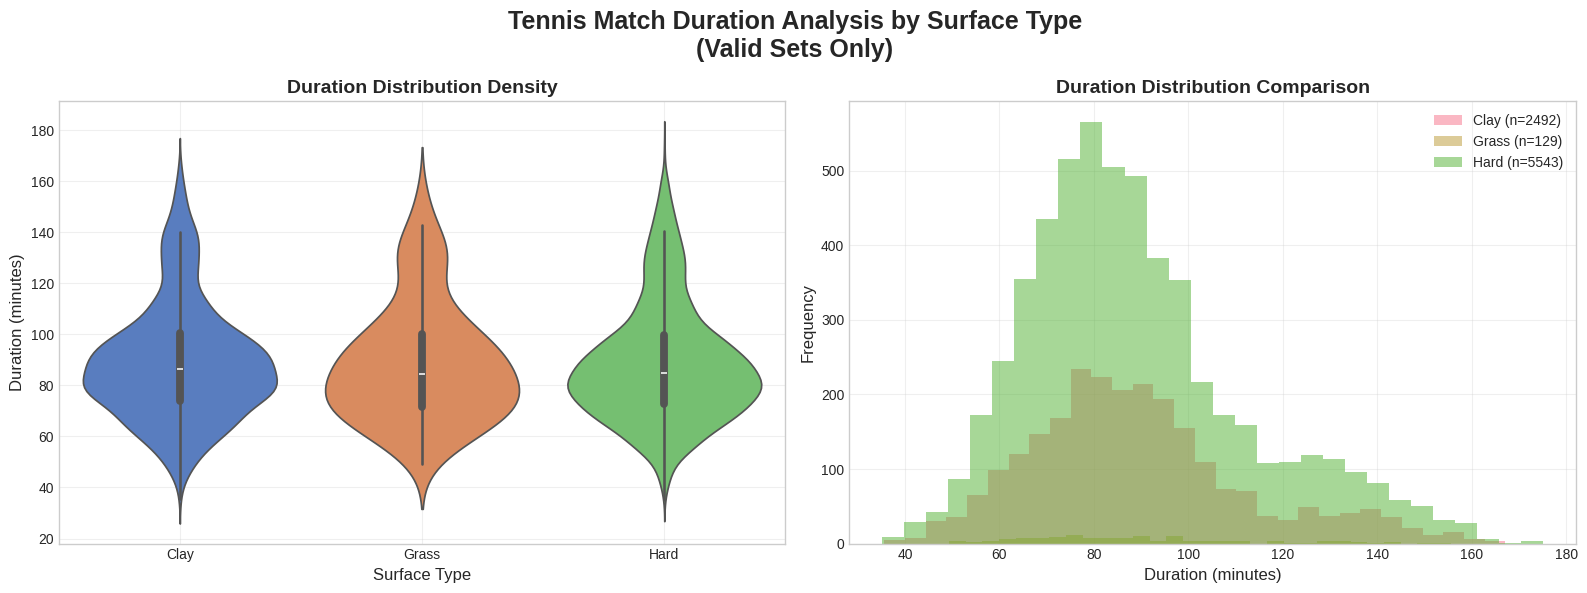

In [43]:
# --- توابع کمکی (Best Practices) ---
def latest_per_match(df, key='match_id'):
    """جدیدترین اسنپ‌شات هر مسابقه بر اساس بیشترین source_date"""
    if 'source_date' in df.columns:
        return df.sort_values([key, 'source_date']).drop_duplicates(subset=[key], keep='last')
    return df.drop_duplicates(subset=[key], keep='last')

def pick_best_snapshot(df, key, priority_cols):
    """
    بهترین اسنپ‌شات برای هر match_id بر اساس بیشترین non-null در priority_cols
    """
    d = df.copy()
    d['_nn'] = d[priority_cols].notna().sum(axis=1)
    sort_cols = [key, '_nn']
    ascending = [True, True]
    if 'source_date' in d.columns:
        sort_cols.append('source_date')
        ascending.append(True)
    d = d.sort_values(sort_cols)
    best = d.drop_duplicates(subset=[key], keep='last').drop(columns=['_nn'])
    return best

def infer_singles_soft(df):
    """تشخیص مسابقات انفرادی"""
    if 'competition_type' in df.columns:
        comp = df['competition_type']
        is_singles_explicit = (comp == 1.0)
        is_doubles_explicit = (comp == 2.0)
    else:
        is_singles_explicit = pd.Series(False, index=df.index)
        is_doubles_explicit = pd.Series(False, index=df.index)
    
    tournament_name = df.get('tournament_name', pd.Series('', index=df.index)).astype(str).str.lower()
    season_name = df.get('season_name', pd.Series('', index=df.index)).astype(str).str.lower()
    combined_text = tournament_name + ' ' + season_name
    
    contains_doubles = combined_text.str.contains('double|dbl|doubles', na=False, regex=True)
    contains_singles = combined_text.str.contains('single|singles', na=False, regex=True)
    
    is_singles = (
        is_singles_explicit |
        (contains_singles & ~contains_doubles) |
        (~is_doubles_explicit & ~contains_doubles & ~contains_singles)
    )
    return is_singles

def normalize_surface(x):
    """نرمال‌سازی نوع زمین"""
    if not isinstance(x, str): return 'Unknown'
    s = x.strip().lower()
    if "hard" in s: return "Hard"
    if "clay" in s: return "Clay"
    if "grass" in s: return "Grass"
    if "carpet" in s: return "Carpet"
    return 'Unknown'

def analyze_duration_by_surface_valid(data_path):
    """
    تحلیل مدت زمان مسابقات بر اساس نوع زمین - با قوانین ست معتبر
    """
    print("=" * 80)
    print("⏱️ تحلیل تاثیر زمان بر بازی (مدت زمان مسابقات بر اساس نوع زمین)")
    print("=" * 80)

    data_path = Path(data_path)

    # --- مرحله ۱: بارگذاری داده‌ها ---
    
    time_df    = pd.read_parquet(data_path / "time_complete.parquet")
    event      = pd.read_parquet(data_path / "event_complete.parquet")
    hscore_raw = pd.read_parquet(data_path / "home_team_score_complete.parquet")
    ascore_raw = pd.read_parquet(data_path / "away_team_score_complete.parquet")
    tournament = pd.read_parquet(data_path / "tournament_complete.parquet")
    season     = pd.read_parquet(data_path / "season_complete.parquet")

    # --- مرحله ۲: انتخاب اسنپ‌شات‌های بهینه ---
    
    # برای جداول متادیتا
    event      = latest_per_match(event)
    tournament = latest_per_match(tournament)
    season     = latest_per_match(season)
    
    # برای داده‌های زمان و امتیاز - انتخاب بهترین اسنپ‌شات
    time_best  = pick_best_snapshot(time_df, 'match_id', ['period_1','period_2','period_3'])
    hscore     = pick_best_snapshot(hscore_raw, 'match_id', ['period_1','period_2','period_3'])
    ascore     = pick_best_snapshot(ascore_raw, 'match_id', ['period_1','period_2','period_3'])
    
    # نام‌گذاری یکتا برای جلوگیری از تداخل
    time_best = time_best[['match_id','period_1','period_2','period_3']].rename(
        columns={'period_1':'t1','period_2':'t2','period_3':'t3'}
    )
    hscore = hscore[['match_id','period_1','period_2','period_3']].rename(
        columns={'period_1':'h1','period_2':'h2','period_3':'h3'}
    )
    ascore = ascore[['match_id','period_1','period_2','period_3']].rename(
        columns={'period_1':'a1','period_2':'a2','period_3':'a3'}
    )

    # --- مرحله ۳: ادغام داده‌ها ---
    
    df = (event[['match_id','winner_code','start_datetime']]
          .merge(time_best, on='match_id', how='left')
          .merge(hscore, on='match_id', how='left')
          .merge(ascore, on='match_id', how='left')
          .merge(tournament[['match_id','tournament_name','ground_type']], on='match_id', how='left')
          .merge(season[['match_id','name']].rename(columns={'name':'season_name'}), on='match_id', how='left')
         )
    
    # تبدیل به عدد
    for c in ['t1','t2','t3','h1','h2','h3','a1','a2','a3']:
        df[c] = pd.to_numeric(df[c], errors='coerce')

    # --- مرحله ۴: فیلتر مسابقات انفرادی ---
    
    initial_count = len(df)
    singles_mask = infer_singles_soft(df)
    df = df[singles_mask].copy()

    # --- مرحله ۵: اعتبارسنجی ست‌ها (دقیقاً مطابق کد دوم) ---
    
    # ثابت‌های اعتبارسنجی
    MIN_SET_SECONDS   = 15 * 60  # 15 دقیقه
    MAX_SET_SECONDS   = 60 * 60  # 60 دقیقه
    MIN_GAMES_PER_SET = 6
    MAX_GAMES_PER_SET = 16
    
    def set_valid(t, h, a):
        """بررسی اعتبار یک ست بر اساس زمان و تعداد گیم‌ها"""
        if pd.isna(t) or pd.isna(h) or pd.isna(a):
            return False
        minutes = t / 60.0
        games = h + a
        return (15 <= minutes <= 60) and (MIN_GAMES_PER_SET <= games <= MAX_GAMES_PER_SET)
    
    # اعمال قوانین اعتبار برای هر ست
    df['s1_valid'] = df.apply(lambda r: set_valid(r['t1'], r['h1'], r['a1']), axis=1)
    df['s2_valid'] = df.apply(lambda r: set_valid(r['t2'], r['h2'], r['a2']), axis=1)
    df['s3_valid'] = df.apply(lambda r: set_valid(r['t3'], r['h3'], r['a3']), axis=1)
    
    df['valid_sets'] = df[['s1_valid','s2_valid','s3_valid']].sum(axis=1)

    # --- مرحله ۶: فیلتر نهایی (winner_code معتبر + حداقل 2 ست معتبر) ---
    
    before = len(df)
    df = df[df['winner_code'].isin([1.0, 2.0])]
    after_w = len(df)
    df = df[df['valid_sets'] >= 2]
    after_vs = len(df)

    # --- مرحله ۷: نرمال‌سازی نوع زمین ---
    print("\n🏟️ تحلیل نوع زمین...")
    
    df['surface'] = df['ground_type'].apply(normalize_surface)
    
    # نمایش توزیع
    print("\n📊 توزیع مسابقات معتبر بر اساس نوع زمین:")
    surface_counts = df['surface'].value_counts()
    for surface, count in surface_counts.items():
        percentage = (count / len(df)) * 100
        print(f"   • {surface:8s}: {count:6,} ({percentage:.1f}%)")
    
    # فیلتر زمین‌های اصلی
    main_surfaces = ['Hard', 'Clay', 'Grass']
    df_main = df[df['surface'].isin(main_surfaces)].copy()
    print(f"\n   ✓ مسابقات روی زمین‌های اصلی: {len(df_main):,}")

    if len(df_main) == 0:
        print("\n❌ هیچ داده معتبری برای تحلیل یافت نشد.")
        return None

    # --- مرحله ۸: محاسبه زمان کل (فقط از ست‌های معتبر) ---
    
    df_main['total_seconds_valid'] = (
        np.where(df_main['s1_valid'], df_main['t1'], 0) +
        np.where(df_main['s2_valid'], df_main['t2'], 0) +
        np.where(df_main['s3_valid'], df_main['t3'], 0)
    )
    df_main['total_minutes'] = df_main['total_seconds_valid'] / 60.0
    
    # فیلتر نهایی برای حذف outliers
    df_final = df_main[(df_main['total_minutes'] > 0)].copy()

    # --- مرحله ۹: تحلیل آماری ---
    print("\n" + "=" * 80)
    print("🎯 نتیجه نهایی: تحلیل مدت زمان مسابقات بر اساس نوع زمین")
    print("=" * 80)
    
    surface_stats = df_final.groupby('surface')['total_minutes'].agg([
        'mean', 'median', 'std', 'min', 'max', 'count'
    ]).sort_values('mean', ascending=False)
    
    print("\n📈 **آمار تفصیلی مدت زمان مسابقات:**")
    print("-" * 80)
    
    # نمایش جدول
    stats_display = surface_stats.copy()
    stats_display.columns = ['تعداد', 'بیشینه', 'کمینه', 'انحراف معیار', 'میانه', 'میانگین']
    stats_display = stats_display.round(1)
    print(stats_display.to_string())
    
    # نتایج کلیدی
    if len(surface_stats) > 0:
        longest_surface = surface_stats.index[0]
        shortest_surface = surface_stats.index[-1]
        
        print(f"\n✅ **نتایج کلیدی:**")
        print(f"   🥇 طولانی‌ترین مسابقات: {longest_surface}")
        print(f"      • میانگین: {surface_stats.loc[longest_surface, 'mean']:.1f} دقیقه")
        print(f"      • میانه: {surface_stats.loc[longest_surface, 'median']:.1f} دقیقه")
        
        print(f"\n   🥉 کوتاه‌ترین مسابقات: {shortest_surface}")
        print(f"      • میانگین: {surface_stats.loc[shortest_surface, 'mean']:.1f} دقیقه")
        print(f"      • میانه: {surface_stats.loc[shortest_surface, 'median']:.1f} دقیقه")
        
        diff = surface_stats.loc[longest_surface, 'mean'] - surface_stats.loc[shortest_surface, 'mean']
        diff_pct = (diff / surface_stats.loc[shortest_surface, 'mean']) * 100
        print(f"\n   📊 اختلاف میانگین: {diff:.1f} دقیقه ({diff_pct:.1f}%)")
    
    # آزمون ANOVA
    if len(surface_stats) >= 2:
        print("\n🔬 **آزمون معناداری آماری (ANOVA):**")
        groups = []
        for surface in surface_stats.index:
            surface_data = df_final[df_final['surface'] == surface]['total_minutes']
            if len(surface_data) > 0:
                groups.append(surface_data)
        
        if len(groups) >= 2:
            f_stat, p_value = f_oneway(*groups)
            print(f"   • F-statistic: {f_stat:.2f}")
            print(f"   • p-value: {p_value:.6f}")
            
            if p_value < 0.05:
                print("   ✅ نتیجه: تفاوت میانگین‌ها از نظر آماری معنادار است (p < 0.05)")
                
                # Tukey's HSD برای مقایسه جفتی
                if len(surface_stats) > 2:
                    print("\n   • مقایسه جفتی (Tukey's HSD):")
                    tukey_results = pairwise_tukeyhsd(
                        endog=df_final['total_minutes'], 
                        groups=df_final['surface'], 
                        alpha=0.05
                    )
                    print(tukey_results)
            else:
                print("   ❌ نتیجه: تفاوت میانگین‌ها از نظر آماری معنادار نیست (p >= 0.05)")
    
    print("\n" + "=" * 80)
    
    # --- مرحله ۱۰: بصری‌سازی ---
    if len(surface_stats) > 0:
        
        plt.style.use('seaborn-v0_8-whitegrid')
        fig, axes = plt.subplots(1, 2, figsize=(16, 6))  # یک ردیف، دو نمودار
        fig.suptitle("Tennis Match Duration Analysis by Surface Type\n(Valid Sets Only)", 
                     fontsize=18, fontweight='bold')
        
        order_list = surface_stats.sort_values('mean', ascending=False).index.tolist()
        
        
        # 1. Violin Plot
        sns.violinplot(data=df_final, x='surface', y='total_minutes', 
                      order=order_list, palette='muted', ax=axes[0])
        axes[0].set_title('Duration Distribution Density', fontsize=14, fontweight='bold')
        axes[0].set_xlabel('Surface Type', fontsize=12)
        axes[0].set_ylabel('Duration (minutes)', fontsize=12)
        axes[0].grid(True, alpha=0.3)
        
    
        # 2. Histogram Comparison
        for surface in order_list:
            surface_data = df_final[df_final['surface'] == surface]['total_minutes']
            axes[1].hist(surface_data, alpha=0.5, 
                          label=f'{surface} (n={len(surface_data)})', bins=30)
        
        axes[1].set_title('Duration Distribution Comparison', fontsize=14, fontweight='bold')
        axes[1].set_xlabel('Duration (minutes)', fontsize=12)
        axes[1].set_ylabel('Frequency', fontsize=12)
        axes[1].legend()
        axes[1].grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()

    
    return df_final

# اجرای تحلیل
data_path = Path("/home/mohammadreza77615/Desktop/Tennis Schema/Final_parquet")
result = analyze_duration_by_surface_valid(data_path)

### سوال 5 : آیا بنگاه‌های شرط‌بندی برنده را درست پیش‌بینی می‌کنند؟با مقایسه شانس برد (odds) با نتیجه نهایی، دقت پیش‌بینی‌ها چقدر است؟


🎯 نتیجه نهایی: دقت پیش‌بینی بنگاه‌های شرط‌بندی
📈 **دقت کلی پیش‌بینی: 69.3%**
⭐ **نرخ برد Favorite: 69.3%**
🤯 **نرخ شگفتی (Upset Rate): 30.7%**
💰 **میانگین Overround: 6.1%**


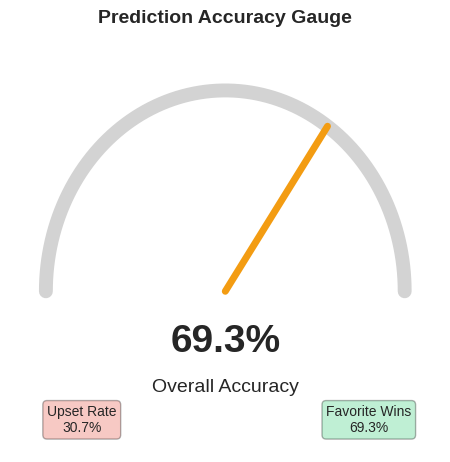

In [45]:
# --- توابع کمکی (Best Practices) ---
def latest_per_match(df, key='match_id'):
    """جدیدترین اسنپ‌شات هر مسابقه بر اساس بیشترین source_date"""
    if 'source_date' in df.columns:
        return df.sort_values([key, 'source_date']).drop_duplicates(subset=[key], keep='last')
    return df.drop_duplicates(subset=[key], keep='last')

def pick_best_snapshot(df, key, priority_cols):
    """
    بهترین اسنپ‌شات برای هر match_id بر اساس بیشترین non-null در priority_cols
    """
    d = df.copy()
    d['_nn'] = d[priority_cols].notna().sum(axis=1)
    sort_cols = [key, '_nn']
    ascending = [True, True]
    if 'source_date' in d.columns:
        sort_cols.append('source_date')
        ascending.append(True)
    d = d.sort_values(sort_cols)
    best = d.drop_duplicates(subset=[key], keep='last').drop(columns=['_nn'])
    return best

def fractional_to_decimal(fractional_str):
    """تبدیل odds کسری به اعشاری"""
    try:
        if pd.isna(fractional_str):
            return np.nan
        # پشتیبانی از فرمت‌های '1/'
        if '/' in fractional_str:
            parts = fractional_str.split('/')
            if len(parts) == 2 and parts[1] == '':
                parts[1] = '1'
            num, den = map(int, parts)
            return 1 + (num / den)
        else: # اگر عدد صحیح باشد
            return 1 + int(fractional_str)
    except (ValueError, ZeroDivisionError, AttributeError):
        return np.nan

def analyze_bookmaker_accuracy_with_viz(data_path):
    """
    سوال ۵ جدید: تحلیل دقت پیش‌بینی بنگاه‌های شرط‌بندی با بصری‌سازی حرفه‌ای.
    """

    # --- مرحله ۱: بارگذاری داده‌ها ---
    p = Path(data_path)
    odds = pd.read_parquet(p / "odds_complete.parquet")
    event = latest_per_match(pd.read_parquet(p / "event_complete.parquet"))

    # --- مرحله ۲: پردازش داده‌های Odds ---
    odds_ft = odds[(odds['market_name'] == 'full_time') & (odds['is_live'] == False)].copy()
    odds_ft = odds_ft.sort_values(['match_id', 'source_date']).drop_duplicates(subset=['match_id', 'choice_name'], keep='last')
    
    odds_ft['decimal_odds'] = odds_ft['fractional_value'].apply(fractional_to_decimal)
    odds_ft.dropna(subset=['decimal_odds'], inplace=True)
    odds_ft['implied_prob'] = 1 / odds_ft['decimal_odds']

    odds_pivot = odds_ft.pivot_table(index='match_id', columns='choice_name', values='implied_prob').reset_index()
    
    # استانداردسازی نام ستون‌ها
    if '1' in odds_pivot.columns and '2' in odds_pivot.columns:
        odds_pivot.rename(columns={'1': 'prob_home_win', '2': 'prob_away_win'}, inplace=True)
    elif 'home' in odds_pivot.columns and 'away' in odds_pivot.columns:
        odds_pivot.rename(columns={'home': 'prob_home_win', 'away': 'prob_away_win'}, inplace=True)
    else:
        # اگر نام ستون‌ها متفاوت است، اولین دو ستون بعد از match_id را انتخاب می‌کنیم
        cols = odds_pivot.columns.tolist()
        cols.remove('match_id')
        if len(cols) >= 2:
            odds_pivot.rename(columns={cols[0]: 'prob_home_win', cols[1]: 'prob_away_win'}, inplace=True)
        else:
            print("   ⚠️ هشدار: ستون‌های odds کافی یافت نشد.")
            return None
        
    odds_pivot.dropna(subset=['prob_home_win', 'prob_away_win'], inplace=True)
    
    # --- مرحله ۳: ساخت دیتافریم جامع و اعمال فیلتر ---
    matches_df = odds_pivot.merge(event[['match_id', 'winner_code']], on='match_id', how='inner')
    matches_df = matches_df[matches_df['winner_code'].isin([1.0, 2.0])].copy()

    # --- مرحله ۴: مقایسه پیش‌بینی با واقعیت ---
    
    # نرمال‌سازی احتمالات (حذف overround)
    total_prob = matches_df['prob_home_win'] + matches_df['prob_away_win']
    matches_df['prob_home_normalized'] = matches_df['prob_home_win'] / total_prob
    matches_df['prob_away_normalized'] = matches_df['prob_away_win'] / total_prob
    matches_df['overround'] = (total_prob - 1) * 100

    # تعیین favorite و محاسبه دقت
    matches_df['favorite'] = np.where(
        matches_df['prob_home_normalized'] > matches_df['prob_away_normalized'], 
        'home', 'away'
    )
    matches_df['favorite_won'] = np.where(
        ((matches_df['favorite'] == 'home') & (matches_df['winner_code'] == 1)) |
        ((matches_df['favorite'] == 'away') & (matches_df['winner_code'] == 2)),
        True, False
    )
    
    matches_df['predicted_winner'] = np.where(
        matches_df['prob_home_normalized'] > matches_df['prob_away_normalized'], 
        1, 2
    )
    matches_df['prediction_correct'] = (matches_df['predicted_winner'] == matches_df['winner_code'])
    matches_df['favorite_prob'] = matches_df[['prob_home_normalized', 'prob_away_normalized']].max(axis=1)
    
    # محاسبه آمار
    accuracy = matches_df['prediction_correct'].mean() * 100
    favorite_win_rate = matches_df['favorite_won'].mean() * 100
    upset_rate = 100 - favorite_win_rate

    # --- مرحله ۵: نمایش نتایج متنی ---
    print("\n" + "=" * 80)
    print("🎯 نتیجه نهایی: دقت پیش‌بینی بنگاه‌های شرط‌بندی")
    print("=" * 80)
    print(f"📈 **دقت کلی پیش‌بینی: {accuracy:.1f}%**")
    print(f"⭐ **نرخ برد Favorite: {favorite_win_rate:.1f}%**")
    print(f"🤯 **نرخ شگفتی (Upset Rate): {upset_rate:.1f}%**")
    print(f"💰 **میانگین Overround: {matches_df['overround'].mean():.1f}%**")
    print("=" * 80)

    # --- مرحله ۶: بصری‌سازی ---
    
    plt.style.use('seaborn-v0_8-whitegrid')
    fig = plt.figure(figsize=(20, 12))
    
    # ایجاد grid
    gs = fig.add_gridspec(2, 3, hspace=0.3, wspace=0.3)
    
    # --- نمودار 1: Gauge Chart ---
    ax1 = fig.add_subplot(gs[0, 0])
    
    # ایجاد gauge chart
    theta = np.linspace(0, np.pi, 100)
    r = 1
    x = r * np.cos(theta)
    y = r * np.sin(theta)
    
    # رنگ‌بندی بر اساس دقت
    color = '#e74c3c' if accuracy < 60 else '#f39c12' if accuracy < 70 else '#2ecc71'
    ax1.plot(x, y, color='lightgray', linewidth=10)
    
    # نمایش دقت
    angle = np.pi * (1 - accuracy/100)
    ax1.plot([0, np.cos(angle)], [0, np.sin(angle)], color=color, linewidth=5)
    ax1.text(0, -0.3, f'{accuracy:.1f}%', fontsize=28, fontweight='bold', ha='center')
    ax1.text(0, -0.5, 'Overall Accuracy', fontsize=14, ha='center')
    
    # نمایش آمار اضافی
    ax1.text(-0.8, -0.7, f'Upset Rate\n{upset_rate:.1f}%', fontsize=10, ha='center', 
             bbox=dict(boxstyle="round,pad=0.3", facecolor='#e74c3c', alpha=0.3))
    ax1.text(0.8, -0.7, f'Favorite Wins\n{favorite_win_rate:.1f}%', fontsize=10, ha='center',
             bbox=dict(boxstyle="round,pad=0.3", facecolor='#2ecc71', alpha=0.3))
    
    ax1.set_xlim(-1.2, 1.2)
    ax1.set_ylim(-0.8, 1.2)
    ax1.axis('off')
    ax1.set_title('Prediction Accuracy Gauge', fontsize=14, fontweight='bold', pad=20)
    return matches_df

# --- اجرای تابع ---
data_path = Path("/home/mohammadreza77615/Desktop/Tennis Schema/Final_parquet")
odds_analysis_df = analyze_bookmaker_accuracy_with_viz(data_path)

### سوال 6 : با استفاده از BMI سالم، قد و وزن بازیکنان نامشخص را تخمین بزنید و تاثیر کلی آن رانشان دهید.

📊 تحلیل BMI و تخمین هوشمند قد و وزن

❤️ مرحله ۲: محاسبه میانگین BMI سالم...
   • میانگین BMI سالم برای مردان: 22.83
   • میانگین BMI سالم برای زنان: 21.18

🎯 نتیجه نهایی: توزیع قد و وزن پس از اصلاح و تخمین
   • میانگین قد نهایی: 182.2 cm
   • میانگین وزن نهایی: 74.9 kg

**نمونه‌ای از وزن‌های اصلاح شده (قبلاً مشکوک بود):**
             name gender  height_cm_final  weight_final_kg
Ferreira Silva F.      M            178.0        72.327314
      Vrbenský M.      M            183.0        76.447715

**نمونه‌ای از وزن‌های تخمین زده شده (قبلاً وزن نداشتند):**
        name gender  height_cm_final  weight_final_kg
 Alvarado P.      M            175.0        69.909859
 Williams V.      F            185.0        72.494907
Zvonareva V.      F            172.0        62.664407

**نمونه‌ای از قدهای تخمین زده شده:**
         name gender  weight_final_kg  height_cm_final
    Falcão G.      M             77.0       183.659838
Dzhavakian Y.      M             80.0       187.203441
 Cukierman D.      M

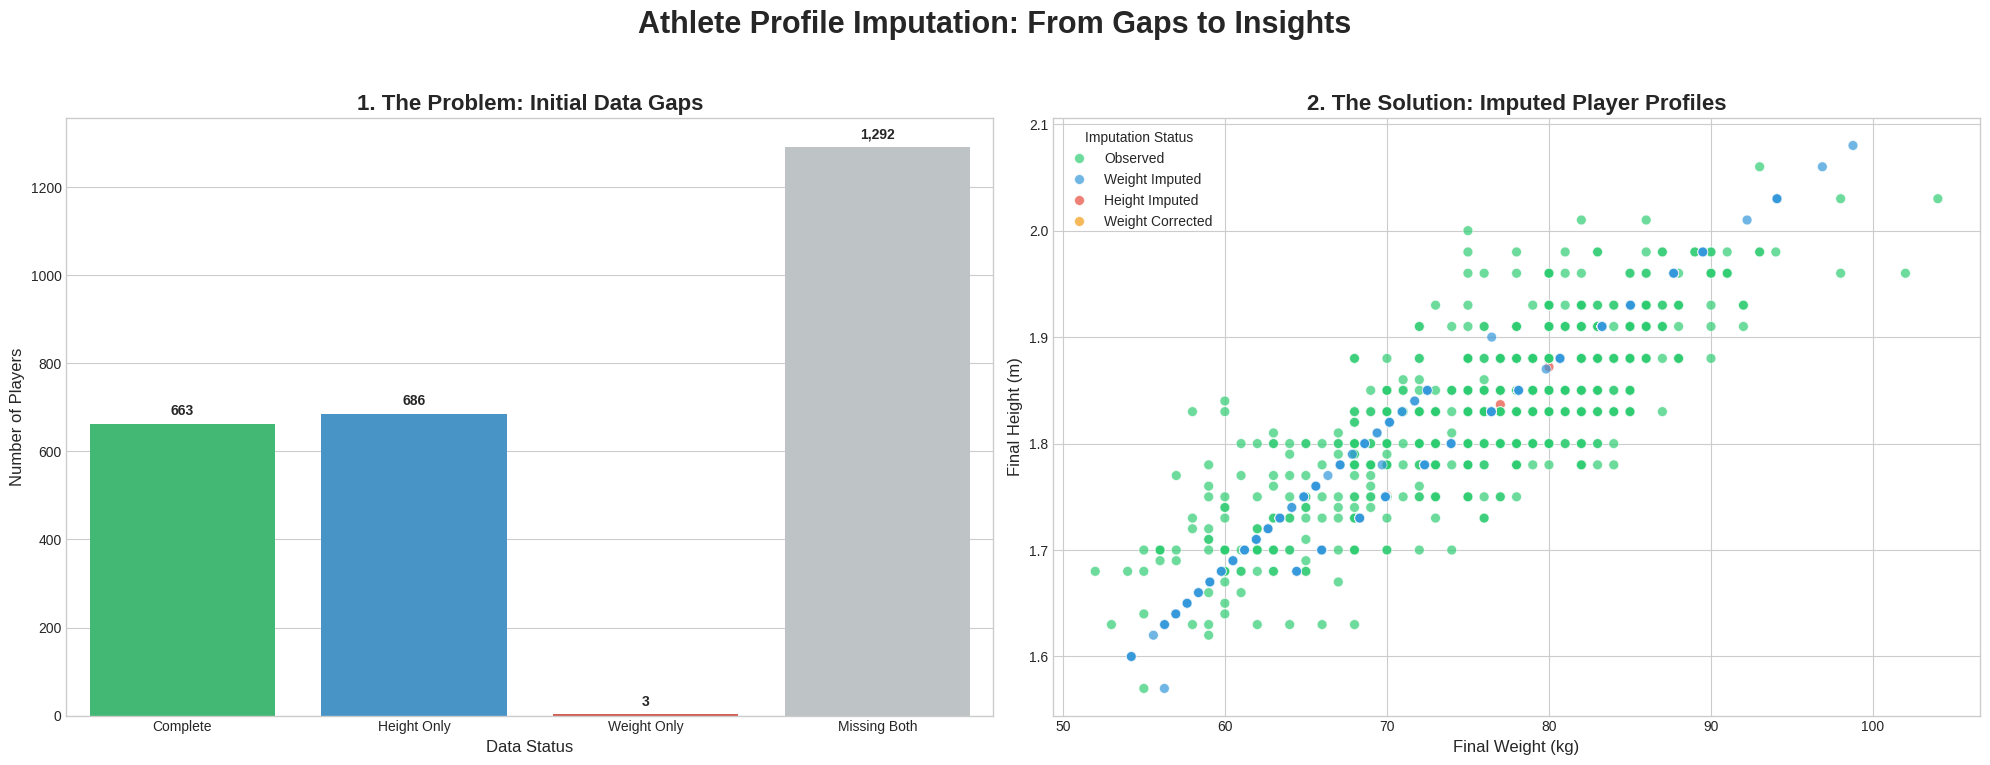

In [49]:
def analyze_and_impute_height_weight_final_v2(data_path, plot=True):
    """
    تحلیل نهایی BMI و تخمین هوشمند قد و وزن با بهترین منطق و نمایش کامل نتایج.
    """
    print("=" * 80)
    print("📊 تحلیل BMI و تخمین هوشمند قد و وزن")
    print("=" * 80)

    # --- توابع کمکی ---
    def mode_or_first(series):
        s = series.dropna()
        if s.empty:
            return np.nan
        m = s.mode()
        return m.iloc[0] if len(m) > 0 else np.nan

    # --- مرحله ۱: بارگذاری و ایجاد پروفایل یکتای بازیکنان ---
    data_path = Path(data_path)
    home_team = pd.read_parquet(data_path / "home_team_complete.parquet")[['player_id', 'name', 'gender', 'height', 'weight']]
    away_team = pd.read_parquet(data_path / "away_team_complete.parquet")[['player_id', 'name', 'gender', 'height', 'weight']]

    all_player_records = pd.concat([home_team, away_team], ignore_index=True)
    all_player_records['player_id'] = pd.to_numeric(all_player_records['player_id'], errors='coerce')
    all_player_records.dropna(subset=['player_id'], inplace=True)
    all_player_records['player_id'] = all_player_records['player_id'].astype(int)

    unique_players = all_player_records.groupby('player_id').agg(
        name=('name', mode_or_first),
        height_m=('height', mode_or_first),
        weight_kg=('weight', mode_or_first),
        gender=('gender', mode_or_first)
    ).reset_index()
    unique_players['gender'] = unique_players['gender'].where(unique_players['gender'].isin(['M', 'F']), 'Unknown')

    # --- مرحله ۲: محاسبه میانگین BMI سالم ---
    print("\n❤️ مرحله ۲: محاسبه میانگین BMI سالم...")
    players_with_both = unique_players.dropna(subset=['height_m', 'weight_kg']).copy()
    players_with_both = players_with_both[players_with_both['height_m'] > 0]
    players_with_both['bmi'] = players_with_both['weight_kg'] / (players_with_both['height_m'] ** 2)
    
    healthy_bmi_players = players_with_both[players_with_both['bmi'].between(19, 28)]
    avg_healthy_bmi = healthy_bmi_players.groupby('gender')['bmi'].mean().to_dict()
    print(f"   • میانگین BMI سالم برای مردان: {avg_healthy_bmi.get('M', 22.8):.2f}")
    print(f"   • میانگین BMI سالم برای زنان: {avg_healthy_bmi.get('F', 21.2):.2f}")

    # --- مرحله ۳: اصلاح و تخمین داده‌ها ---

    unique_players['height_final_m'] = unique_players['height_m']
    unique_players['weight_final_kg'] = unique_players['weight_kg']
    unique_players['imputation_status'] = 'Observed'

    # 1. اصلاح وزن‌های مشکوک
    suspicious_weight_mask = (unique_players['weight_kg'].notna()) & \
                             (~unique_players['weight_kg'].between(40, 120)) & \
                             (unique_players['height_m'].notna() & unique_players['height_m'].between(1.4, 2.2))
    
    corrected_weight_count = suspicious_weight_mask.sum()
    if corrected_weight_count > 0:
        unique_players.loc[suspicious_weight_mask, 'weight_final_kg'] = unique_players[suspicious_weight_mask].apply(
            lambda row: avg_healthy_bmi.get(row['gender'], 22) * (row['height_m'] ** 2), axis=1
        )
        unique_players.loc[suspicious_weight_mask, 'imputation_status'] = 'Weight Corrected'
    
    # 2. تخمین وزن
    impute_weight_mask = unique_players['height_m'].notna() & unique_players['weight_kg'].isna() & \
                         unique_players['height_m'].between(1.4, 2.2)
    imputed_weight_count = impute_weight_mask.sum()
    if imputed_weight_count > 0:
        unique_players.loc[impute_weight_mask, 'weight_final_kg'] = unique_players[impute_weight_mask].apply(
            lambda row: avg_healthy_bmi.get(row['gender'], 22) * (row['height_m'] ** 2), axis=1
        )
        unique_players.loc[impute_weight_mask, 'imputation_status'] = 'Weight Imputed'

    # 3. تخمین قد
    impute_height_mask = unique_players['height_m'].isna() & \
                         unique_players['weight_final_kg'].notna() & \
                         unique_players['weight_final_kg'].between(40, 120)
                         
    imputed_height_count = impute_height_mask.sum()
    if imputed_height_count > 0:
        unique_players.loc[impute_height_mask, 'height_final_m'] = unique_players[impute_height_mask].apply(
            lambda row: np.sqrt(row['weight_final_kg'] / avg_healthy_bmi.get(row['gender'], 22)), axis=1
        )
        unique_players.loc[impute_height_mask, 'imputation_status'] = 'Height Imputed'
    
    total_rescued = unique_players['imputation_status'].ne('Observed').sum()
    
    # --- مرحله ۴: نمایش نتایج ---
    final_data = unique_players.dropna(subset=['height_final_m', 'weight_final_kg']).copy()
    final_data['height_cm_final'] = final_data['height_final_m'] * 100
    
    print("\n" + "=" * 80)
    print("🎯 نتیجه نهایی: توزیع قد و وزن پس از اصلاح و تخمین")
    print("=" * 80)
    
    print(f"   • میانگین قد نهایی: {final_data['height_cm_final'].mean():.1f} cm")
    print(f"   • میانگین وزن نهایی: {final_data['weight_final_kg'].mean():.1f} kg")
    
    if corrected_weight_count > 0:
        print("\n**نمونه‌ای از وزن‌های اصلاح شده (قبلاً مشکوک بود):**")
        print(final_data[final_data['imputation_status'] == 'Weight Corrected'][['name', 'gender', 'height_cm_final', 'weight_final_kg']].head(3).to_string(index=False))
    
    if imputed_weight_count > 0:
        print("\n**نمونه‌ای از وزن‌های تخمین زده شده (قبلاً وزن نداشتند):**")
        print(final_data[final_data['imputation_status'] == 'Weight Imputed'][['name', 'gender', 'height_cm_final', 'weight_final_kg']].head(3).to_string(index=False))

    if imputed_height_count > 0:
        print("\n**نمونه‌ای از قدهای تخمین زده شده:**")
        print(final_data[final_data['imputation_status'] == 'Height Imputed'][['name', 'gender', 'weight_final_kg', 'height_cm_final']].head(3).to_string(index=False))

    # --- مرحله ۵: بصری‌سازی حرفه‌ای با داشبورد ---
    if plot:
        
        # دیتافریم اولیه برای مقایسه
        initial_players_for_plot = unique_players.copy()
        initial_players_for_plot['data_status'] = 'Missing Both'
        initial_players_for_plot.loc[initial_players_for_plot['height_m'].notna() & initial_players_for_plot['weight_kg'].isna(), 'data_status'] = 'Height Only'
        initial_players_for_plot.loc[initial_players_for_plot['height_m'].isna() & initial_players_for_plot['weight_kg'].notna(), 'data_status'] = 'Weight Only'
        initial_players_for_plot.loc[initial_players_for_plot['height_m'].notna() & initial_players_for_plot['weight_kg'].notna(), 'data_status'] = 'Complete'
        
        # شروع ترسیم
        plt.style.use('seaborn-v0_8-whitegrid')
        fig, axes = plt.subplots(1, 2, figsize=(20, 8))
        fig.suptitle('Athlete Profile Imputation: From Gaps to Insights', fontsize=22, fontweight='bold')

        # --- نمودار ۱: وضعیت اولیه داده‌ها (اصلاح شده با Bar Chart) ---
        ax1 = axes[0]
        status_counts = initial_players_for_plot['data_status'].value_counts()
        status_palette = {
            'Complete': '#2ecc71', 'Height Only': '#3498db',
            'Weight Only': '#e74c3c', 'Missing Both': '#bdc3c7'
        }
        
        sns.barplot(x=status_counts.index, y=status_counts.values, ax=ax1, palette=status_palette,
                    order=['Complete', 'Height Only', 'Weight Only', 'Missing Both'])
        ax1.set_title('1. The Problem: Initial Data Gaps', fontsize=16, fontweight='bold')
        ax1.set_xlabel('Data Status', fontsize=12)
        ax1.set_ylabel('Number of Players', fontsize=12)
        for p in ax1.patches:
            ax1.annotate(f"{int(p.get_height()):,}", 
                         (p.get_x() + p.get_width() / 2., p.get_height()),
                         ha='center', va='center', xytext=(0, 9), textcoords='offset points', fontweight='bold')

        # --- نمودار ۲: وضعیت نهایی پس از تخمین (با Scatter Plot) ---
        ax2 = axes[1]
        status_palette_final = {
            'Observed': '#2ecc71', 'Weight Imputed': '#3498db',
            'Height Imputed': '#e74c3c', 'Weight Corrected': '#f39c12'
        }
        sns.scatterplot(data=final_data, x='weight_final_kg', y='height_final_m', hue='imputation_status',
                        palette=status_palette_final, s=50, alpha=0.7, ax=ax2)
        ax2.set_title('2. The Solution: Imputed Player Profiles', fontsize=16, fontweight='bold')
        ax2.set_xlabel('Final Weight (kg)', fontsize=12)
        ax2.set_ylabel('Final Height (m)', fontsize=12)
        ax2.legend(title='Imputation Status')

        plt.tight_layout(rect=[0, 0.03, 1, 0.95])
        plt.show()
        
    return final_data

# --- اجرای تابع ---
data_path = Path("/home/mohammadreza77615/Desktop/Tennis Schema/Final_parquet")
final_profiles = analyze_and_impute_height_weight_final_v2(data_path, plot=True)

### سوال 7 : فشار فینال: کدام کشورها بیشترین تعداد حضور در فینال را دارند، اما کمترین نرخ قهرمانی را ثبت کرده‌اند؟


🏆 ══════════════════════════════ FINAL PRESSURE ANALYSIS REPORT ══════════════════════════════ 🏆

🤯 **Country Under Most Pressure in Finals:**
──────────────────────────────────────────────────
   • Country: France
   • Finals Attended: 49
   • Championships Won: 21
   • Championship Win Rate: 42.9%


📋 **Top 15 Countries by Final Appearances (with low win rates):**
──────────────────────────────────────────────────────────────────────
+----+------+----------------+--------+------+----------+
|    | Rank |    Country     | Finals | Wins | Win Rate |
+----+------+----------------+--------+------+----------+
| 21 |  1   |     France     |  49.0  | 21.0 |  42.9%   |
| 59 |  2   |      USA       |  34.0  | 19.0 |  55.9%   |
| 1  |  3   |   Australia    |  27.0  | 14.0 |  51.9%   |
| 30 |  4   |     Italy      |  27.0  | 14.0 |  51.9%   |
| 48 |  5   |     Russia     |  26.0  | 11.0 |  42.3%   |
| 0  |  6   |   Argentina    |  24.0  | 13.0 |  54.2%   |
| 14 |  7   | Czech Republic |  19.0 

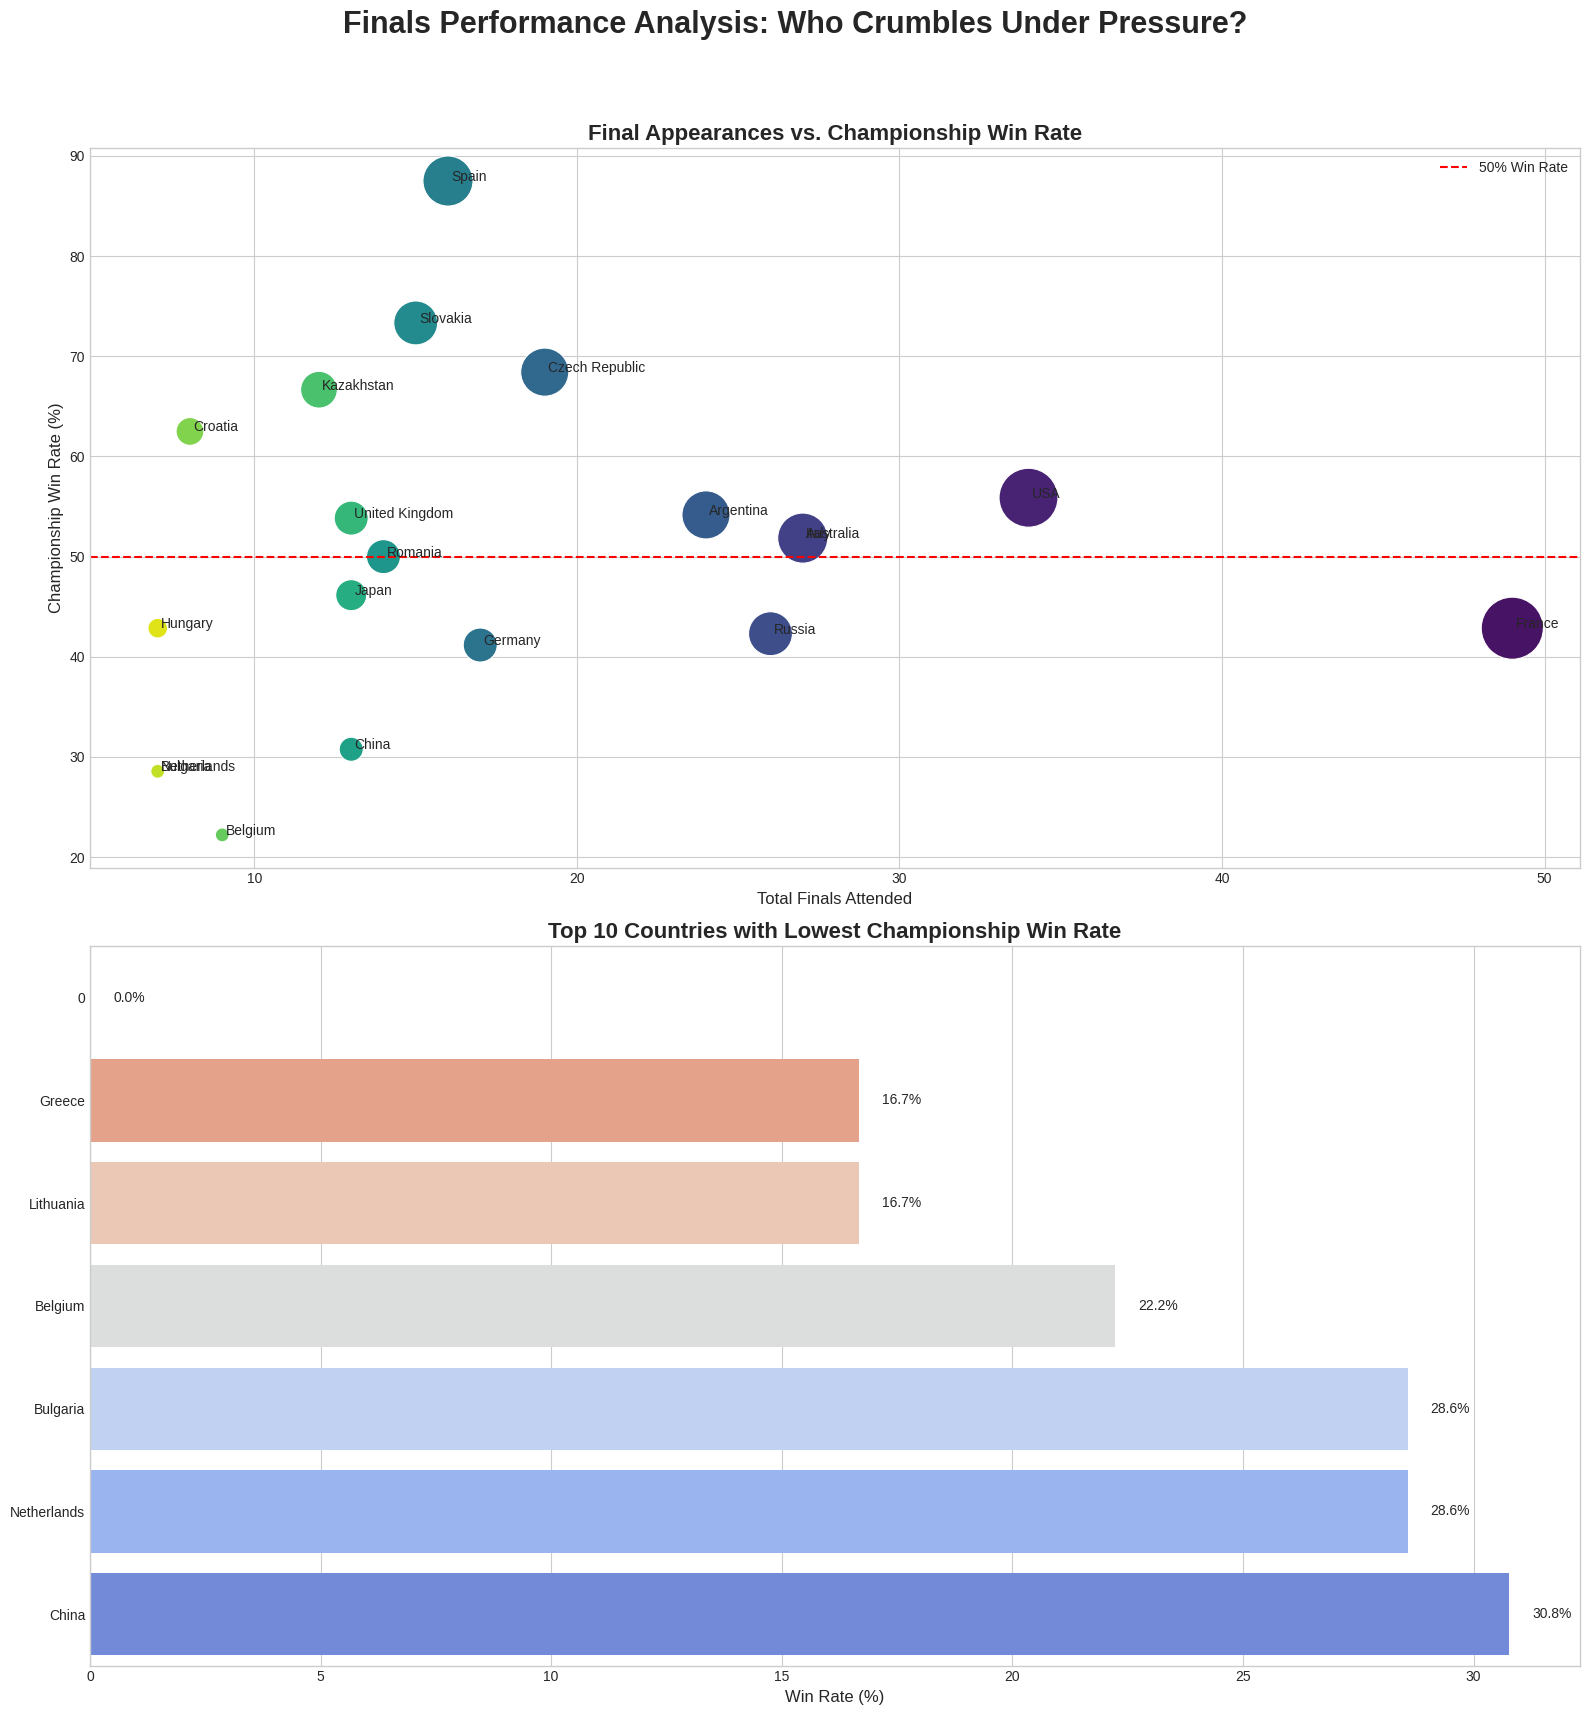

In [51]:
# --- توابع کمکی (Best Practices) ---
def latest_per_match(df, key='match_id'):
    if 'source_date' in df.columns:
        return df.sort_values([key, 'source_date']).drop_duplicates(subset=[key], keep='last')
    return df.drop_duplicates(subset=[key], keep='last')

def infer_singles_soft(df):
    if 'competition_type' in df.columns:
        comp = df['competition_type']
        is_singles_explicit = (comp == 1.0); is_doubles_explicit = (comp == 2.0)
    else:
        is_singles_explicit = pd.Series(False, index=df.index); is_doubles_explicit = pd.Series(False, index=df.index)
    
    tournament_name = df.get('tournament_name', pd.Series('', index=df.index)).astype(str).str.lower()
    season_name = df.get('season_name', pd.Series('', index=df.index)).astype(str).str.lower()
    combined_text = tournament_name + ' ' + season_name
    
    contains_doubles = combined_text.str.contains('double|dbl|doubles', na=False, regex=True)
    contains_singles = combined_text.str.contains('single|singles', na=False, regex=True)
    
    is_singles = (is_singles_explicit | (contains_singles & ~contains_doubles) | (~is_doubles_explicit & ~contains_doubles & ~contains_singles))
    return is_singles

# --- توابع نمایش نتایج حرفه‌ای ---
def display_final_pressure_report(ranked_countries):
    print("\n" + "=" * 100)
    print("🏆 " + " FINAL PRESSURE ANALYSIS REPORT ".center(92, "═") + " 🏆")
    print("=" * 100)
    
    if ranked_countries.empty:
        print("   No countries met the minimum criteria for analysis.")
        return
        
    top_pressure_country = ranked_countries.iloc[0]
    print("\n🤯 **Country Under Most Pressure in Finals:**")
    print("─" * 50)
    print(f"   • Country: {top_pressure_country['country']}")
    print(f"   • Finals Attended: {int(top_pressure_country['finals_attended'])}")
    print(f"   • Championships Won: {int(top_pressure_country['championships_won'])}")
    print(f"   • Championship Win Rate: {top_pressure_country['win_rate']:.1f}%")
    
    print("\n\n📋 **Top 15 Countries by Final Appearances (with low win rates):**")
    print("─" * 70)
    
    report_data = ranked_countries.head(15).copy()
    report_data['Rank'] = range(1, len(report_data) + 1)
    report_data['Win Rate'] = report_data['win_rate'].apply(lambda x: f"{x:.1f}%")
    
    print(tabulate(report_data[['Rank', 'country', 'finals_attended', 'championships_won', 'Win Rate']],
                   headers=['Rank', 'Country', 'Finals', 'Wins', 'Win Rate'],
                   tablefmt='pretty'))

def create_final_pressure_dashboard(ranked_countries):
    if ranked_countries.empty:
        return
        
    plt.style.use('seaborn-v0_8-whitegrid')
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(16, 18))
    fig.suptitle("Finals Performance Analysis: Who Crumbles Under Pressure?", fontsize=22, fontweight='bold')

    # نمودار ۱: رابطه بین حضور در فینال و نرخ قهرمانی
    top_countries = ranked_countries.head(20)
    
    scatter = sns.scatterplot(
        data=top_countries,
        x='finals_attended',
        y='win_rate',
        size='championships_won',
        sizes=(100, 2000),
        hue='country',
        palette='viridis',
        legend=False,
        ax=ax1
    )
    ax1.set_title('Final Appearances vs. Championship Win Rate', fontsize=16, fontweight='bold')
    ax1.set_xlabel('Total Finals Attended', fontsize=12)
    ax1.set_ylabel('Championship Win Rate (%)', fontsize=12)
    ax1.axhline(50, color='red', linestyle='--', label='50% Win Rate')
    ax1.legend()
    
    for i, row in top_countries.iterrows():
        ax1.text(row['finals_attended'] + 0.1, row['win_rate'], row['country'], fontsize=10)

    # نمودار ۲: ۱۰ کشور با کمترین نرخ قهرمانی (از بین واجدین شرایط)
    lowest_rate_countries = ranked_countries.nsmallest(10, 'win_rate')
    sns.barplot(data=lowest_rate_countries, x='win_rate', y='country', ax=ax2, palette='coolwarm_r', orient='h')
    ax2.set_title('Top 10 Countries with Lowest Championship Win Rate', fontsize=16, fontweight='bold')
    ax2.set_xlabel('Win Rate (%)', fontsize=12)
    ax2.set_ylabel('')
    
    for p in ax2.patches:
        width = p.get_width()
        ax2.text(width + 0.5, p.get_y() + p.get_height() / 2, f'{width:.1f}%', va='center')
        
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

def analyze_final_pressure(data_path, min_finals_attended=3):
    """
    سوال ۷ جدید: فشار فینال
    """

    # --- مرحله ۱: بارگذاری و انتخاب اسنپ‌شات‌ها ---
    p = Path(data_path)
    event = latest_per_match(pd.read_parquet(p / "event_complete.parquet"))
    tournament = latest_per_match(pd.read_parquet(p / "tournament_complete.parquet"))
    season = latest_per_match(pd.read_parquet(p / "season_complete.parquet"))
    home_team = latest_per_match(pd.read_parquet(p / "home_team_complete.parquet"))
    away_team = latest_per_match(pd.read_parquet(p / "away_team_complete.parquet"))
    round_info = latest_per_match(pd.read_parquet(p / "round_complete.parquet"))

    # --- مرحله ۲: شناسایی فینال‌ها و فیلترهای اولیه ---
    final_match_ids = round_info[round_info["cup_round_type"] == 1.0]["match_id"].unique()
    finals_df = event[event["match_id"].isin(final_match_ids)].copy()
    
    finals_df = finals_df.merge(tournament, on="match_id", how="left", suffixes=("", "_tour"))
    finals_df = finals_df.merge(season.rename(columns={'name': 'season_name'}), on="match_id", how="left")
    
    singles_mask = infer_singles_soft(finals_df)
    finals_df = finals_df[singles_mask].copy()
    
    finals_df = finals_df[finals_df['winner_code'].isin([1.0, 2.0])].copy()
    
    finals_df = finals_df.merge(home_team, on="match_id", how="left", suffixes=("", "_home"))
    finals_df = finals_df.merge(away_team, on="match_id", how="left", suffixes=("", "_away"))
    finals_df.dropna(subset=['country', 'country_away', 'player_id', 'player_id_away'], inplace=True)

    # --- مرحله ۳: تعیین کشور برنده و بازنده ---
    finals_df['winner_country'] = np.where(finals_df['winner_code'] == 1, finals_df['country'], finals_df['country_away'])
    finals_df['loser_country'] = np.where(finals_df['winner_code'] == 1, finals_df['country_away'], finals_df['country'])
    
    # --- مرحله ۴: تجمیع آمار در سطح کشور ---
    wins = finals_df.groupby('winner_country').size().reset_index(name='championships_won')
    losses = finals_df.groupby('loser_country').size().reset_index(name='finals_lost')
    
    # ادغام نتایج برد و باخت
    country_stats = pd.merge(wins, losses, left_on='winner_country', right_on='loser_country', how='outer').fillna(0)
    country_stats['country'] = country_stats['winner_country'].fillna(country_stats['loser_country'])
    country_stats = country_stats.drop(columns=['winner_country', 'loser_country'])
    
    country_stats['finals_attended'] = country_stats['championships_won'] + country_stats['finals_lost']
    country_stats['win_rate'] = (country_stats['championships_won'] / country_stats['finals_attended']) * 100
    
    # فیلتر کشورهایی با حداقل حضور در فینال
    qualified_countries = country_stats[country_stats['finals_attended'] >= min_finals_attended].copy()
    
    # مرتب‌سازی: اول بر اساس بیشترین حضور، سپس کمترین نرخ برد
    ranked_countries = qualified_countries.sort_values(by=['finals_attended', 'win_rate'], ascending=[False, True])
    
    # --- مرحله ۵: نمایش نتایج و بصری‌سازی ---
    display_final_pressure_report(ranked_countries)
    create_final_pressure_dashboard(ranked_countries)
    
    return ranked_countries

# --- اجرای تابع تحلیل ---
data_path = Path("/home/mohammadreza77615/Desktop/Tennis Schema/Final_parquet")
final_pressure_df = analyze_final_pressure(data_path, min_finals_attended=3)

این آمار لزوماً منفی نیست. 
حضور زیاد در فینال (حتی با باخت) نشان‌دهنده قدرت و عمق استعداد یک کشور در رساندن بازیکنان به مراحل نهایی تورنمنت‌ها است. جداول بر اساس کشورهایی که حداقل 3 بار در فینال حضور داشته اند رسم شده است.

### سوال 8 : آیا خرد جمعی کار می‌کند؟ پیش‌بینی کاربران (بر اساس votes) تا چه حد با نتیجه واقعی مسابقات همخوانی دارد؟


🎯 نتیجه نهایی: آیا خرد جمعی کار می‌کند؟
📈 **دقت کلی پیش‌بینی کاربران: 68.6%**
--------------------------------------------------
🤯 **نرخ شگفتی: 31.4%**
   در این درصد از مسابقات، بازیکنی که محبوبیت کمتری داشت، برنده شد.

🎨 مرحله ۶: ترسیم داشبورد تحلیلی...


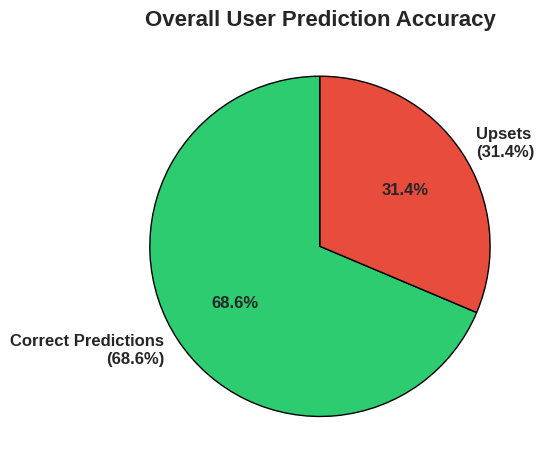

In [56]:
# --- توابع کمکی (Best Practices) ---
def latest_per_match(df, key='match_id'):
    if 'source_date' in df.columns:
        return df.sort_values([key, 'source_date']).drop_duplicates(subset=[key], keep='last')
    return df.drop_duplicates(subset=[key], keep='last')

def analyze_user_vote_accuracy(data_path, plot=True):
    """
    سوال ۶ جدید: آیا خرد جمعی کار می‌کند؟ (مقایسه Votes با Reality)
    """

    # --- مرحله ۱: بارگذاری داده‌ها و انتخاب اسنپ‌شات‌ها ---
    p = Path(data_path)
    votes = latest_per_match(pd.read_parquet(p / "votes_complete.parquet"))
    event = latest_per_match(pd.read_parquet(p / "event_complete.parquet"))
    tournament = latest_per_match(pd.read_parquet(p / "tournament_complete.parquet"))
    season = latest_per_match(pd.read_parquet(p / "season_complete.parquet"))
    
    # --- مرحله ۲: ایجاد دیتافریم جامع و فیلترها (آسان‌گیر) ---
    matches_df = votes.merge(event[['match_id', 'winner_code']], on='match_id', how='inner')
    matches_df = matches_df.merge(tournament, on="match_id", how="left", suffixes=("", "_tour"))
    matches_df = matches_df.merge(season.rename(columns={'name': 'season_name'}), on="match_id", how="left")
    
    # فیلتر مسابقات با نتیجه مشخص
    initial_count = len(matches_df)
    valid_matches_df = matches_df[matches_df['winner_code'].isin([1.0, 2.0])].copy()

    # --- مرحله ۳: پردازش آرا و تعیین پیش‌بینی کاربران ---
    
    # محاسبه کل آرا و درصد هر بازیکن
    valid_matches_df['total_votes'] = valid_matches_df['home_vote'] + valid_matches_df['away_vote']
    valid_matches_df = valid_matches_df[valid_matches_df['total_votes'] > 0] # حذف مسابقات بدون رای
    
    valid_matches_df['home_vote_pct'] = valid_matches_df['home_vote'] / valid_matches_df['total_votes']
    valid_matches_df['away_vote_pct'] = valid_matches_df['away_vote'] / valid_matches_df['total_votes']
    
    # تعیین پیش‌بینی کاربران (بازیکنی که رای بیشتری دارد)
    valid_matches_df['predicted_winner_by_votes'] = np.where(
        valid_matches_df['home_vote'] > valid_matches_df['away_vote'], 1, 2
    )
    
    # در حالت تساوی آرا، پیش‌بینی نامشخص است
    valid_matches_df.loc[valid_matches_df['home_vote'] == valid_matches_df['away_vote'], 'predicted_winner_by_votes'] = 0
    
    # --- مرحله ۴: مقایسه پیش‌بینی با نتیجه واقعی ---
    # حذف مسابقات با آرای مساوی از تحلیل دقت
    analysis_df = valid_matches_df[valid_matches_df['predicted_winner_by_votes'] != 0].copy()
    
    analysis_df['prediction_correct'] = (analysis_df['predicted_winner_by_votes'] == analysis_df['winner_code'])
    accuracy = analysis_df['prediction_correct'].mean() * 100
    upset_rate = 100 - accuracy
    
    # --- مرحله ۵: نمایش نتایج متنی ---
    print("\n" + "=" * 80)
    print("🎯 نتیجه نهایی: آیا خرد جمعی کار می‌کند؟")
    print("=" * 80)
    print(f"📈 **دقت کلی پیش‌بینی کاربران: {accuracy:.1f}%**")
    print("-" * 50)
    print(f"🤯 **نرخ شگفتی: {upset_rate:.1f}%**")
    print("   در این درصد از مسابقات، بازیکنی که محبوبیت کمتری داشت، برنده شد.")
    print("=" * 80)

    # --- مرحله ۶: بصری‌سازی حرفه‌ای ---
    if plot:
        print("\n🎨 مرحله ۶: ترسیم داشبورد تحلیلی...")
        create_votes_dashboard(analysis_df, accuracy, upset_rate)
        
    return analysis_df

def create_votes_dashboard(analysis_df, accuracy, upset_rate):
    """
    ایجاد داشبورد حرفه‌ای برای تحلیل آرای کاربران.
    """
    plt.style.use('seaborn-v0_8-whitegrid')
    fig = plt.figure(figsize=(20, 10))
    
    gs = fig.add_gridspec(2, 2)
    ax1 = fig.add_subplot(gs[0, 0])

    # نمودار ۱: Pie Chart - دقت کلی
    sizes = [accuracy, upset_rate]
    labels = [f'Correct Predictions\n({accuracy:.1f}%)', f'Upsets\n({upset_rate:.1f}%)']
    colors = ['#2ecc71', '#e74c3c']
    ax1.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=90,
            wedgeprops={'edgecolor': 'black'}, textprops={'fontsize': 12, 'fontweight': 'bold'})
    ax1.set_title('Overall User Prediction Accuracy', fontsize=16, fontweight='bold')

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

# --- اجرای تابع ---
data_path = Path("/home/mohammadreza77615/Desktop/Tennis Schema/Final_parquet")
votes_analysis_df = analyze_user_vote_accuracy(data_path, plot=True)

نزدیک بودن خروجی سوال های 5 و 8 یک تأیید قوی بر این ایده است که "خرد جمعی" در پیش‌بینی نتایج ورزشی تنیس به علت وجود اطلاعات خوب مانند رنکینگ بازیکنان، فرم اخیر، سابقه رویارویی، و شناخت کلی از سبک بازی یک ابزار قدرتمند است و لزوماً برای رسیدن به پیش‌بینی‌های خوب، نیازی به مدل‌های بسیار پیچیده نیست. اگرچه هر دو گروه در حدود ۳۰٪ از مواقع اشتباه می‌کنند (نرخ شگفتی)، این نشان می‌دهد که ورزش حتی با بهترین مدل‌ها یا بیشترین دانش جمعی نیز قابل پیش‌بینی نیست و این همان چیزی است که ورزش را جذاب می‌کند.